# CNN para classificação do sinal no tempo

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import scipy
from pathlib import Path
import pandas as pd

torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1650'

### Estudos

In [ ]:
windows = np.load(
    "datasets/sinais_filtrados_6_52_Hz_janelas_1s/S1_passa-banda_6_52_Hz_janelas.npy"
)
windows.shape

In [ ]:
frequencias_fases = scipy.io.loadmat("Freq_Phase.mat")
frequencias = np.round(
    frequencias_fases["freqs"], 2
)  # Frequências de estimulação, arredondadas
fases = frequencias_fases["phases"]  # Fases associadas às frequências

freq_selecionadas = np.array([8, 10, 12, 15])  # Frequências de interesse
channels = [
    47,
    53,
    54,
    55,
    56,
    57,
    60,
    61,
    62,
]  #  Pz, PO5, PO3, POz, PO4, PO6, O1, Oz, O2

channel_Oz = 61
labels = []
signals = []
for trial in range(0, 6):
    labels_trial = []
    signals_trial = []
    for idx, freq in enumerate(freq_selecionadas):
        for window in range(0, 5):
            signal = windows[
                channels, :, np.where(frequencias == freq)[1], trial, window
            ]
            signals_trial.append(signal)
            labels_trial.append(idx)
    labels.append(labels_trial)
    signals.append(signals_trial)

signals = np.array(signals)
labels = np.array(labels)
print(signals.shape)
print(labels.shape)

In [ ]:
from utils import prepare_data

train_loader, test_loader = prepare_data(
    signals, labels, test_trial=0, train_batch_size=20
)

### Modelo

In [6]:
from CNNModel1d import CNNModel1d


def train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=100,
    device=0,
    save_path="best_model_raw.pth",
):
    best_val_accuracy = 0.0
    model.to(device)
    early_stop_count = 0
    current_min_val_loss = float("inf")
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # eval train
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        train_accuracy = train_correct / train_total
        avg_train_loss = running_loss / len(train_loader)

        # eval validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # val accuracy
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)

        # Save if best vall acc
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved with accuracy: {best_val_accuracy:.4f}")

        print(
            f"Epoch {epoch + 1}/{num_epochs}: "
            f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}"
        )
        if (avg_val_loss + 0.01) <= current_min_val_loss:
            current_min_val_loss = avg_val_loss
            early_stop_count = 0
            print(f"Validation loss decreased...")
        else:
            early_stop_count += 1
            if early_stop_count >= 15:
                print(
                    f"Validation loss has not decreased for 10 epochs. Stoping training..."
                )
                break

### Teste

In [ ]:
model = CNNModel1d(9, 4).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Train the model
train(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)

In [ ]:
from utils import evaluate

# Evaluate


best_model = CNNModel1d(n_channels=9, n_classes=4)


best_model.load_state_dict(torch.load("best_model_raw.pth"))
best_model.to(device)


evaluate(best_model, test_loader, ["8", "10", "12", "15"], 0)

## Cross validation

### Oz

In [ ]:
frequencias_fases = scipy.io.loadmat("Freq_Phase.mat")
frequencias = np.round(
    frequencias_fases["freqs"], 2
)  # Frequências de estimulação, arredondadas
fases = frequencias_fases["phases"]  # Fases associadas às frequências

freq_selecionadas = np.array([8, 10, 12, 15])  # Frequências de interesse

channel_Oz = 61
labels = []
signals = []
for trial in range(0, 6):
    labels_trial = []
    signals_trial = []
    for idx, freq in enumerate(freq_selecionadas):
        for window in range(0, 5):
            signal = windows[
                channel_Oz, :, np.where(frequencias == freq)[1], trial, window
            ]
            signals_trial.append(signal)
            labels_trial.append(idx)
    labels.append(labels_trial)
    signals.append(signals_trial)

signals = np.array(signals)
labels = np.array(labels)
print(signals.shape)
print(labels.shape)

In [ ]:
all_acc = []
all_recall = []
all_f1 = []
for test_trial in range(0, 6):
    train_loader, test_loader = prepare_data(
        signals, labels, test_trial=test_trial, train_batch_size=20
    )
    model = CNNModel1d(1, 4).to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Train
    train(
        model,
        train_loader,
        test_loader,
        criterion,
        optimizer,
        num_epochs=100,
        save_path="best_model_raw.pth",
    )
    best_model = CNNModel1d(n_channels=1, n_classes=4)
    best_model.load_state_dict(torch.load("best_model_raw.pth"))
    best_model.to(device)
    # Eval
    acc, rcll, f1s = evaluate(
        best_model, test_loader, class_labels=["8", "10", "12", "15"]
    )
    all_acc.append(acc)
    all_recall.append(rcll)
    all_f1.append(f1s)

all_acc = np.array(all_acc)
all_recall = np.array(all_recall)
all_f1 = np.array(all_f1)

In [ ]:
print(all_acc.mean())
print(all_recall.mean())
print(all_f1.mean())

### Pz, PO5, PO3, POz, PO4, PO6, O1, Oz, O2

In [ ]:
windows = np.load(
    "datasets/sinais_filtrados_6_52_Hz_janelas_1s/S1_passa-banda_6_52_Hz_janelas.npy"
)
frequencias_fases = scipy.io.loadmat("Freq_Phase.mat")
frequencias = np.round(
    frequencias_fases["freqs"], 2
)  # Frequências de estimulação, arredondadas
fases = frequencias_fases["phases"]  # Fases associadas às frequências

freq_selecionadas = np.array([8, 10, 12, 15])  # Frequências de interesse
channels = [
    47,
    53,
    54,
    55,
    56,
    57,
    60,
    61,
    62,
]  #  Pz, PO5, PO3, POz, PO4, PO6, O1, Oz, O2

labels = []
signals = []
for trial in range(0, 6):
    labels_trial = []
    signals_trial = []
    for idx, freq in enumerate(freq_selecionadas):
        for window in range(0, 5):
            signal = windows[
                channels, :, np.where(frequencias == freq)[1], trial, window
            ]
            signals_trial.append(signal)
            labels_trial.append(idx)
    labels.append(labels_trial)
    signals.append(signals_trial)

signals = np.array(signals)
labels = np.array(labels)
print(signals.shape)
print(labels.shape)

In [ ]:
frequencias[0].shape

In [ ]:
all_acc = []
all_recall = []
all_f1 = []
for test_trial in range(0, 6):
    train_loader, test_loader = prepare_data(
        signals, labels, test_trial=test_trial, train_batch_size=20
    )

    model = CNNModel1d(9, 4).to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Train the model
    train(
        model,
        train_loader,
        test_loader,
        criterion,
        optimizer,
        num_epochs=50,
        save_path="best_model_raw_2.pth",
    )
    best_model = CNNModel1d(n_channels=9, n_classes=4)
    best_model.load_state_dict(torch.load("best_model_raw_2.pth"))
    best_model.to(device)
    # Eval
    acc, rcll, f1s = evaluate(
        best_model, test_loader, class_labels=["8", "10", "12", "15"]
    )
    all_acc.append(acc)
    all_recall.append(rcll)
    all_f1.append(f1s)
all_acc = np.array(all_acc)
all_recall = np.array(all_recall)
all_f1 = np.array(all_f1)

In [ ]:
print(all_acc.mean())
print(all_recall.mean())
print(all_f1.mean())

# All subjects

In [7]:
import pandas as pd
from pathlib import Path
import numpy as np
import scipy
from utils import get_desired_freqs_and_classes

In [20]:
def run_and_evaluate(subject, signals, labels, batch_size, epochs):
    all_acc = []
    all_recall = []
    all_f1 = []
    for test_trial in range(0, 6):
        train_loader, test_loader = prepare_data(
            signals, labels, test_trial=test_trial, train_batch_size=batch_size
        )

        num_channels = signals.shape[2]
        num_freqs = len(np.unique(labels))

        model = CNNModel1d(num_channels, num_freqs).to(device)
        criterion = nn.NLLLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        # Train the model
        best_model_save_path = (
            f"best_trained_raw_models/{subject}_best_model_raw_{test_trial}.pth"
        )
        train(
            model,
            train_loader,
            test_loader,
            criterion,
            optimizer,
            num_epochs=epochs,
            save_path=best_model_save_path,
        )
        # Eval
        best_model = CNNModel1d(n_channels=num_channels, n_classes=num_freqs)
        best_model.load_state_dict(torch.load(best_model_save_path))
        best_model.to(device)
        acc, rcll, f1s = evaluate(best_model, test_loader, class_labels=frequencias[0])
        all_acc.append(acc)
        all_recall.append(rcll)
        all_f1.append(f1s)
    metrics = {
        "accuracy": np.array(all_acc),
        "recall": np.array(all_recall),
        "f1_score": np.array(all_f1),
    }
    return metrics


def run_model_for_all_subjects(dataset_path, batch_size, channels, classes, epochs):
    results = {}

    subjects_files = [file for file in dataset_path.glob("*.npy")]
    freq_phase = scipy.io.loadmat("Freq_Phase.mat")
    freqs = np.round(freq_phase["freqs"], 2)  # Frequências de estimulação, arredondadas
    phases = freq_phase["phases"]  # Fases associadas às frequências

    for subject_file in subjects_files:
        subject = subject_file.name.split("_")[0]
        print(f"Running for subject {subject} ---------------")
        windows = np.load(subject_file)
        signals, labels = get_desired_freqs_and_classes(
            windows, freqs, channels, classes
        )
        results[subject] = run_and_evaluate(
            subject, signals, labels, batch_size, epochs
        )
    return results

In [ ]:
dataset_path = Path("datasets/sinais_filtrados_6_52_Hz_janelas_1s/")
selected_freqs = frequencias[0]  # np.array([8, 10, 12, 15])  # Frequências de interesse
channels = [
    47,
    53,
    54,
    55,
    56,
    57,
    60,
    61,
    62,
]  #  Pz, PO5, PO3, POz, PO4, PO6, O1, Oz, O2
epochs = 100
results_dict = run_model_for_all_subjects(
    dataset_path, 20, channels, selected_freqs, epochs
)
results_dict

In [ ]:
results_dict

In [97]:
mean_results_dict = {}
for subj, metrics in results_dict.items():
    means = {}
    for metric, values in metrics.items():
        means[metric] = values.mean()
    mean_results_dict[subj] = means
df = pd.DataFrame.from_dict(mean_results_dict, orient="index")
df.to_csv("results_cnn1d.csv")

In [ ]:
df

# Cross subject

In [3]:
from utils import evaluate, get_desired_freqs_and_classes, prepare_data_subjects


def run_and_evaluate_cross_subject(
    subject, signals, labels, batch_size, epochs, freqs_labels, validation=True
):
    test_subject = int(subject[1:]) - 1
    if validation:
        train_loader, test_loader, validation_loader = prepare_data_subjects(
            signals,
            labels,
            test_subject=test_subject,
            train_batch_size=batch_size,
            validation_split=True,
        )
    else:
        train_loader, test_loader = prepare_data_subjects(
            signals,
            labels,
            test_subject=test_subject,
            train_batch_size=batch_size,
            validation_split=False,
        )
        validation_loader = test_loader

    num_channels = signals.shape[2]
    num_freqs = len(np.unique(labels))

    model = CNNModel1d(num_channels, num_freqs).to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    best_model_save_path = f"best_trained_raw_models/cross_subject/4freq/{test_subject + 1}_best_model_raw_cross.pth"

    train(
        model,
        train_loader,
        validation_loader,
        criterion,
        optimizer,
        num_epochs=epochs,
        save_path=best_model_save_path,
    )

    # Eval
    best_model = CNNModel1d(n_channels=num_channels, n_classes=num_freqs)
    best_model.load_state_dict(torch.load(best_model_save_path))
    best_model.to(device)
    cm_path = f"best_trained_raw_models/cross_subject/4freq/cm/{test_subject + 1}.png"
    freq_phase = scipy.io.loadmat("Freq_Phase.mat")
    freqs = np.round(freq_phase["freqs"], 2)  # Frequências de estimulação, arredondadas
    acc, rcll, f1s = evaluate(
        best_model, test_loader, class_labels=freqs_labels, filename=cm_path
    )
    metrics = {
        "accuracy": np.array(acc),
        "recall": np.array(rcll),
        "f1_score": np.array(f1s),
    }

    return metrics


def run_model_for_all_subjects(dataset_path, batch_size, channels, classes, epochs):
    results = {}
    subjects_files = [file for file in dataset_path.glob("*.npy")]
    freq_phase = scipy.io.loadmat("Freq_Phase.mat")
    freqs = np.round(freq_phase["freqs"], 2)  # Frequências de estimulação, arredondadas

    signals = []
    labels = []

    def sort_key(path):
        subject_number = int(path.stem.split("_")[0][1:])
        return subject_number

    sorted_paths = sorted(subjects_files, key=sort_key)

    for subject_file in sorted_paths:
        windows = np.load(subject_file)
        subj_signals, subj_labels = get_desired_freqs_and_classes(
            windows, freqs, channels, classes
        )
        num_samples = 5 * 6 * len(classes)
        signals.append(subj_signals.reshape([num_samples, 9, 250]))
        labels.append(subj_labels.reshape(num_samples))

    signals = np.array(signals)
    labels = np.array(labels)

    for subject_file in sorted_paths:
        subject = subject_file.name.split("_")[0]
        print(f"Running for subject {subject} ---------------")
        results[subject] = run_and_evaluate_cross_subject(
            subject, signals, labels, batch_size, epochs, classes
        )

    return results

In [ ]:
dataset_path = Path("datasets/sinais_filtrados_6_52_Hz_janelas_1s/")
freq_phase = scipy.io.loadmat("Freq_Phase.mat")
freqs = np.round(freq_phase["freqs"], 2)
selected_freqs = freqs[0][0:8]  #  np.array([8, 10, 12, 15])  # Frequências de interesse

channels = [
    47,
    53,
    54,
    55,
    56,
    57,
    60,
    61,
    62,
]  #  Pz, PO5, PO3, POz, PO4, PO6, O1, Oz, O2

epochs = 50
results_dict = run_model_for_all_subjects(
    dataset_path, 32, channels, selected_freqs, epochs
)
# mean_results_dict = {}

# for subj, metrics in results_dict.items():
#     means = {}
#     for metric, values in metrics.items():
#         means[metric] = values.mean()
#     mean_results_dict[subj] = means

df = pd.DataFrame.from_dict(results_dict, orient="index")

df.to_csv(
    "best_trained_raw_models/cross_subject/freq/results_cnn1d_cross_subj_8_freqs.csv"
)

Running for subject S1 ---------------
Testing on subject 1.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.5833
Epoch 1/50: Train Loss: 1.2409, Train Accuracy: 0.3993, Val Loss: 0.9932, Val Accuracy: 0.5833
Validation loss decreased...
Best model saved with accuracy: 0.8750
Epoch 2/50: Train Loss: 0.7301, Train Accuracy: 0.7387, Val Loss: 0.6453, Val Accuracy: 0.8750
Validation loss decreased...
Epoch 3/50: Train Loss: 0.5906, Train Accuracy: 0.7939, Val Loss: 0.5090, Val Accuracy: 0.8750
Validation loss decreased...
Best model saved with accuracy: 1.0000
Epoch 4/50: Train Loss: 0.5138, Train Accuracy: 0.8174, Val Loss: 0.3722, Val Accuracy: 1.0000
Validation loss decreased...
Epoch 5/50: Train Loss: 0.4772, Train Accuracy: 0.8316, Val Loss: 0.3653, Val Accuracy: 0.9583
Epoch 6/50: Train Loss: 0.4646, Train Accuracy: 0.8385, Val Loss: 0.4368, Val Accuracy: 0.9167
Epoch 7/50: Train Loss: 0.4529, Train Accuracy: 0.8466, Va

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

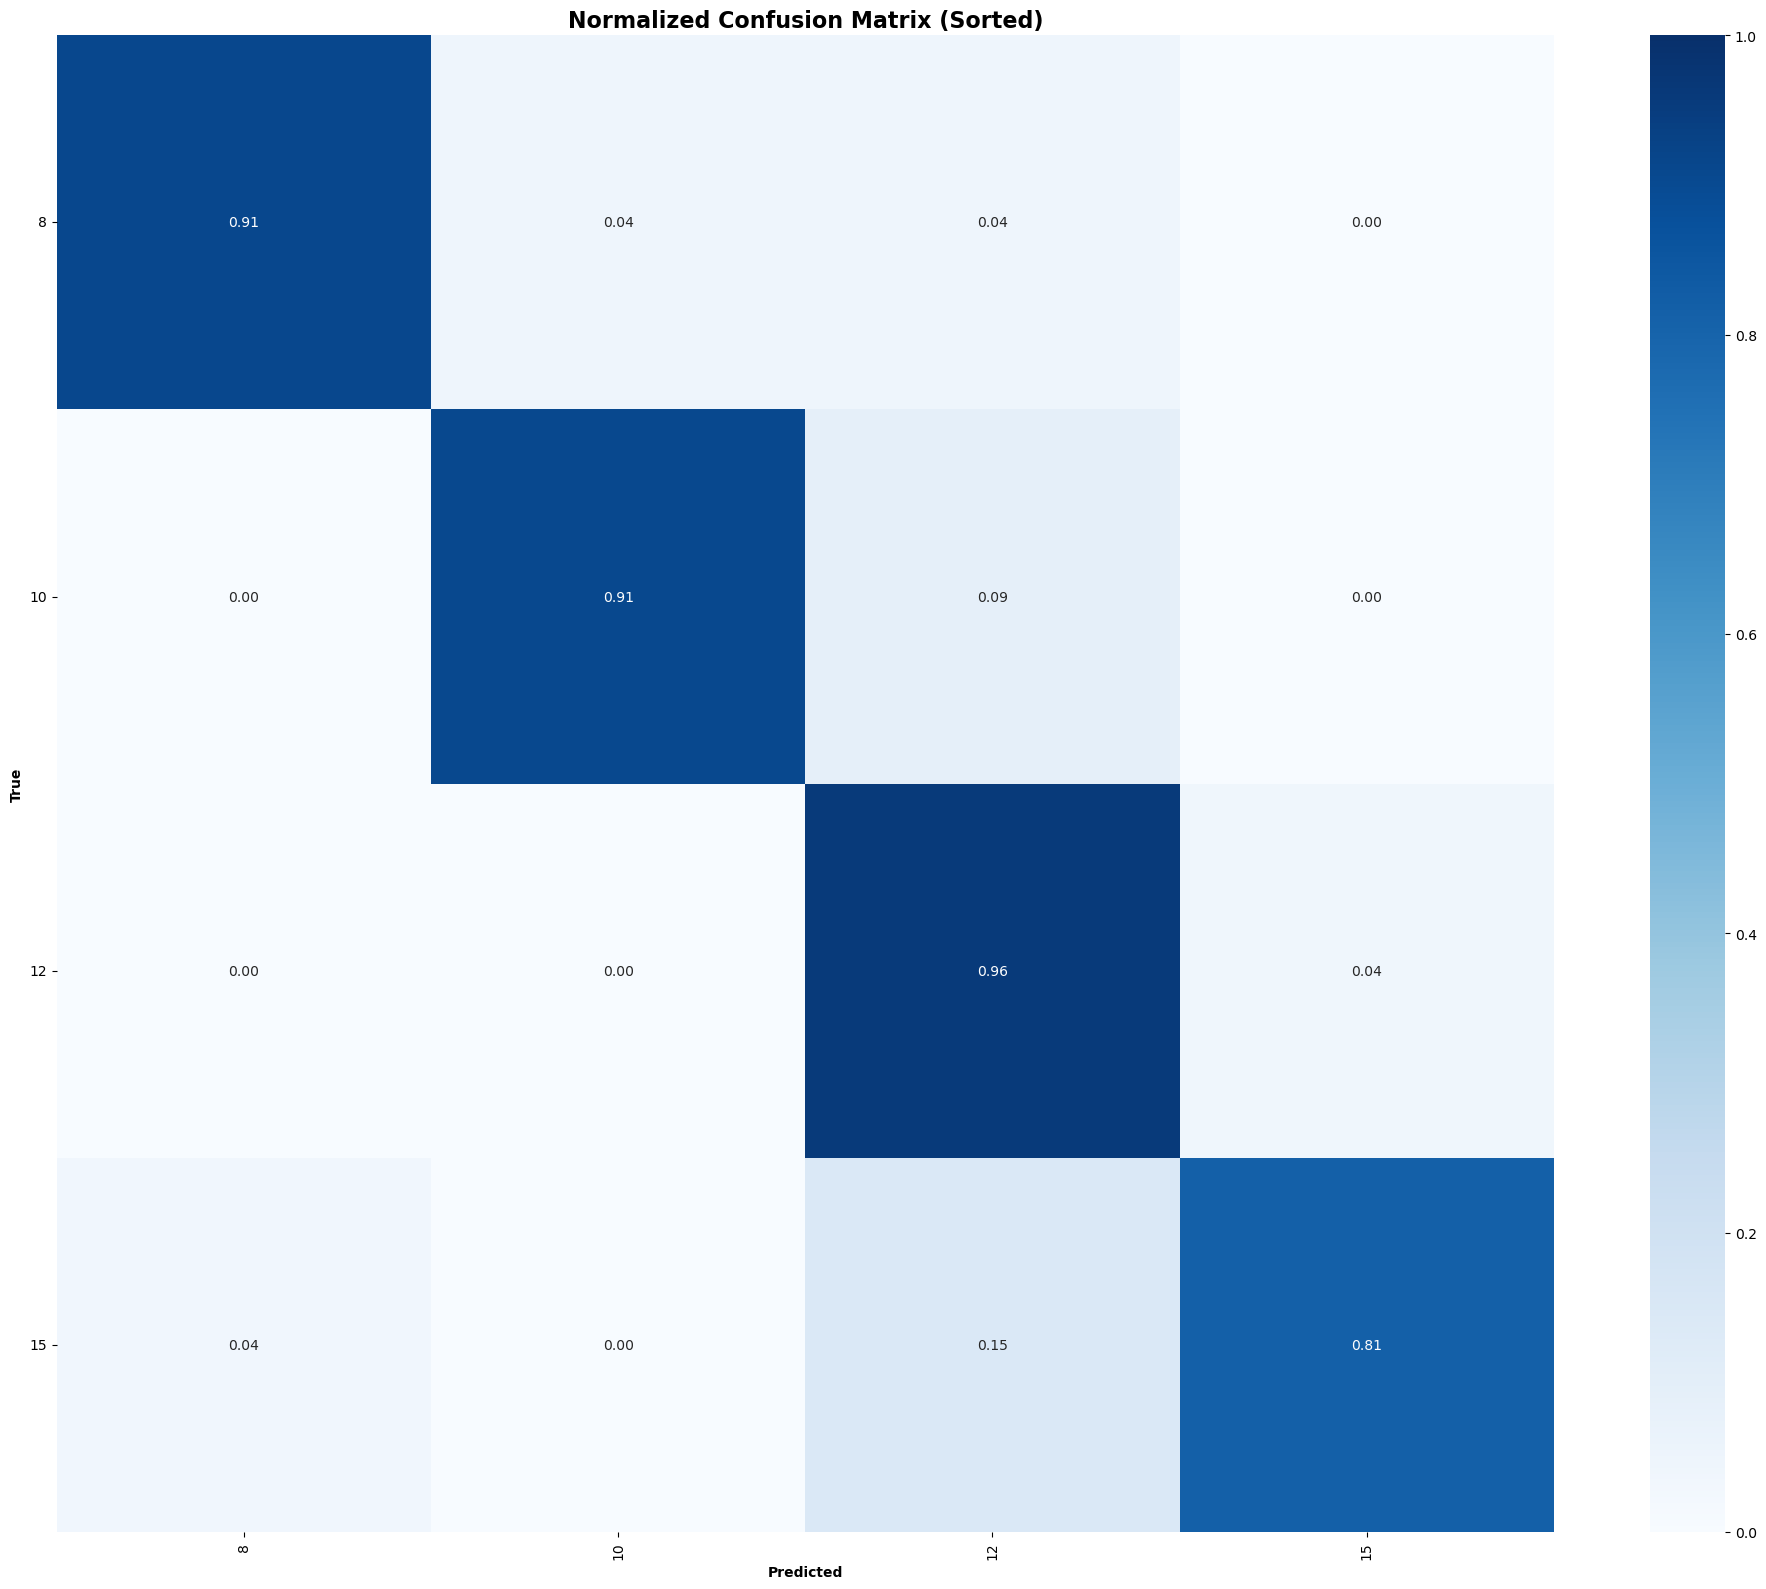

Test set Accuracy: 0.8958
Recall: 0.8958
F1 Score: 0.8973
Confusion Matrix:
[[21  1  1  0]
 [ 0 20  2  0]
 [ 0  0 23  1]
 [ 1  0  4 22]]
Running for subject S2 ---------------
Testing on subject 2.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.5833
Epoch 1/50: Train Loss: 1.2131, Train Accuracy: 0.4110, Val Loss: 0.9483, Val Accuracy: 0.5833
Validation loss decreased...
Best model saved with accuracy: 0.7083
Epoch 2/50: Train Loss: 0.6280, Train Accuracy: 0.7772, Val Loss: 0.8974, Val Accuracy: 0.7083
Validation loss decreased...
Epoch 3/50: Train Loss: 0.5148, Train Accuracy: 0.8199, Val Loss: 0.8193, Val Accuracy: 0.6667
Validation loss decreased...
Epoch 4/50: Train Loss: 0.4764, Train Accuracy: 0.8311, Val Loss: 0.8722, Val Accuracy: 0.6667
Epoch 5/50: Train Loss: 0.4488, Train Accuracy: 0.8400, Val Loss: 0.8127, Val Accuracy: 0.7083
Epoch 6/50: Train Loss: 0.4262, Train Accuracy: 0.8556, Val Loss: 0.8290, Val Accura

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

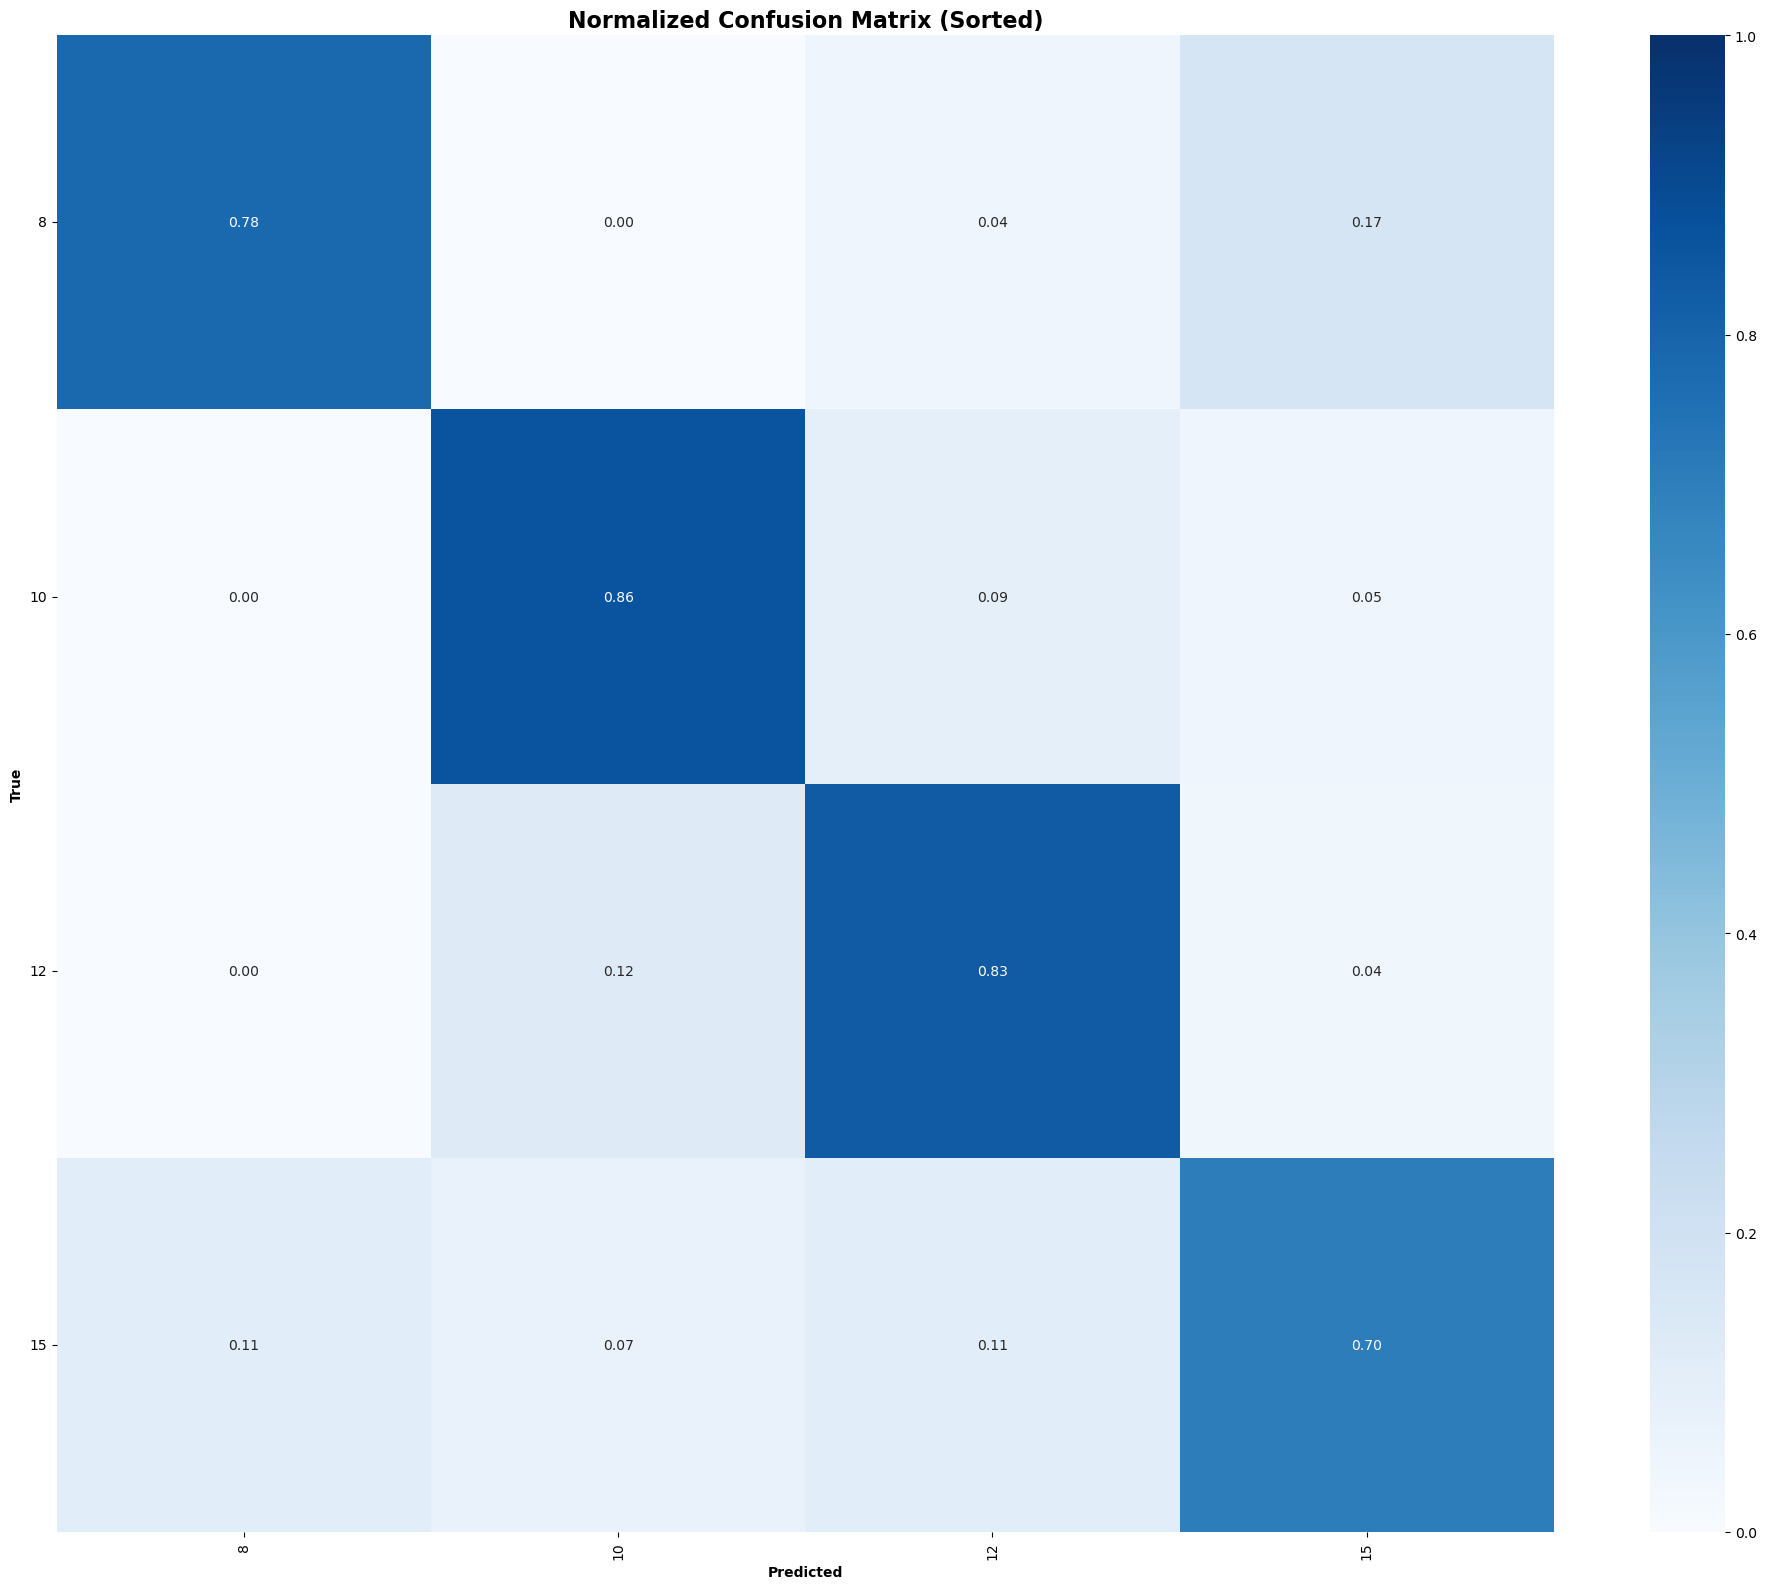

Test set Accuracy: 0.7917
Recall: 0.7917
F1 Score: 0.7909
Confusion Matrix:
[[18  0  1  4]
 [ 0 19  2  1]
 [ 0  3 20  1]
 [ 3  2  3 19]]
Running for subject S3 ---------------
Testing on subject 3.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.7500
Epoch 1/50: Train Loss: 1.3235, Train Accuracy: 0.3282, Val Loss: 1.0142, Val Accuracy: 0.7500
Validation loss decreased...
Best model saved with accuracy: 0.7917
Epoch 2/50: Train Loss: 0.7324, Train Accuracy: 0.7348, Val Loss: 0.7855, Val Accuracy: 0.7917
Validation loss decreased...
Best model saved with accuracy: 0.8333
Epoch 3/50: Train Loss: 0.5666, Train Accuracy: 0.7978, Val Loss: 0.6071, Val Accuracy: 0.8333
Validation loss decreased...
Best model saved with accuracy: 0.9167
Epoch 4/50: Train Loss: 0.5241, Train Accuracy: 0.8186, Val Loss: 0.6045, Val Accuracy: 0.9167
Epoch 5/50: Train Loss: 0.4656, Train Accuracy: 0.8412, Val Loss: 0.4983, Val Accuracy: 0.7917
Valida

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

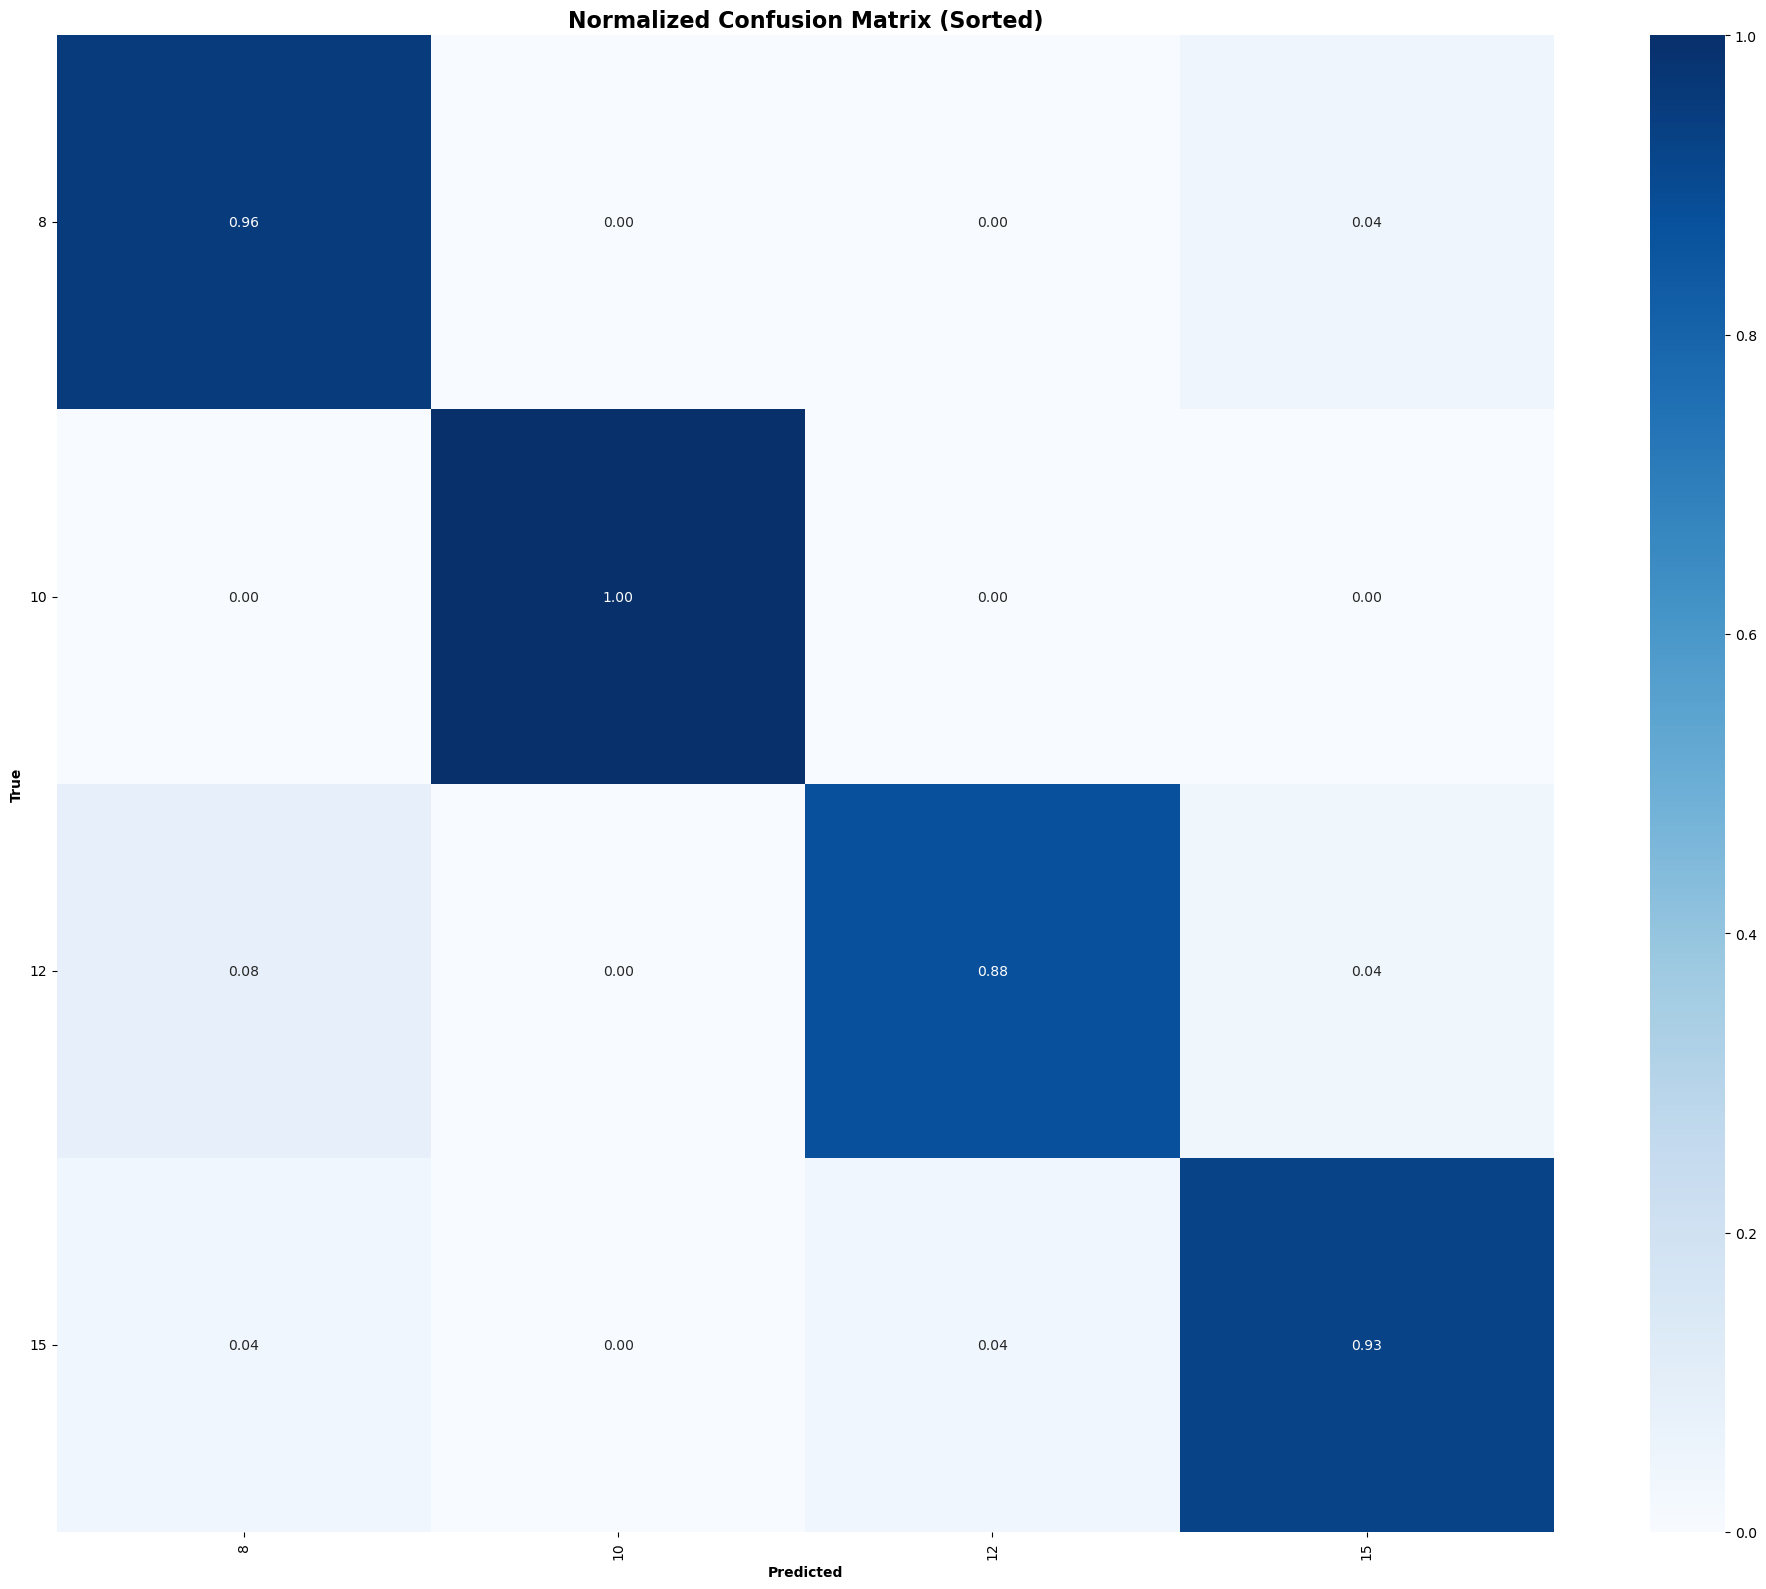

Test set Accuracy: 0.9375
Recall: 0.9375
F1 Score: 0.9375
Confusion Matrix:
[[22  0  0  1]
 [ 0 22  0  0]
 [ 2  0 21  1]
 [ 1  0  1 25]]
Running for subject S4 ---------------
Testing on subject 4.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.5417
Epoch 1/50: Train Loss: 1.3321, Train Accuracy: 0.3343, Val Loss: 1.2002, Val Accuracy: 0.5417
Validation loss decreased...
Best model saved with accuracy: 0.6667
Epoch 2/50: Train Loss: 0.8209, Train Accuracy: 0.6924, Val Loss: 0.9178, Val Accuracy: 0.6667
Validation loss decreased...
Epoch 3/50: Train Loss: 0.5907, Train Accuracy: 0.7941, Val Loss: 0.9030, Val Accuracy: 0.6250
Validation loss decreased...
Epoch 4/50: Train Loss: 0.5082, Train Accuracy: 0.8289, Val Loss: 1.1396, Val Accuracy: 0.5833
Epoch 5/50: Train Loss: 0.4929, Train Accuracy: 0.8326, Val Loss: 0.8592, Val Accuracy: 0.6667
Validation loss decreased...
Best model saved with accuracy: 0.7083
Epoch 6/50: Trai

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

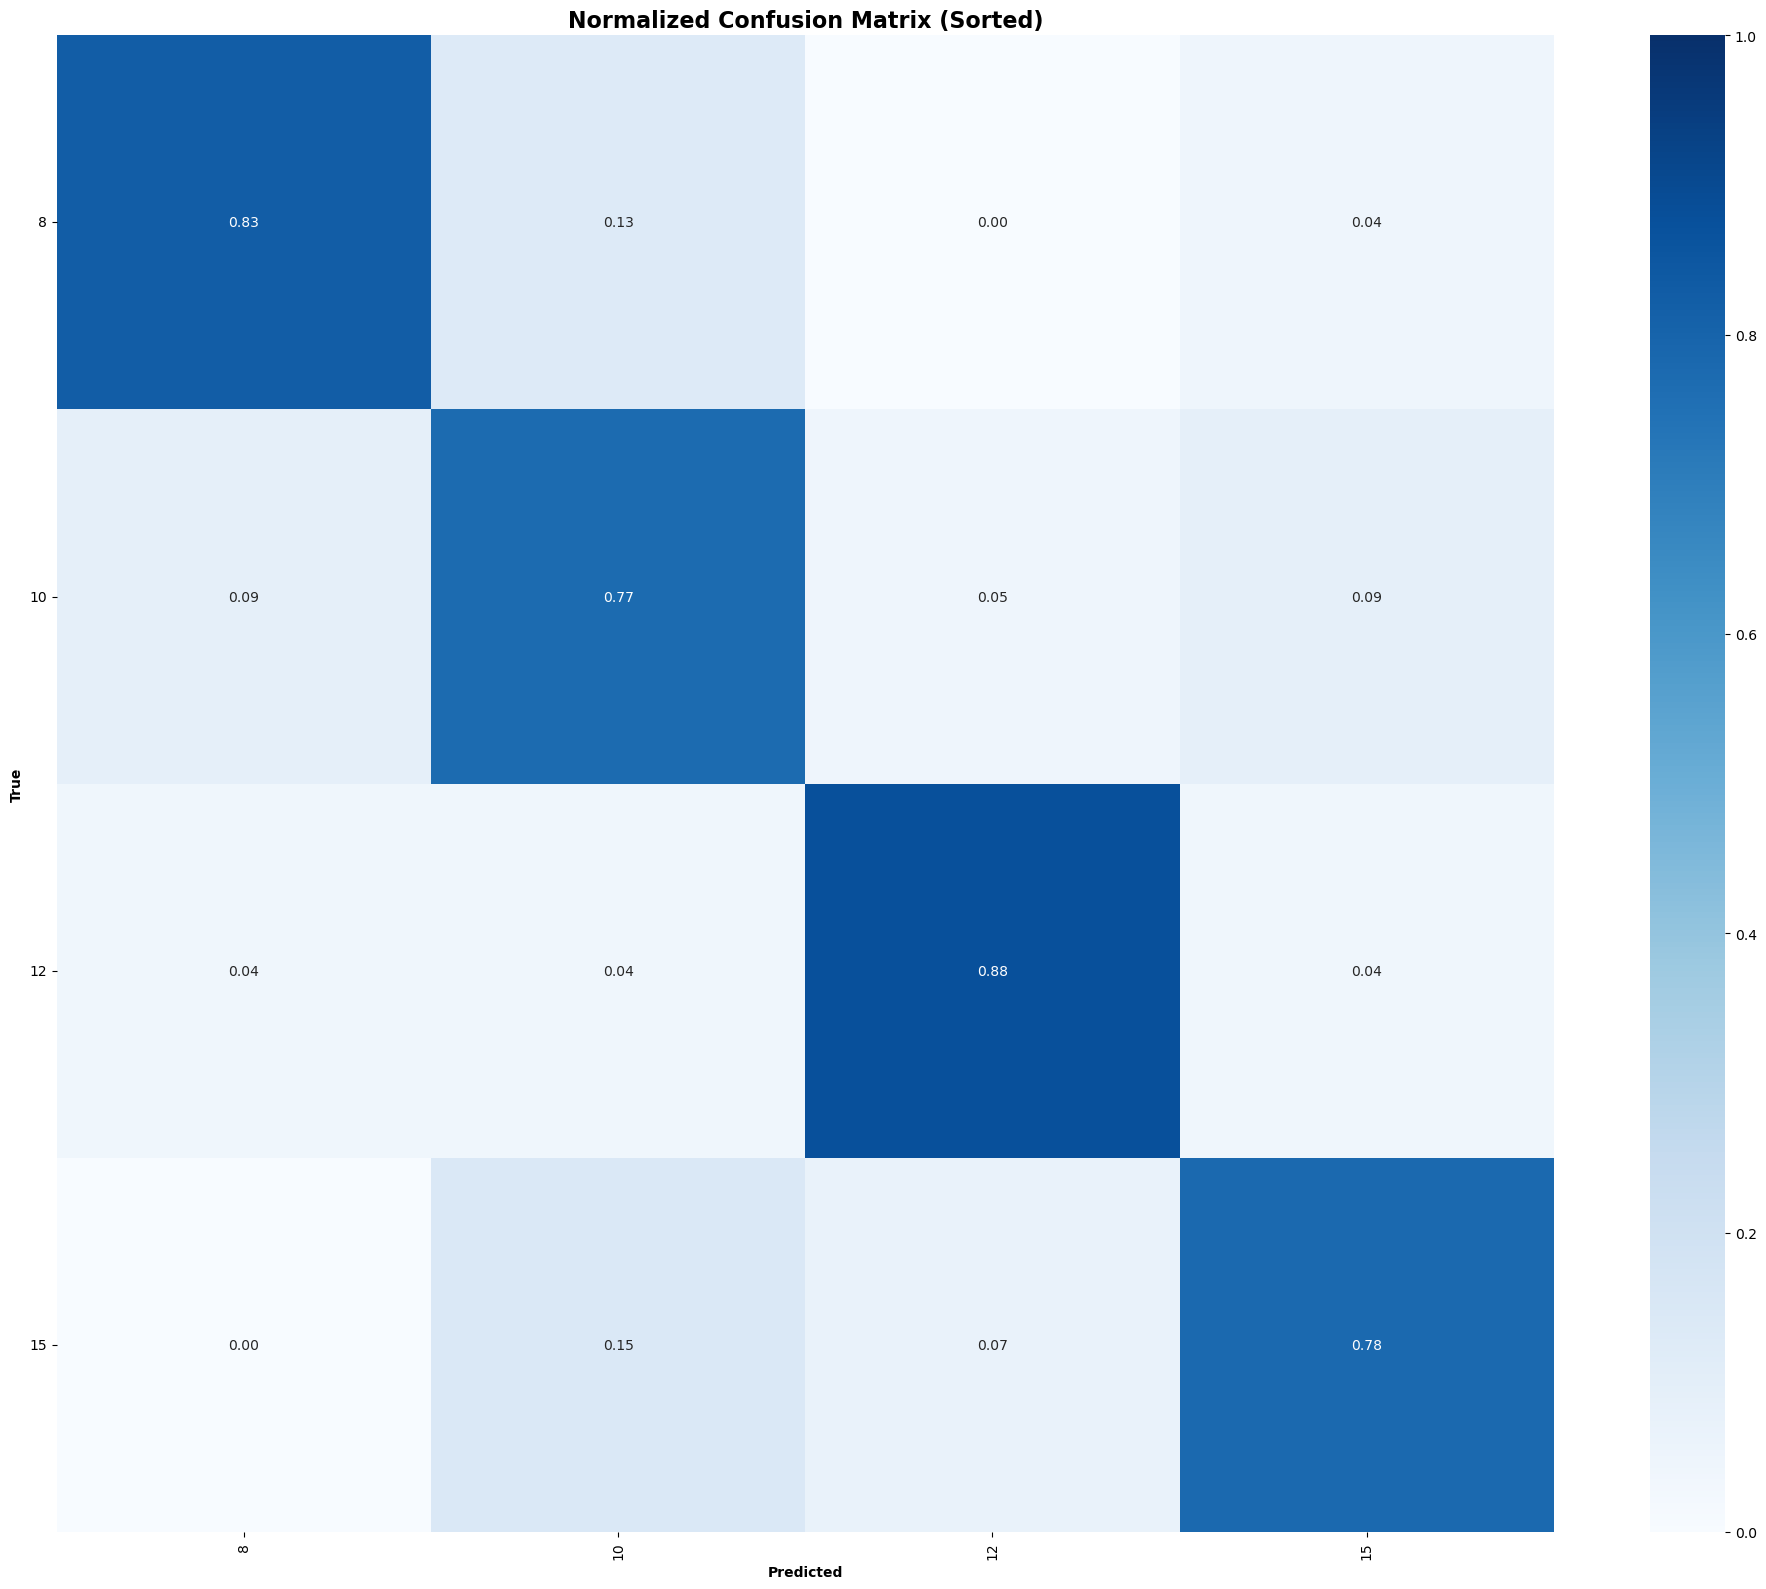

Test set Accuracy: 0.8125
Recall: 0.8125
F1 Score: 0.8140
Confusion Matrix:
[[19  3  0  1]
 [ 2 17  1  2]
 [ 1  1 21  1]
 [ 0  4  2 21]]
Running for subject S5 ---------------
Testing on subject 5.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.6667
Epoch 1/50: Train Loss: 1.1585, Train Accuracy: 0.4814, Val Loss: 0.8955, Val Accuracy: 0.6667
Validation loss decreased...
Best model saved with accuracy: 0.7083
Epoch 2/50: Train Loss: 0.6352, Train Accuracy: 0.7725, Val Loss: 0.6659, Val Accuracy: 0.7083
Validation loss decreased...
Best model saved with accuracy: 0.7917
Epoch 3/50: Train Loss: 0.5606, Train Accuracy: 0.7985, Val Loss: 0.6419, Val Accuracy: 0.7917
Validation loss decreased...
Epoch 4/50: Train Loss: 0.4813, Train Accuracy: 0.8346, Val Loss: 0.7252, Val Accuracy: 0.6250
Epoch 5/50: Train Loss: 0.4724, Train Accuracy: 0.8360, Val Loss: 0.6482, Val Accuracy: 0.7917
Epoch 6/50: Train Loss: 0.4510, Train Accurac

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

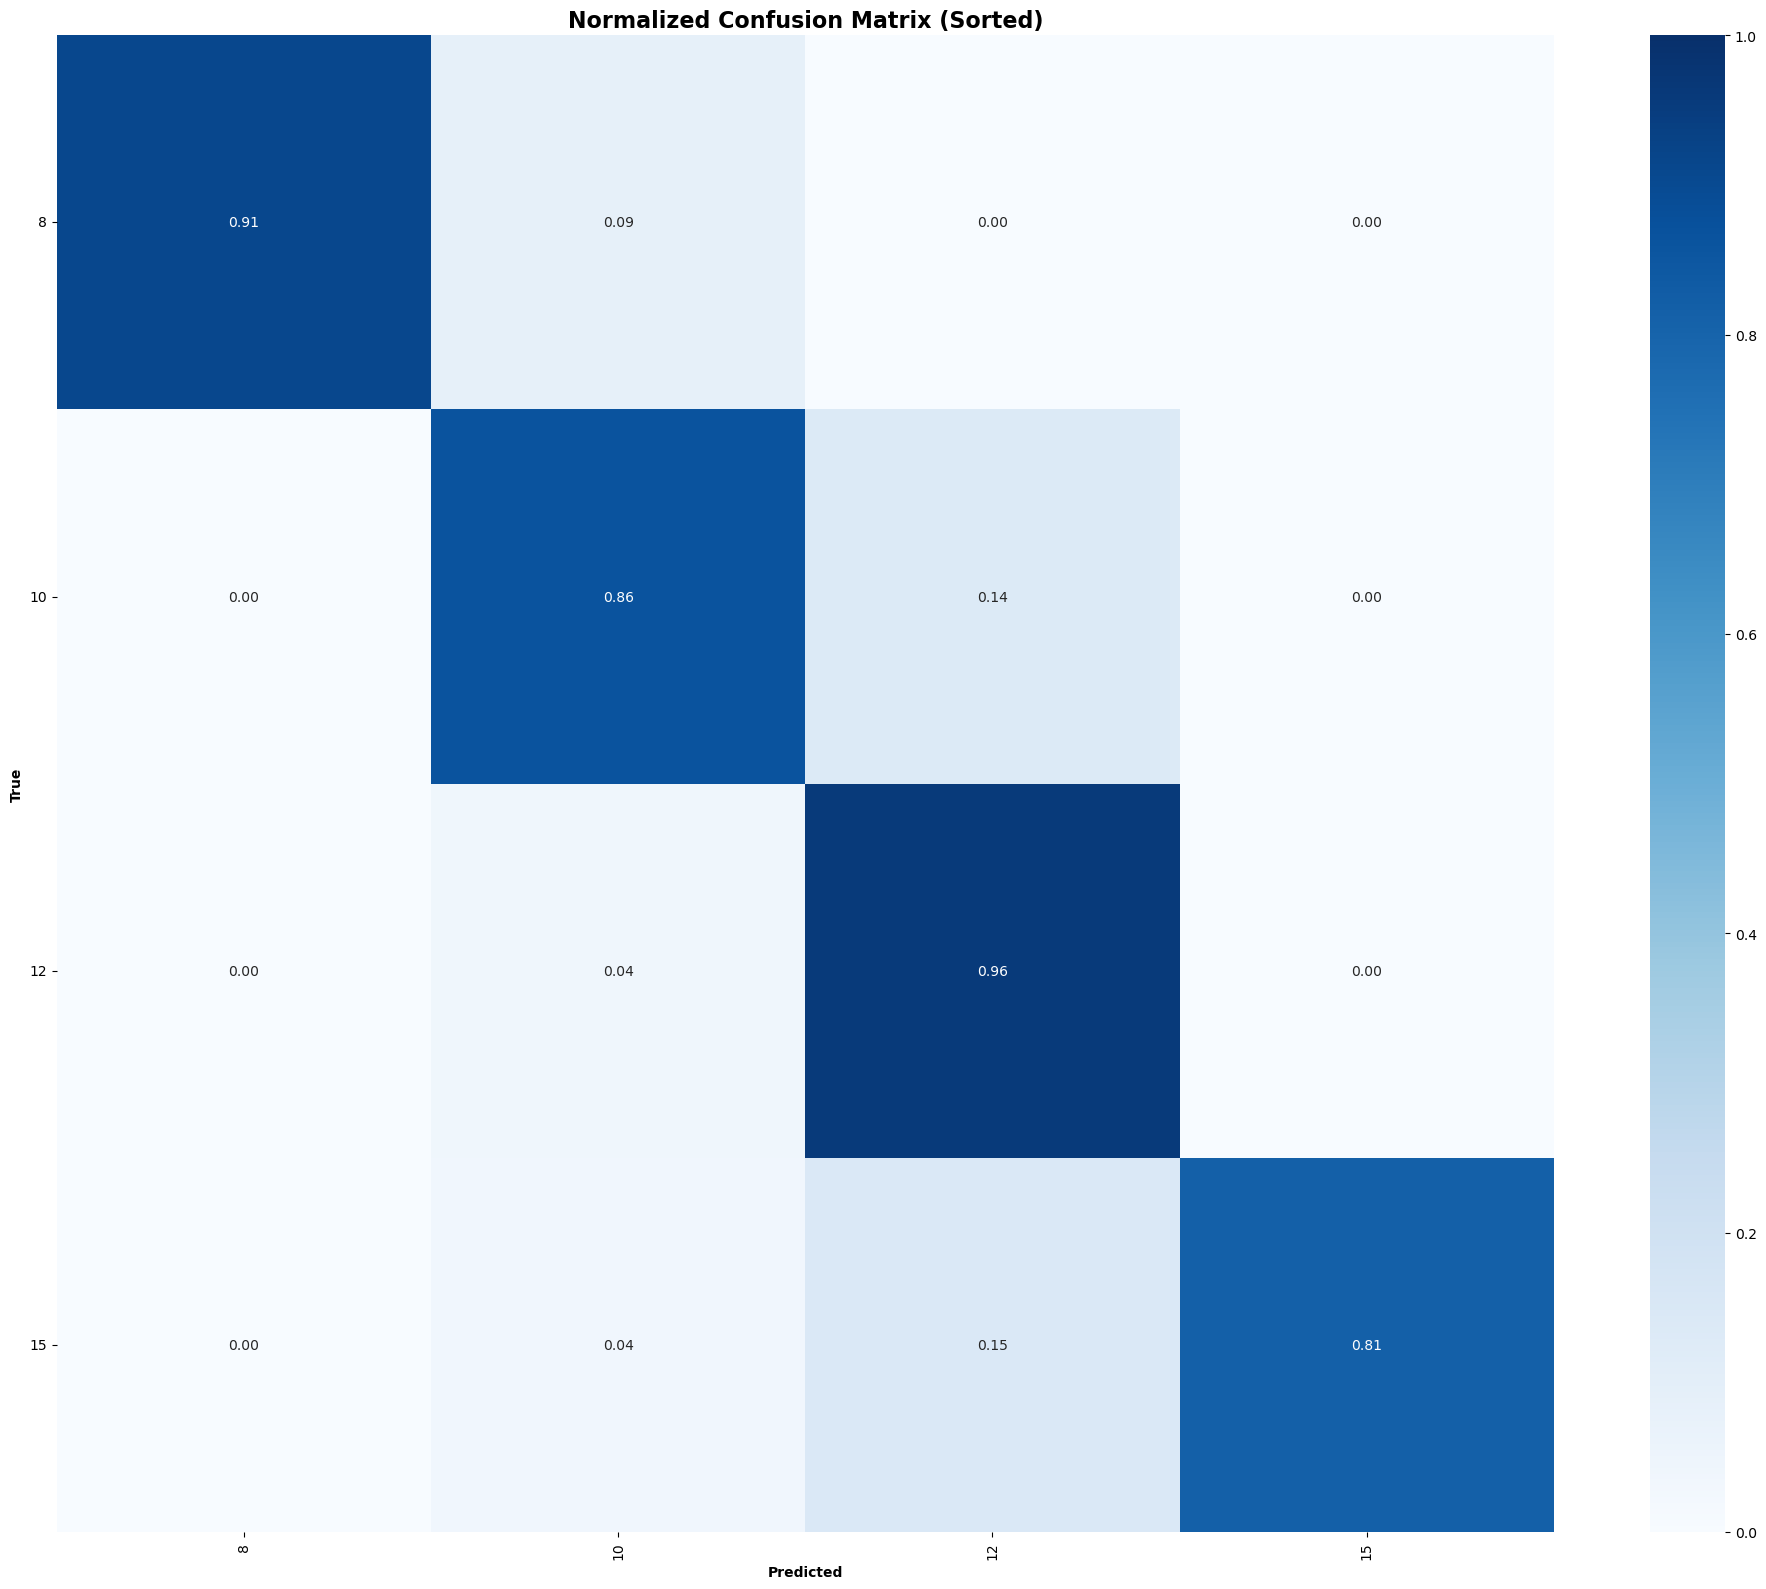

Test set Accuracy: 0.8854
Recall: 0.8854
F1 Score: 0.8877
Confusion Matrix:
[[21  2  0  0]
 [ 0 19  3  0]
 [ 0  1 23  0]
 [ 0  1  4 22]]
Running for subject S6 ---------------
Testing on subject 6.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.8750
Epoch 1/50: Train Loss: 1.1906, Train Accuracy: 0.4431, Val Loss: 0.5022, Val Accuracy: 0.8750
Validation loss decreased...
Epoch 2/50: Train Loss: 0.7321, Train Accuracy: 0.7277, Val Loss: 0.3519, Val Accuracy: 0.8750
Validation loss decreased...
Epoch 3/50: Train Loss: 0.5547, Train Accuracy: 0.8010, Val Loss: 0.4084, Val Accuracy: 0.8750
Best model saved with accuracy: 0.9167
Epoch 4/50: Train Loss: 0.5380, Train Accuracy: 0.8130, Val Loss: 0.2927, Val Accuracy: 0.9167
Validation loss decreased...
Epoch 5/50: Train Loss: 0.4664, Train Accuracy: 0.8360, Val Loss: 0.3265, Val Accuracy: 0.8750
Epoch 6/50: Train Loss: 0.4546, Train Accuracy: 0.8419, Val Loss: 0.2880, Val Accura

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

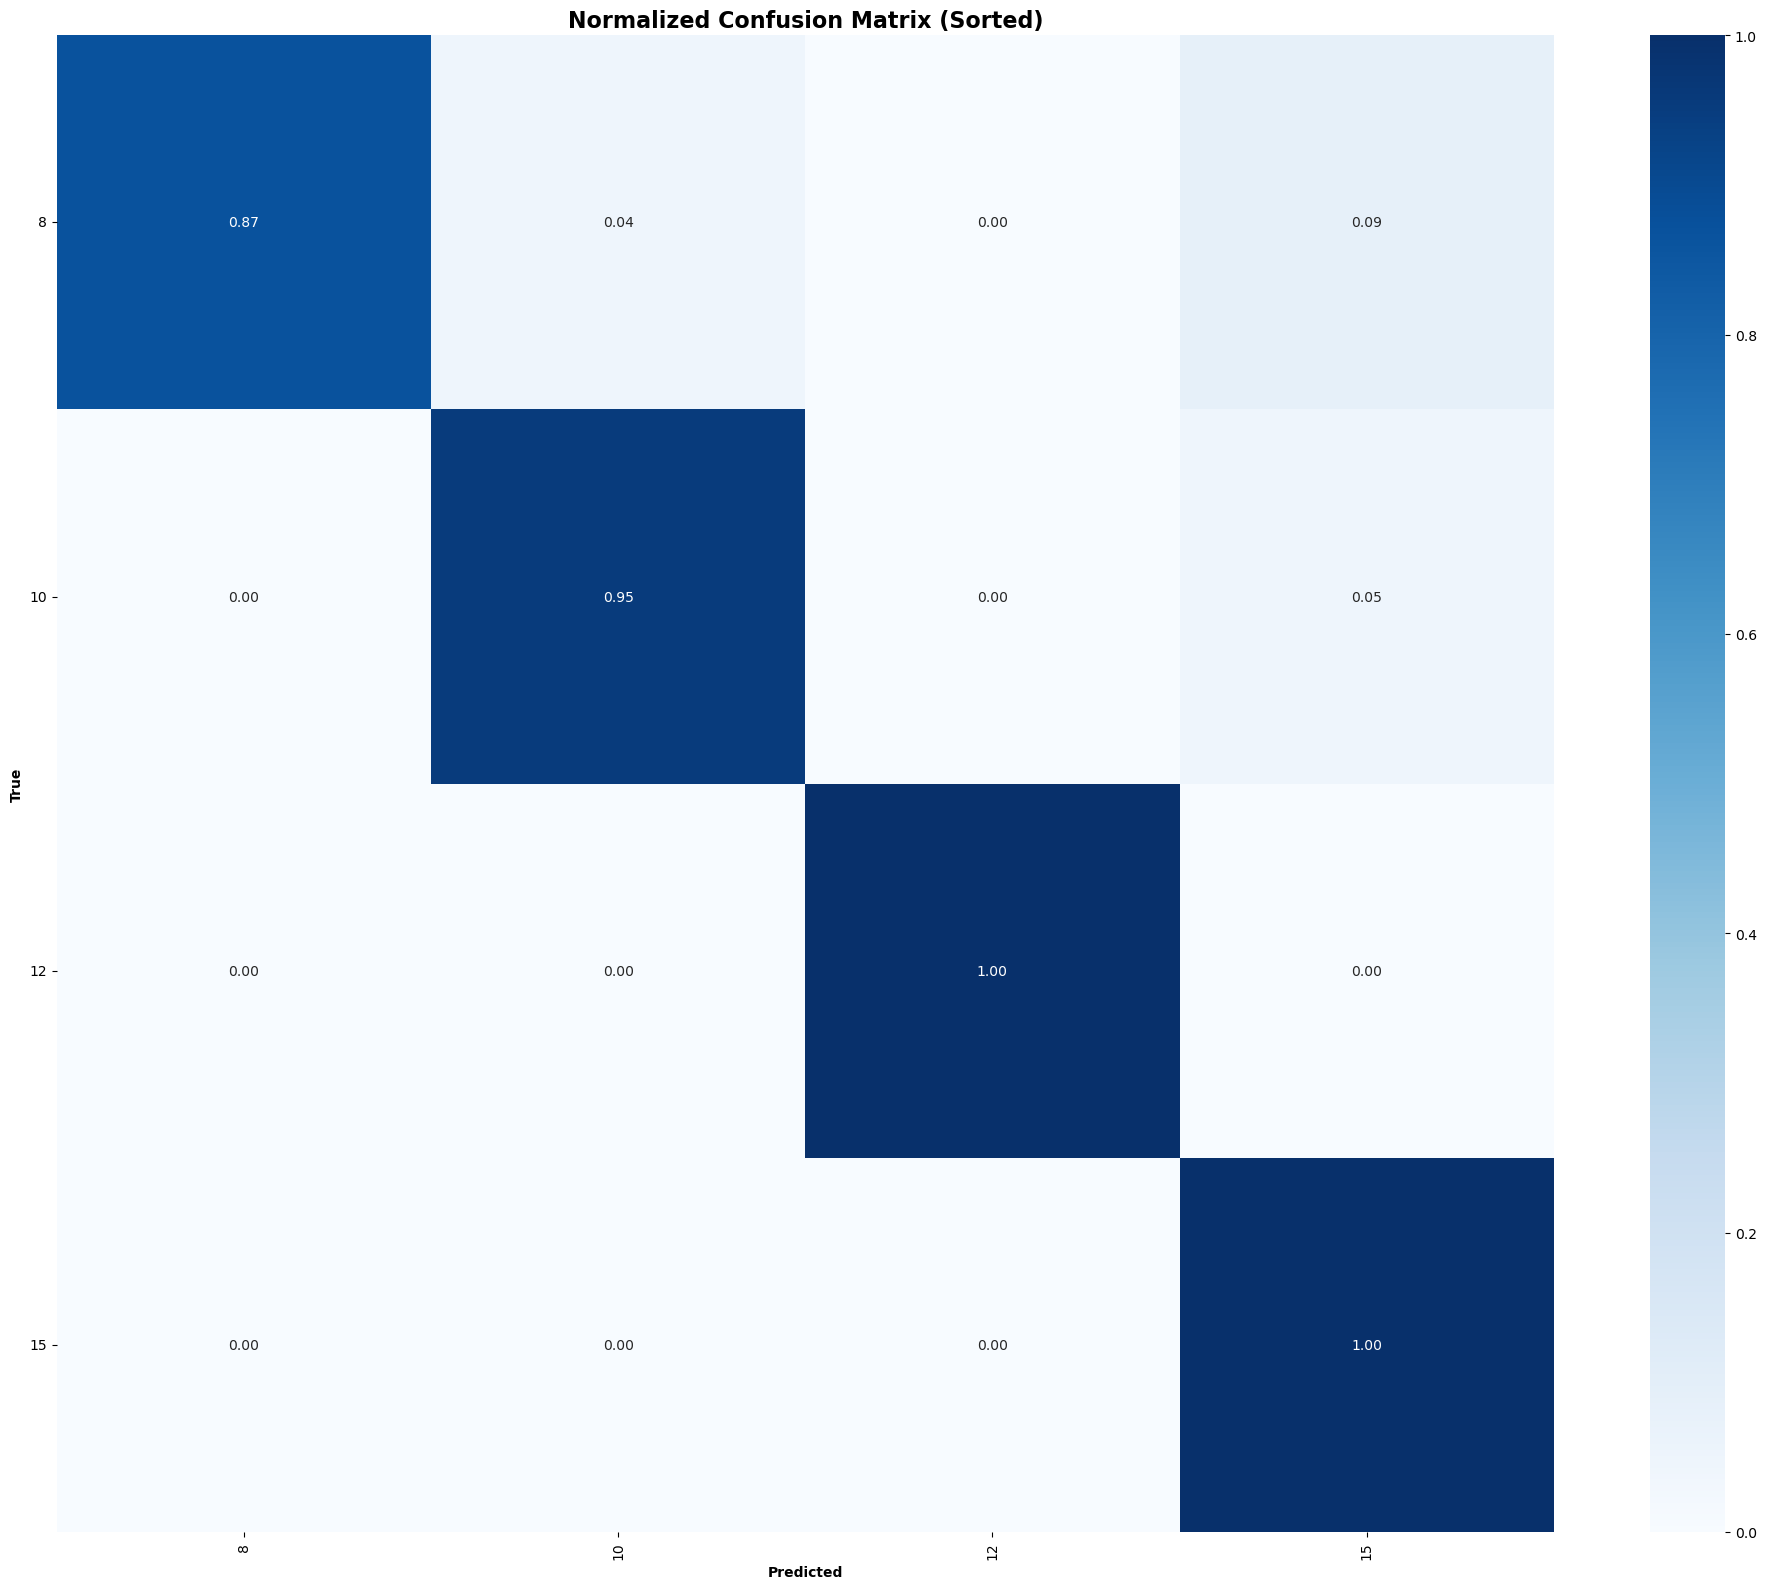

Test set Accuracy: 0.9583
Recall: 0.9583
F1 Score: 0.9581
Confusion Matrix:
[[20  1  0  2]
 [ 0 21  0  1]
 [ 0  0 24  0]
 [ 0  0  0 27]]
Running for subject S7 ---------------
Testing on subject 7.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.5833
Epoch 1/50: Train Loss: 1.1829, Train Accuracy: 0.4542, Val Loss: 1.0568, Val Accuracy: 0.5833
Validation loss decreased...
Best model saved with accuracy: 0.7917
Epoch 2/50: Train Loss: 0.7225, Train Accuracy: 0.7414, Val Loss: 0.7292, Val Accuracy: 0.7917
Validation loss decreased...
Epoch 3/50: Train Loss: 0.5579, Train Accuracy: 0.8047, Val Loss: 0.7009, Val Accuracy: 0.7917
Validation loss decreased...
Best model saved with accuracy: 0.8750
Epoch 4/50: Train Loss: 0.4936, Train Accuracy: 0.8255, Val Loss: 0.5970, Val Accuracy: 0.8750
Validation loss decreased...
Epoch 5/50: Train Loss: 0.4868, Train Accuracy: 0.8309, Val Loss: 0.5945, Val Accuracy: 0.7500
Epoch 6/50: Trai

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

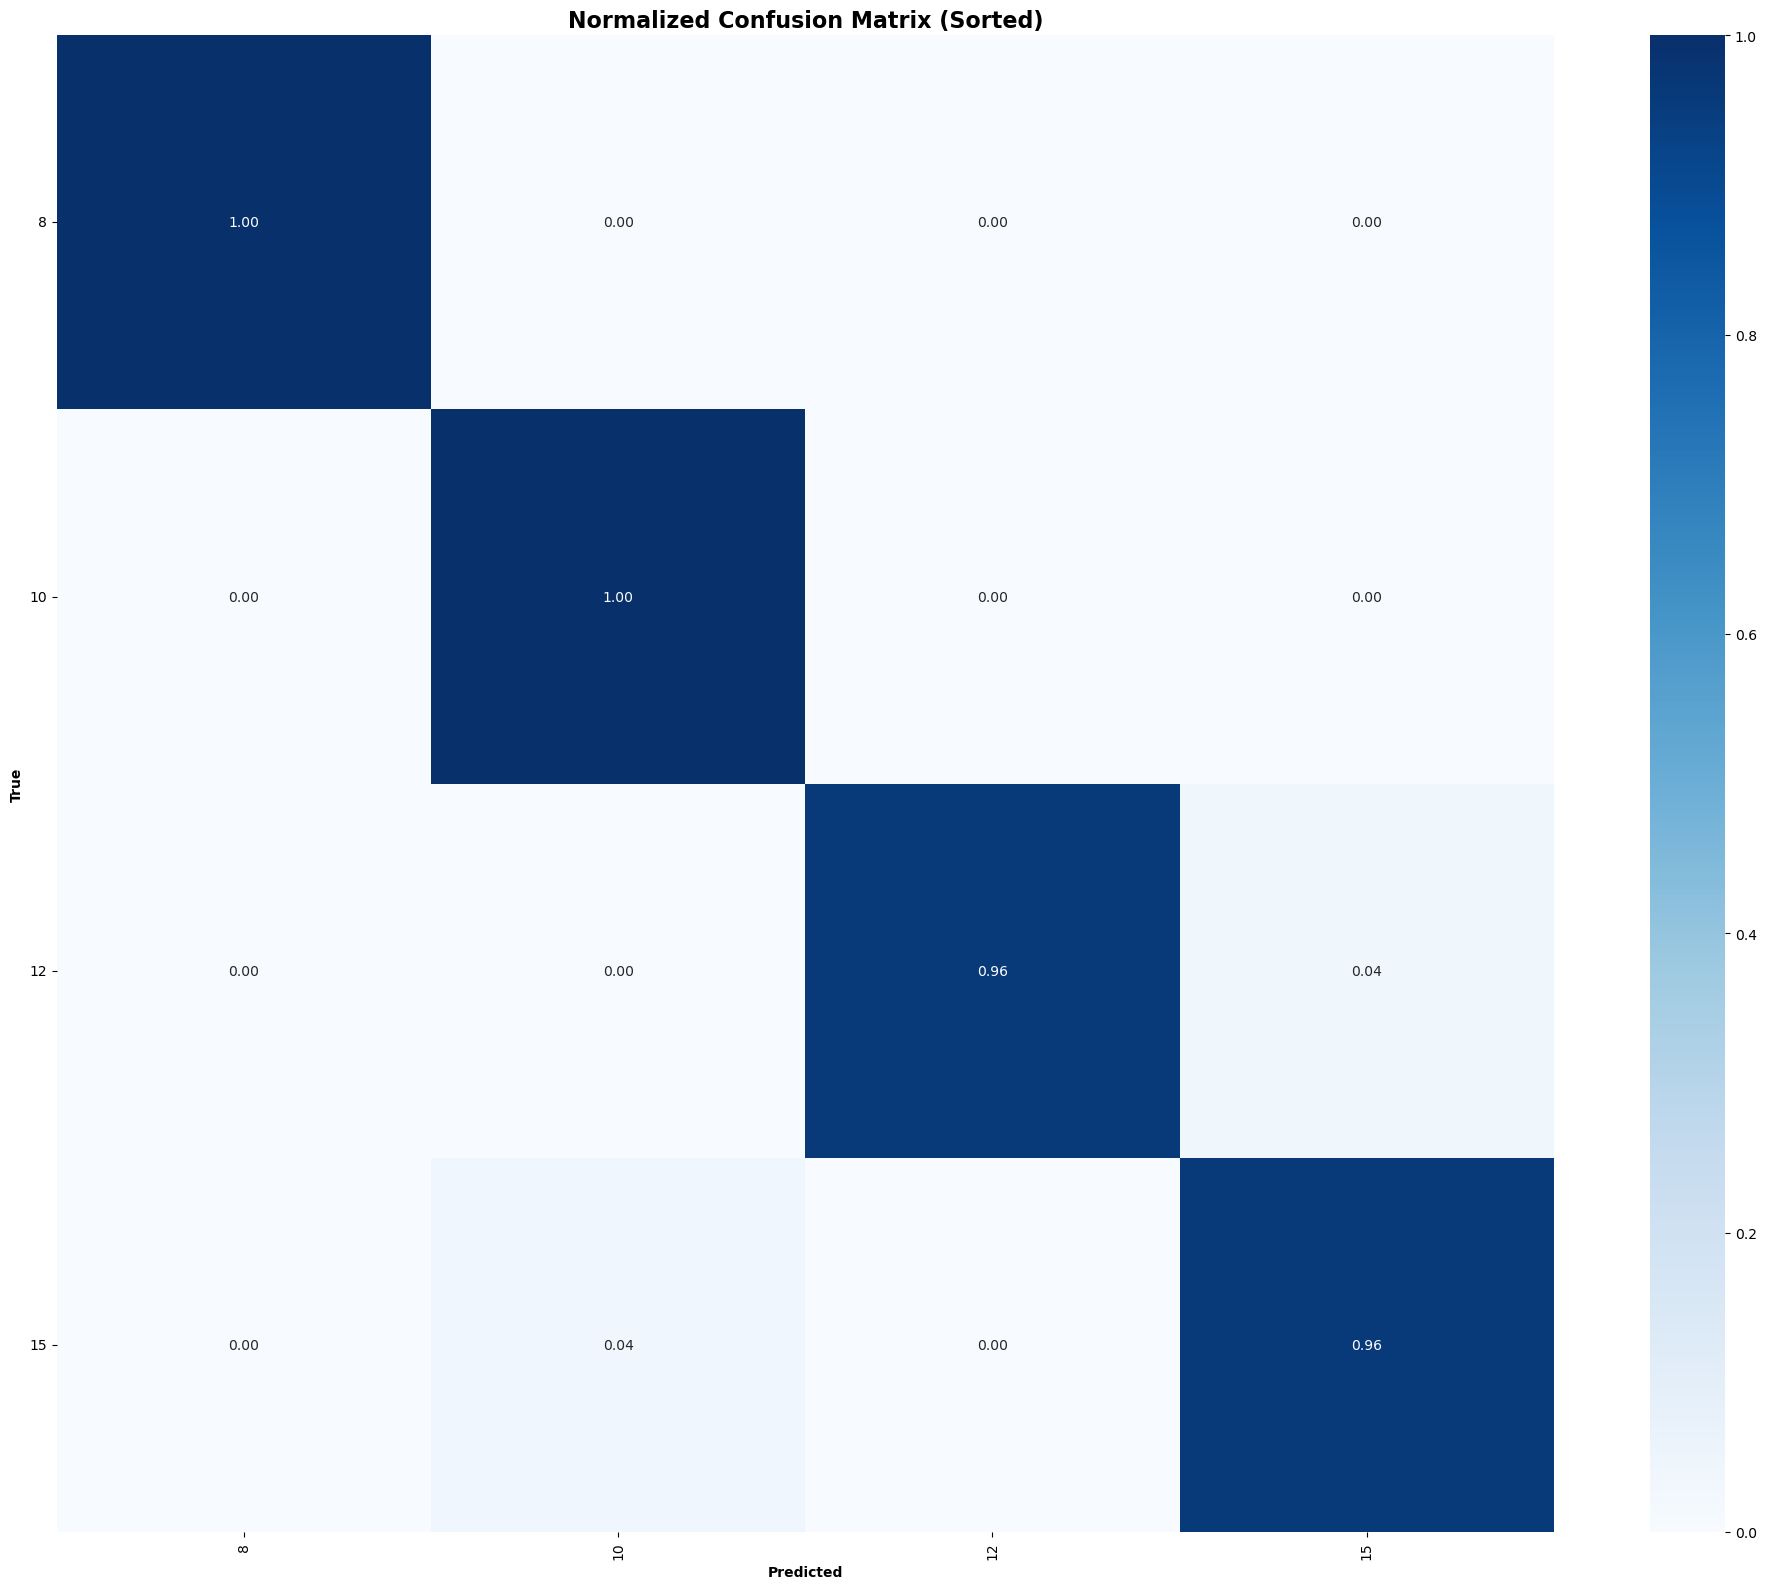

Test set Accuracy: 0.9792
Recall: 0.9792
F1 Score: 0.9792
Confusion Matrix:
[[23  0  0  0]
 [ 0 22  0  0]
 [ 0  0 23  1]
 [ 0  1  0 26]]
Running for subject S8 ---------------
Testing on subject 8.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.6667
Epoch 1/50: Train Loss: 1.2475, Train Accuracy: 0.4007, Val Loss: 0.6896, Val Accuracy: 0.6667
Validation loss decreased...
Best model saved with accuracy: 0.9167
Epoch 2/50: Train Loss: 0.7515, Train Accuracy: 0.7162, Val Loss: 0.4186, Val Accuracy: 0.9167
Validation loss decreased...
Epoch 3/50: Train Loss: 0.5698, Train Accuracy: 0.8093, Val Loss: 0.4185, Val Accuracy: 0.7917
Epoch 4/50: Train Loss: 0.5166, Train Accuracy: 0.8169, Val Loss: 0.4244, Val Accuracy: 0.7917
Epoch 5/50: Train Loss: 0.4743, Train Accuracy: 0.8355, Val Loss: 0.3717, Val Accuracy: 0.7917
Validation loss decreased...
Epoch 6/50: Train Loss: 0.4914, Train Accuracy: 0.8309, Val Loss: 0.3636, Val Accura

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

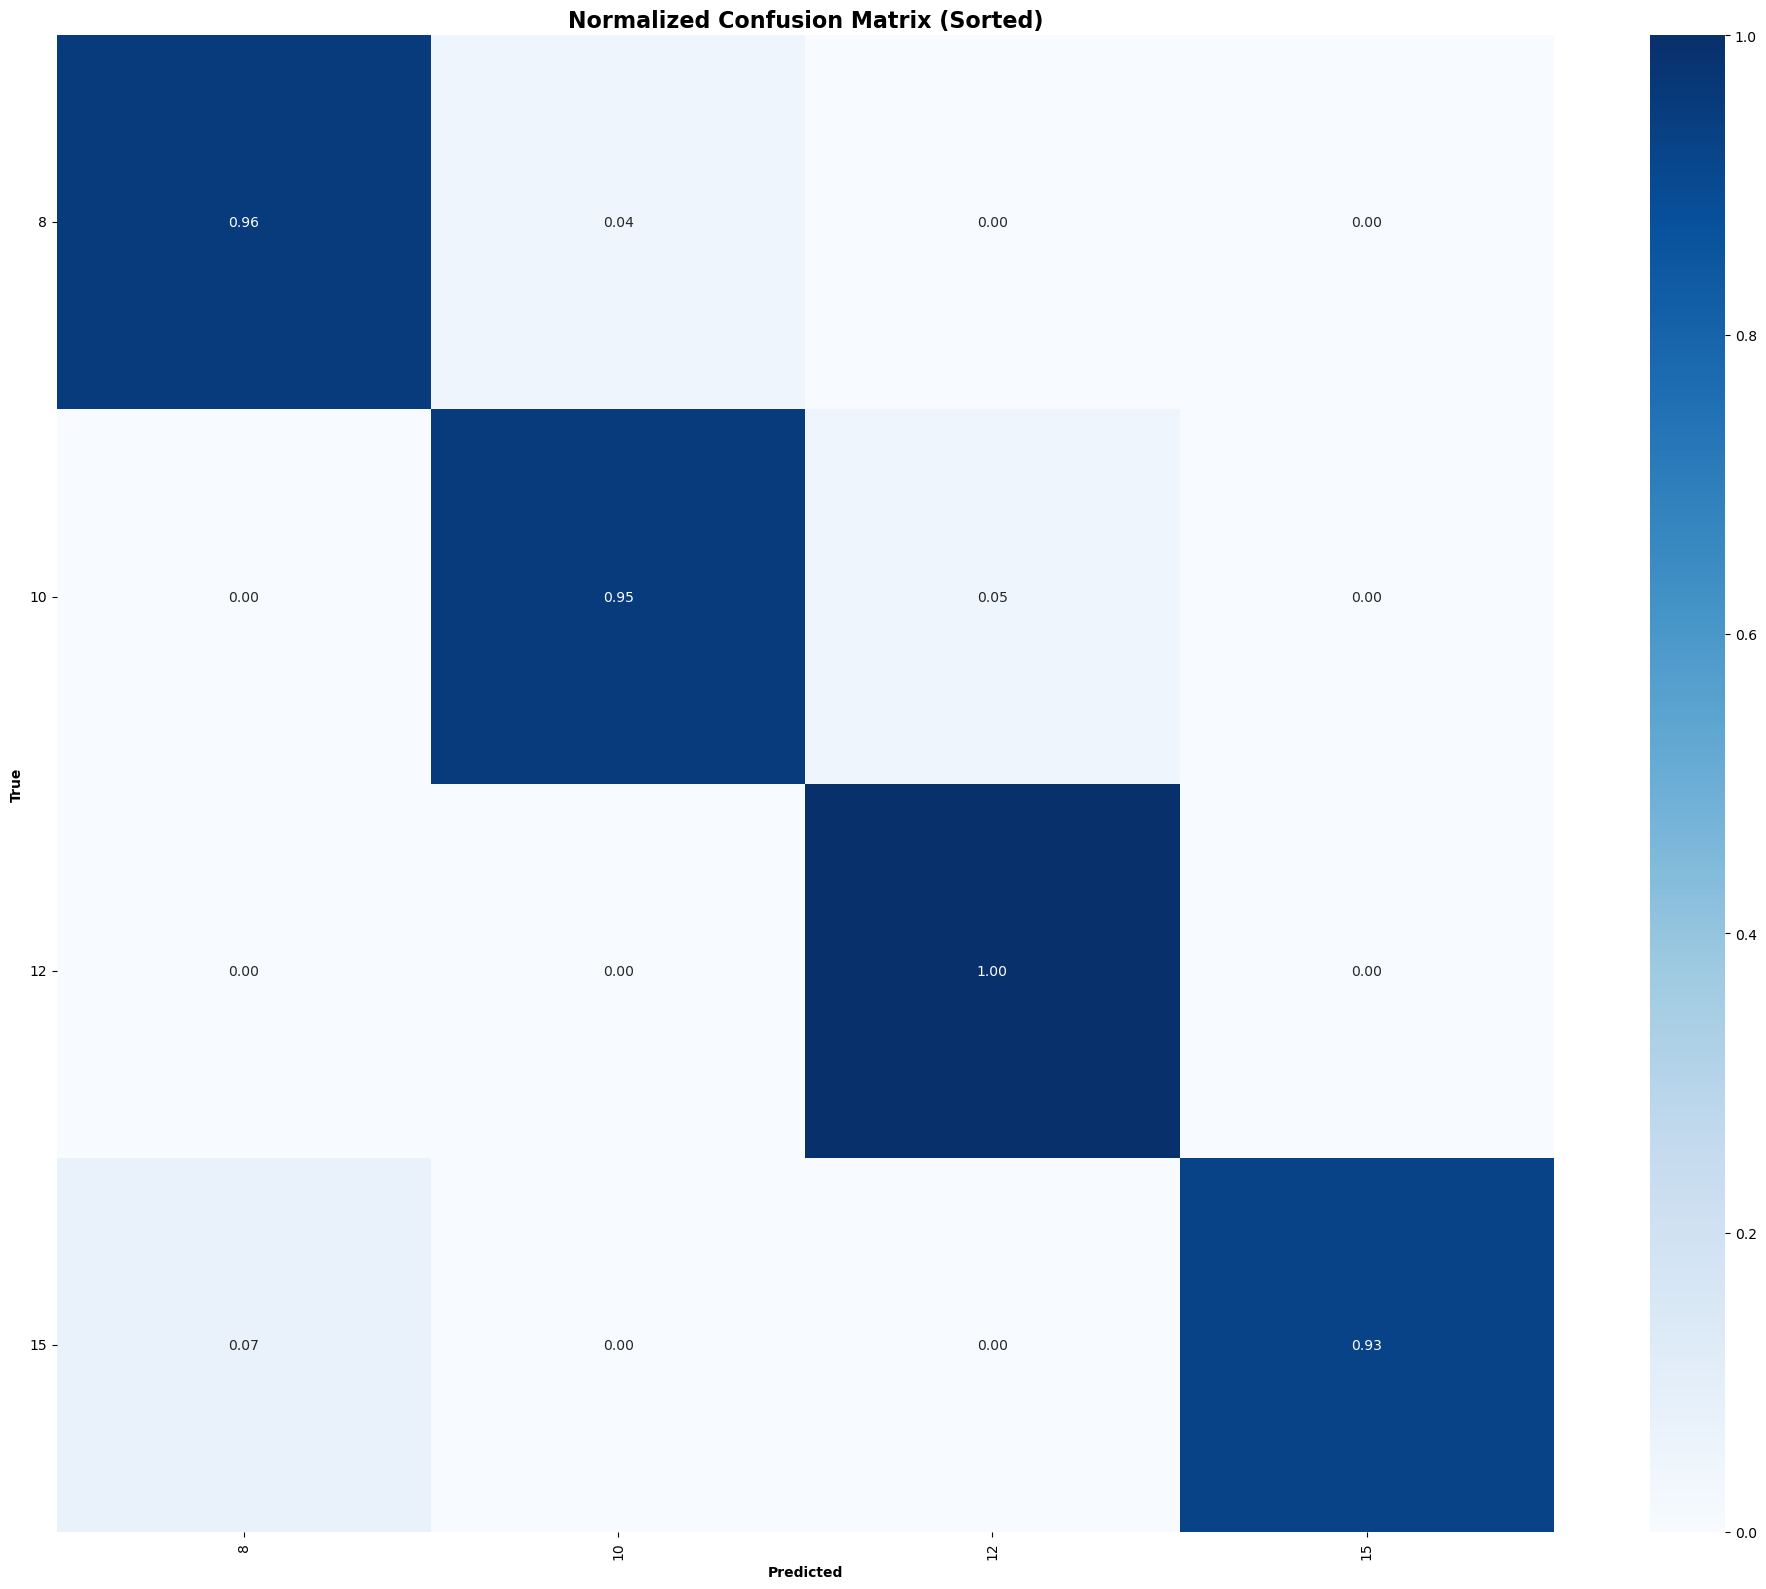

Test set Accuracy: 0.9583
Recall: 0.9583
F1 Score: 0.9584
Confusion Matrix:
[[22  1  0  0]
 [ 0 21  1  0]
 [ 0  0 24  0]
 [ 2  0  0 25]]
Running for subject S9 ---------------
Testing on subject 9.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.5000
Epoch 1/50: Train Loss: 1.1643, Train Accuracy: 0.4630, Val Loss: 1.2997, Val Accuracy: 0.5000
Validation loss decreased...
Best model saved with accuracy: 0.6250
Epoch 2/50: Train Loss: 0.7046, Train Accuracy: 0.7547, Val Loss: 0.9982, Val Accuracy: 0.6250
Validation loss decreased...
Epoch 3/50: Train Loss: 0.5438, Train Accuracy: 0.8076, Val Loss: 1.0259, Val Accuracy: 0.5833
Epoch 4/50: Train Loss: 0.4889, Train Accuracy: 0.8314, Val Loss: 0.9485, Val Accuracy: 0.6250
Validation loss decreased...
Epoch 5/50: Train Loss: 0.4500, Train Accuracy: 0.8392, Val Loss: 1.0512, Val Accuracy: 0.6250
Epoch 6/50: Train Loss: 0.4201, Train Accuracy: 0.8525, Val Loss: 1.2580, Val Accura

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

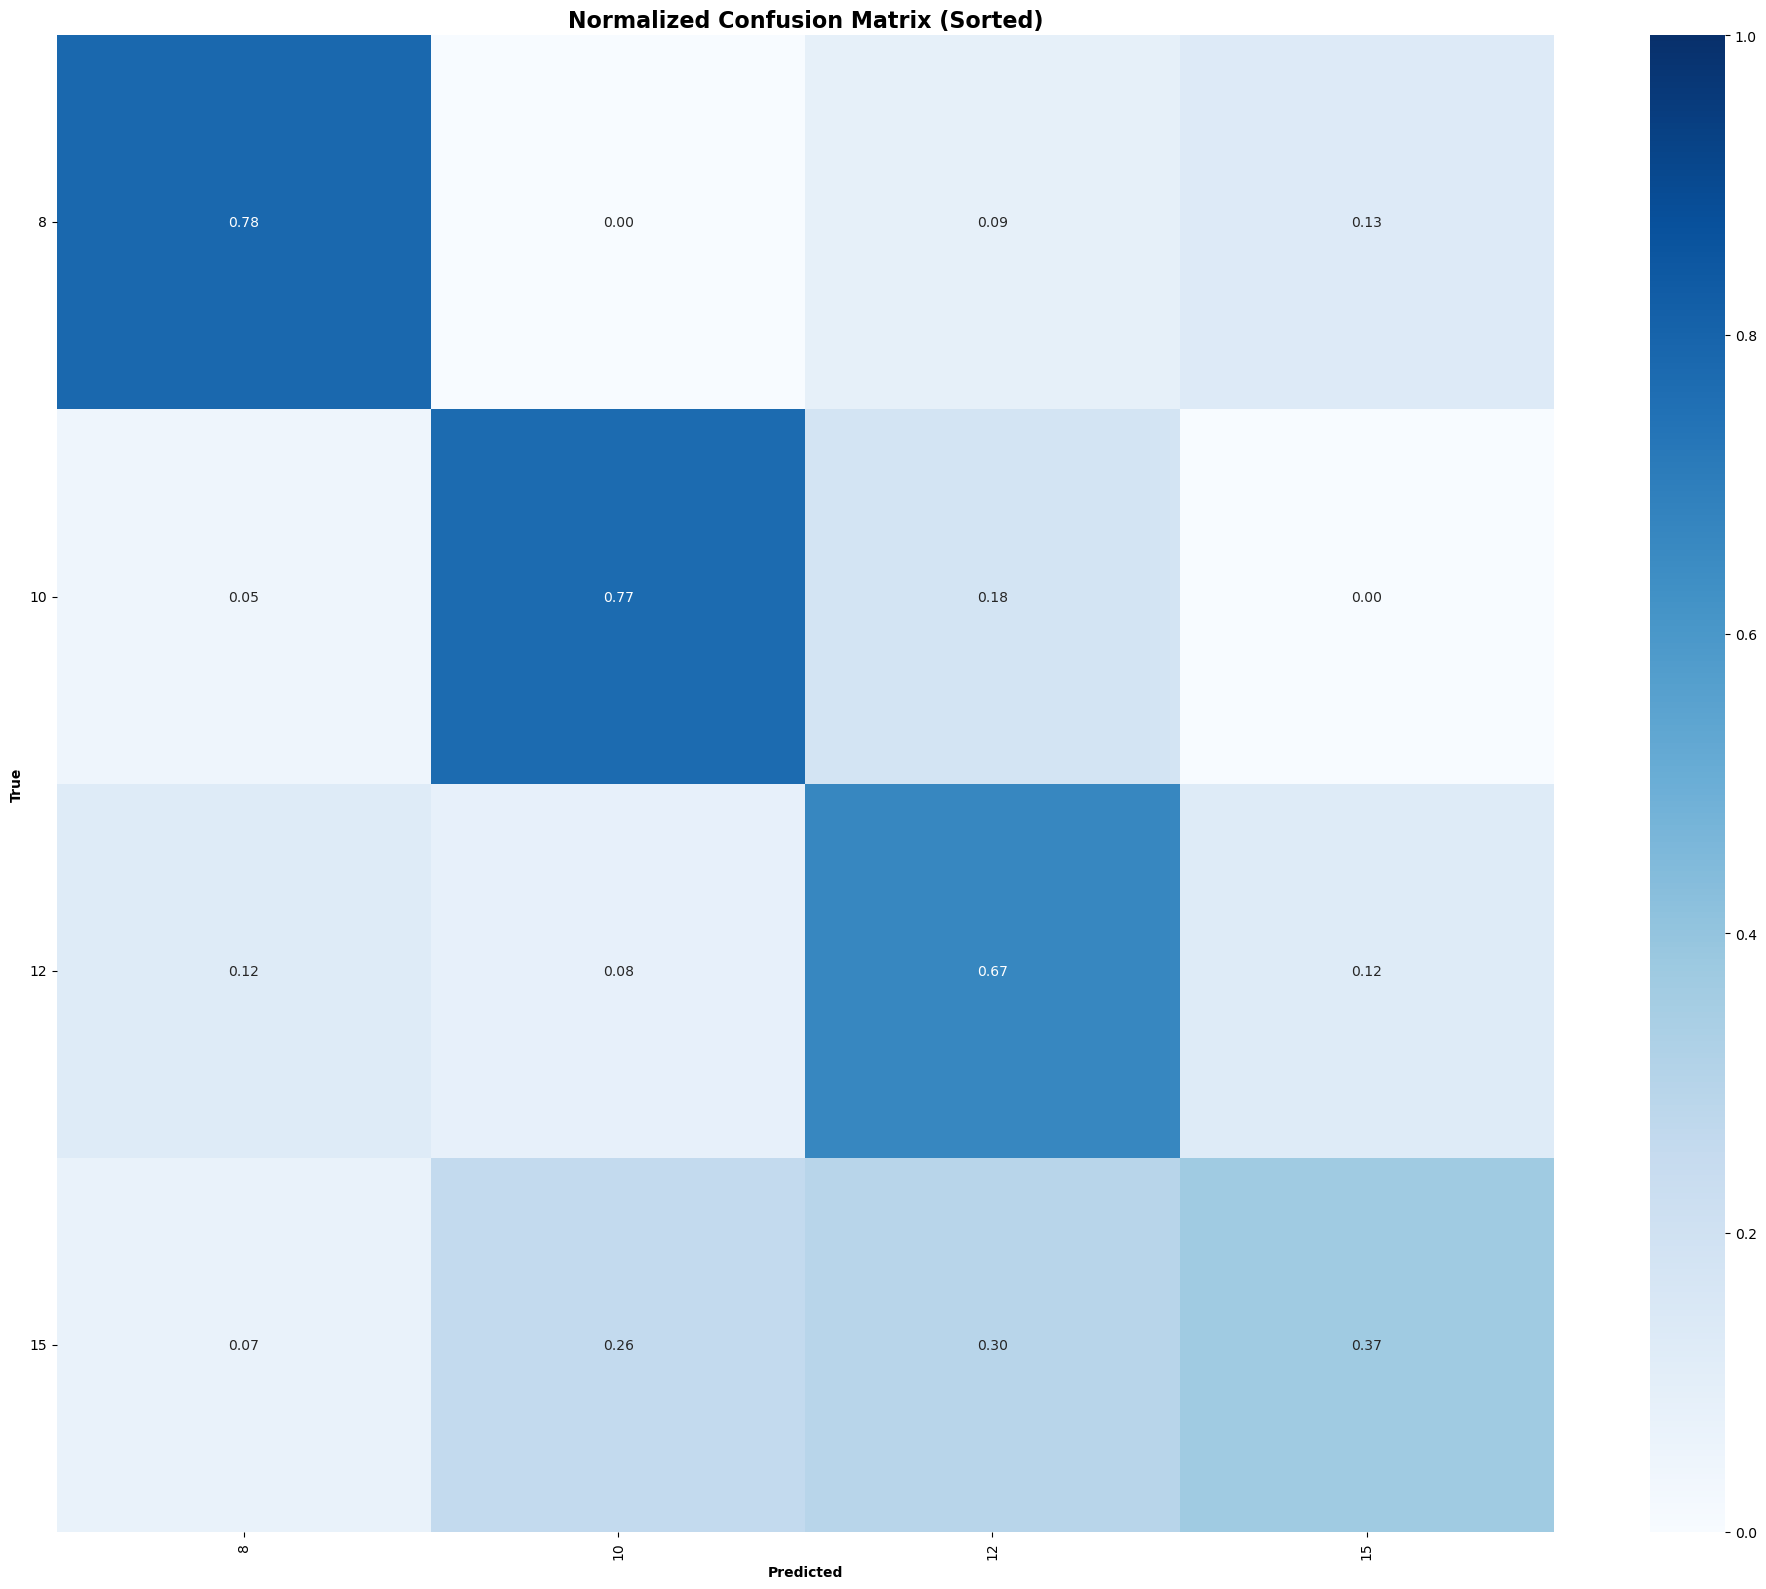

Test set Accuracy: 0.6354
Recall: 0.6354
F1 Score: 0.6248
Confusion Matrix:
[[18  0  2  3]
 [ 1 17  4  0]
 [ 3  2 16  3]
 [ 2  7  8 10]]
Running for subject S10 ---------------
Testing on subject 10.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.8333
Epoch 1/50: Train Loss: 1.2457, Train Accuracy: 0.3850, Val Loss: 0.9481, Val Accuracy: 0.8333
Validation loss decreased...
Best model saved with accuracy: 0.8750
Epoch 2/50: Train Loss: 0.7408, Train Accuracy: 0.7277, Val Loss: 0.8588, Val Accuracy: 0.8750
Validation loss decreased...
Epoch 3/50: Train Loss: 0.5435, Train Accuracy: 0.8123, Val Loss: 0.5809, Val Accuracy: 0.8333
Validation loss decreased...
Best model saved with accuracy: 0.9167
Epoch 4/50: Train Loss: 0.5075, Train Accuracy: 0.8297, Val Loss: 0.4882, Val Accuracy: 0.9167
Validation loss decreased...
Epoch 5/50: Train Loss: 0.4633, Train Accuracy: 0.8380, Val Loss: 0.4295, Val Accuracy: 0.9167
Validation los

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

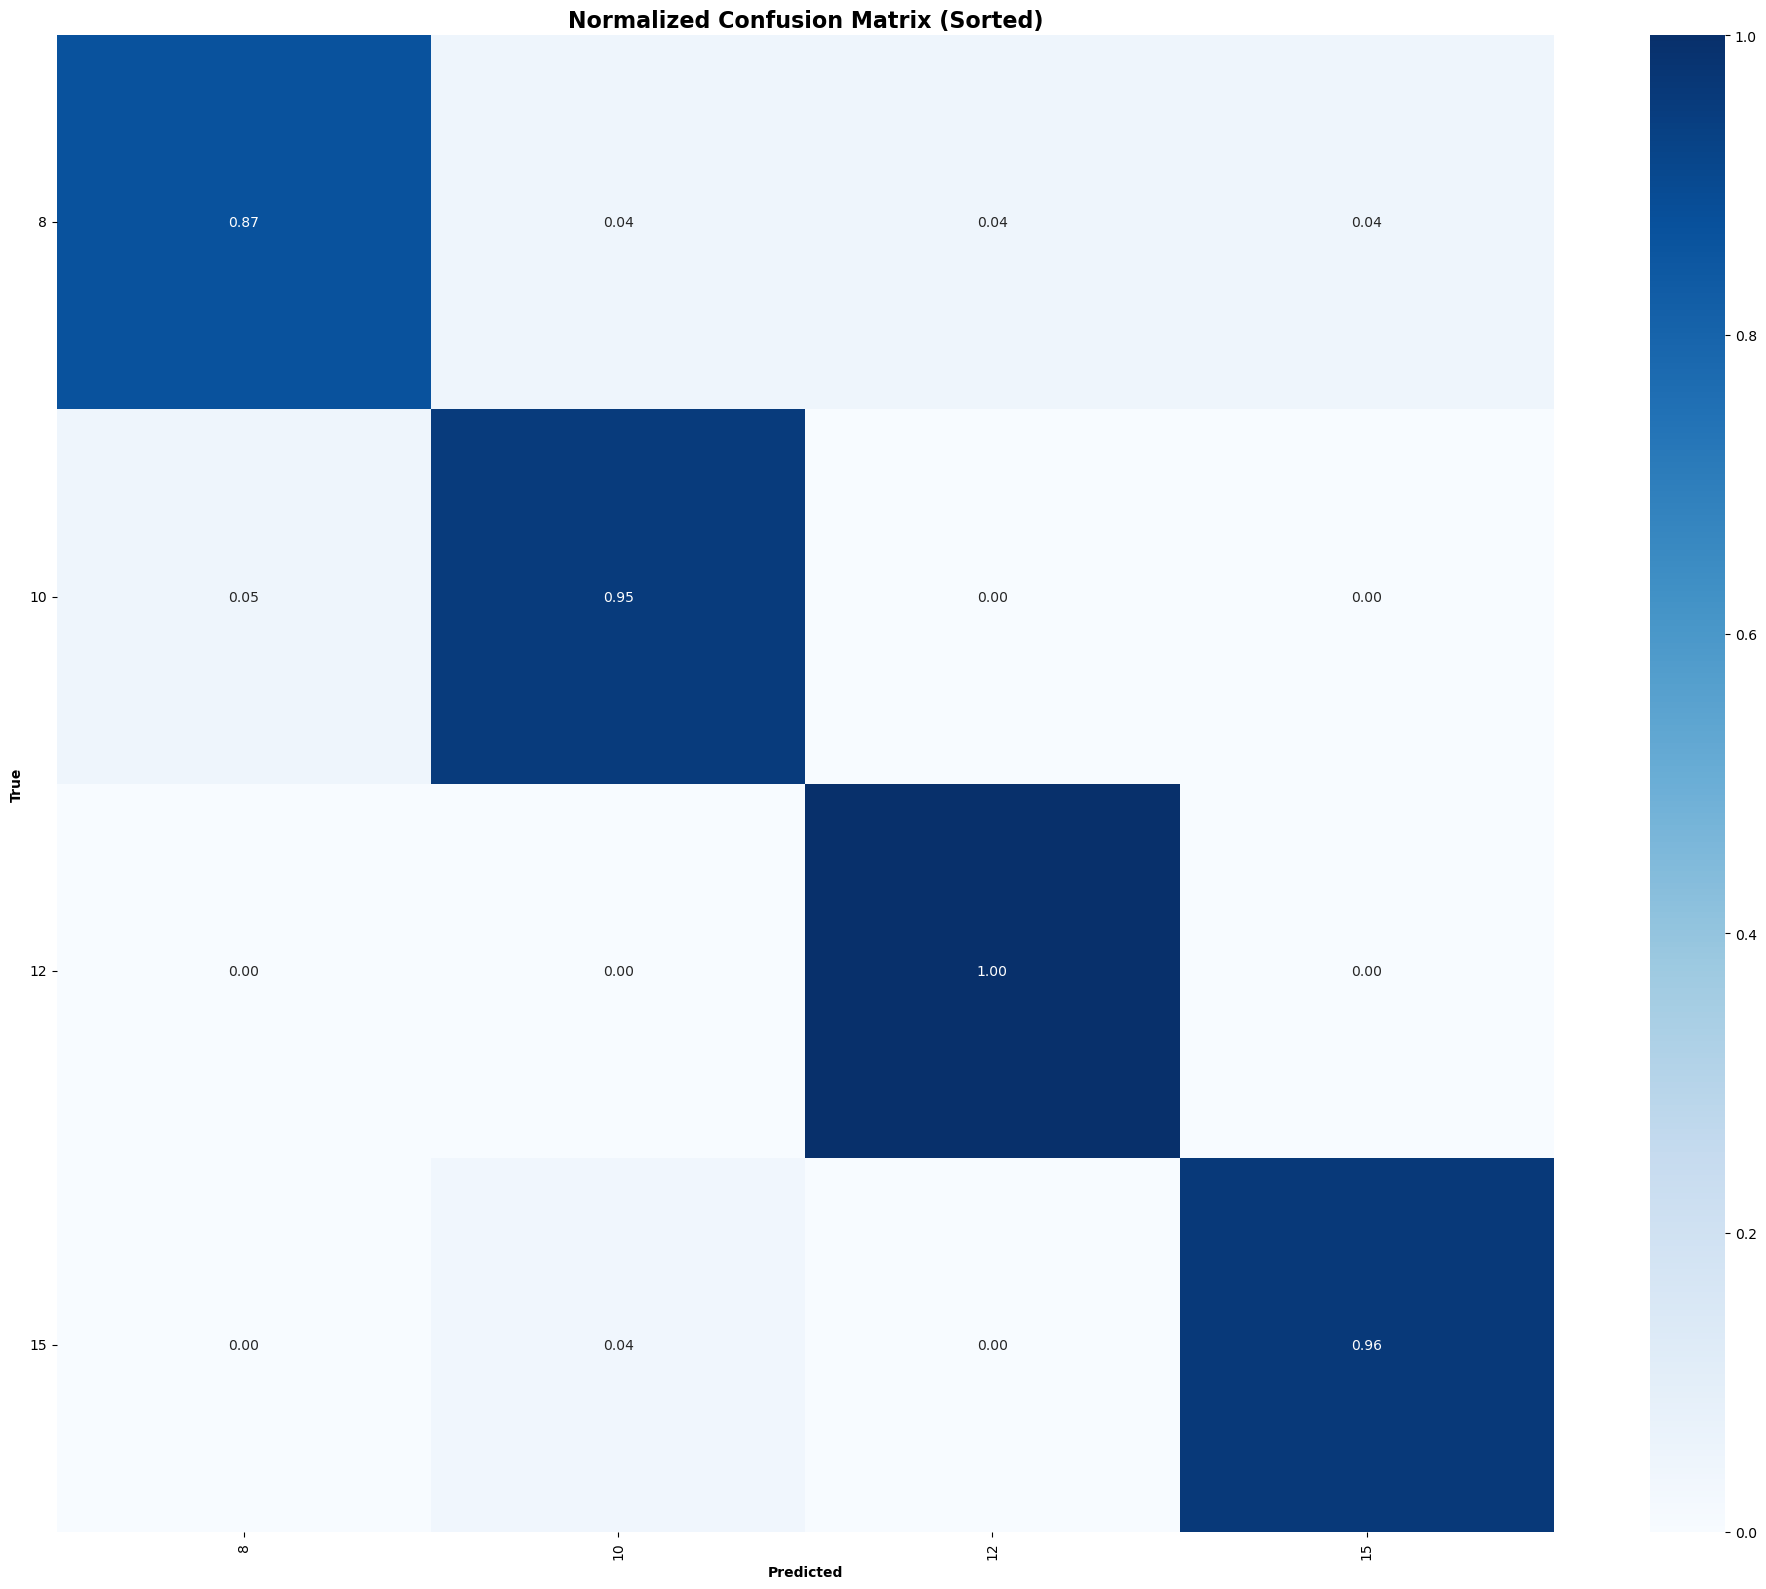

Test set Accuracy: 0.9479
Recall: 0.9479
F1 Score: 0.9474
Confusion Matrix:
[[20  1  1  1]
 [ 1 21  0  0]
 [ 0  0 24  0]
 [ 0  1  0 26]]
Running for subject S11 ---------------
Testing on subject 11.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.7083
Epoch 1/50: Train Loss: 1.1835, Train Accuracy: 0.4422, Val Loss: 1.0868, Val Accuracy: 0.7083
Validation loss decreased...
Epoch 2/50: Train Loss: 0.6490, Train Accuracy: 0.7711, Val Loss: 0.9494, Val Accuracy: 0.5833
Validation loss decreased...
Epoch 3/50: Train Loss: 0.5233, Train Accuracy: 0.8150, Val Loss: 1.0447, Val Accuracy: 0.5417
Epoch 4/50: Train Loss: 0.4747, Train Accuracy: 0.8373, Val Loss: 0.9698, Val Accuracy: 0.7083
Epoch 5/50: Train Loss: 0.4624, Train Accuracy: 0.8414, Val Loss: 0.8897, Val Accuracy: 0.6250
Validation loss decreased...
Epoch 6/50: Train Loss: 0.4268, Train Accuracy: 0.8586, Val Loss: 0.7721, Val Accuracy: 0.6250
Validation loss decreased.

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

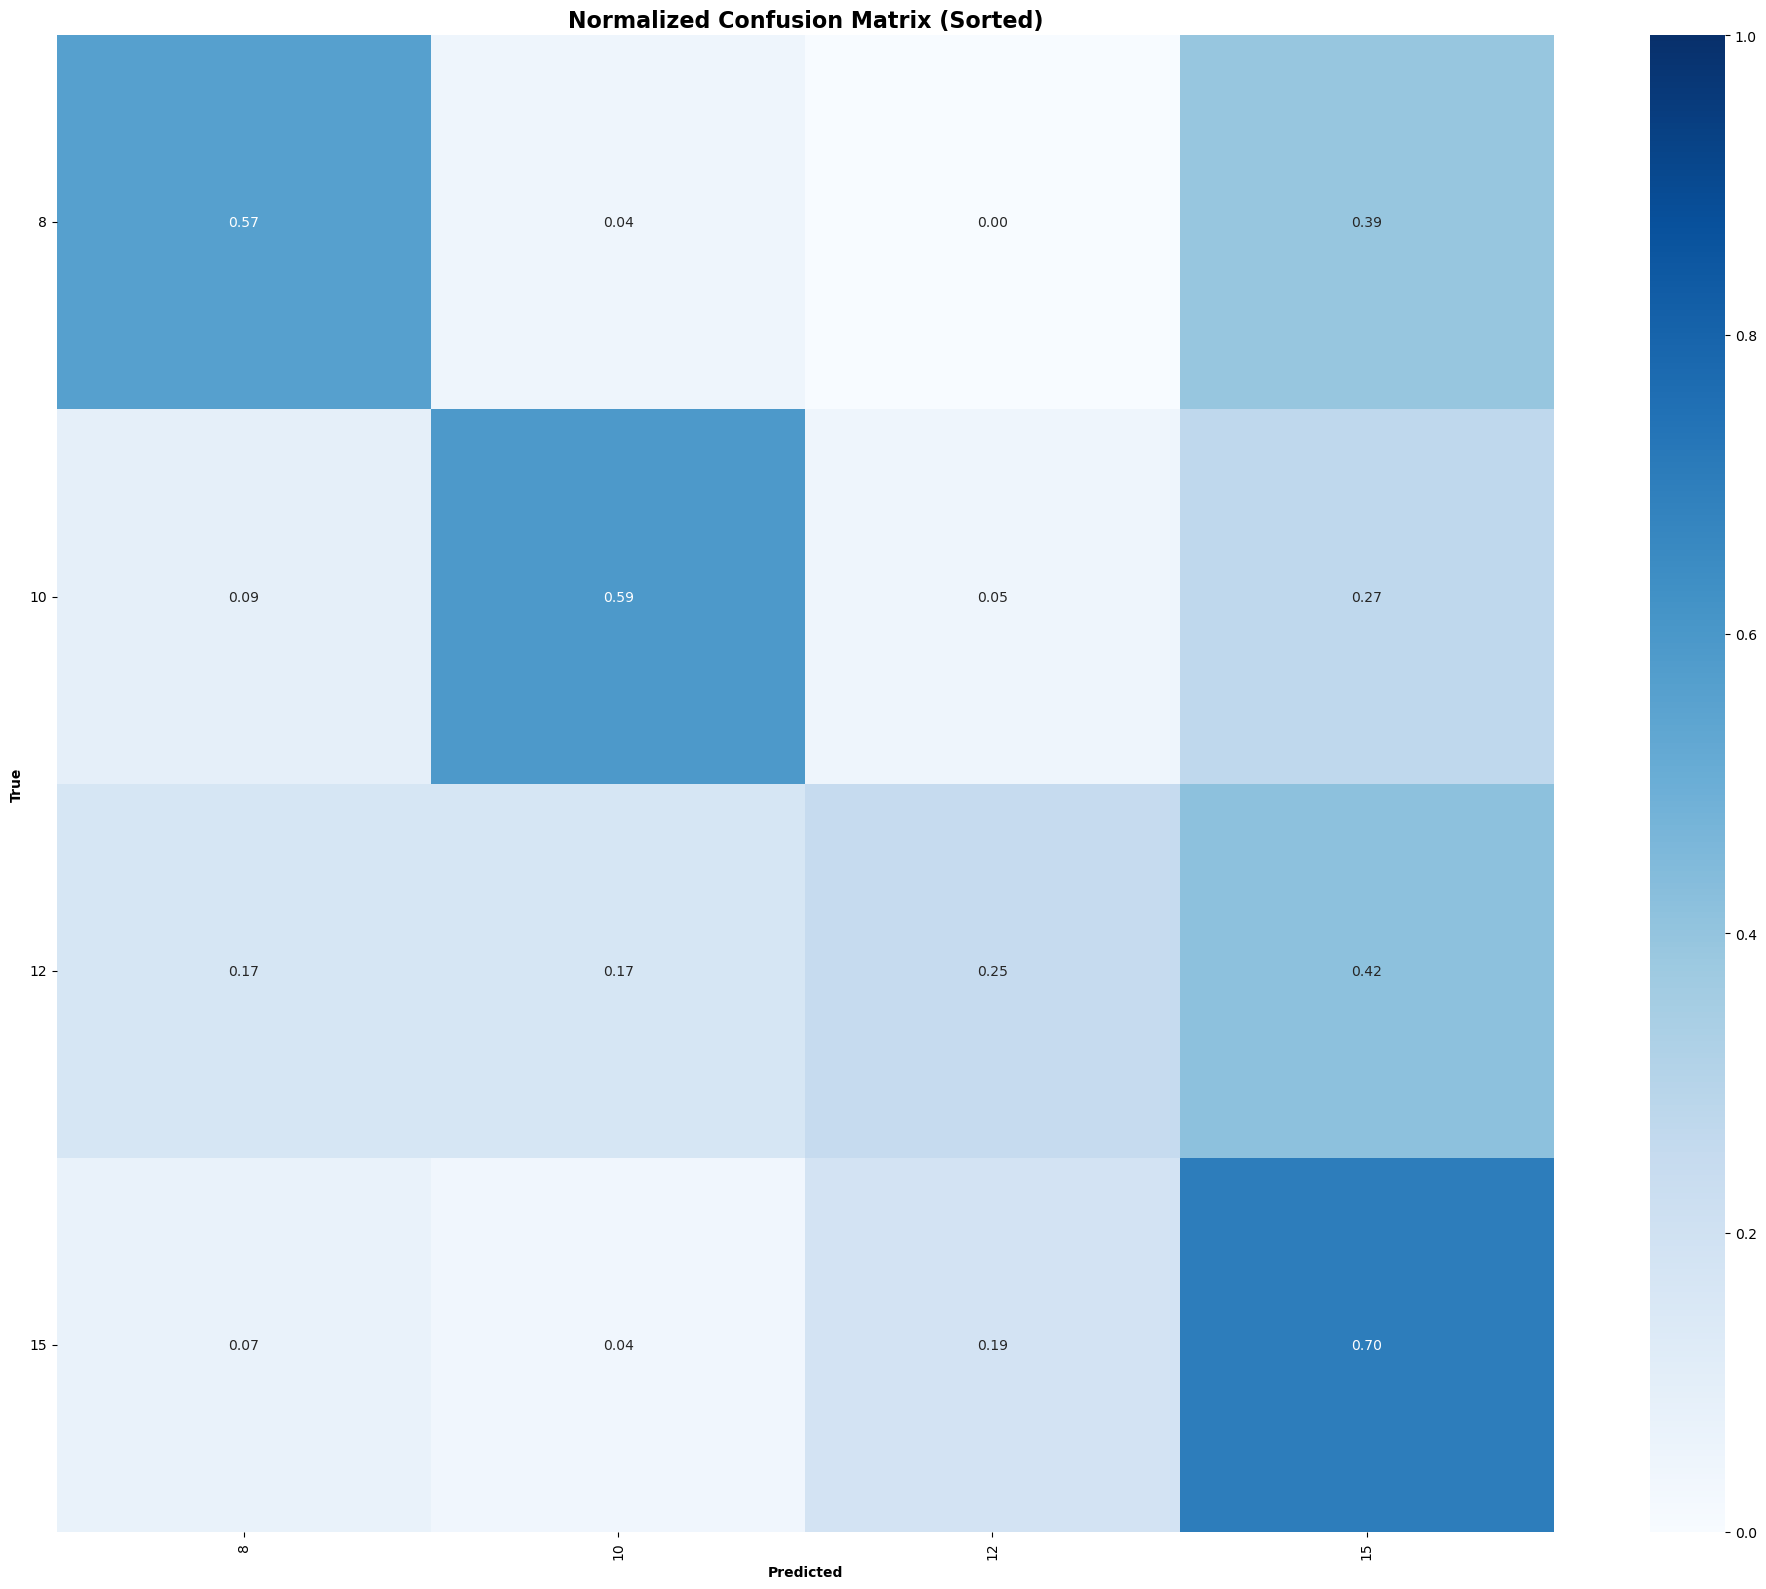

Test set Accuracy: 0.5312
Recall: 0.5312
F1 Score: 0.5208
Confusion Matrix:
[[13  1  0  9]
 [ 2 13  1  6]
 [ 4  4  6 10]
 [ 2  1  5 19]]
Running for subject S12 ---------------
Testing on subject 12.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.8750
Epoch 1/50: Train Loss: 1.2564, Train Accuracy: 0.3963, Val Loss: 0.5278, Val Accuracy: 0.8750
Validation loss decreased...
Best model saved with accuracy: 0.9167
Epoch 2/50: Train Loss: 0.7196, Train Accuracy: 0.7404, Val Loss: 0.3962, Val Accuracy: 0.9167
Validation loss decreased...
Best model saved with accuracy: 0.9583
Epoch 3/50: Train Loss: 0.5684, Train Accuracy: 0.8020, Val Loss: 0.2018, Val Accuracy: 0.9583
Validation loss decreased...
Epoch 4/50: Train Loss: 0.5065, Train Accuracy: 0.8265, Val Loss: 0.1987, Val Accuracy: 0.9583
Epoch 5/50: Train Loss: 0.5033, Train Accuracy: 0.8262, Val Loss: 0.1425, Val Accuracy: 0.9583
Validation loss decreased...
Epoch 6/50: Tr

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

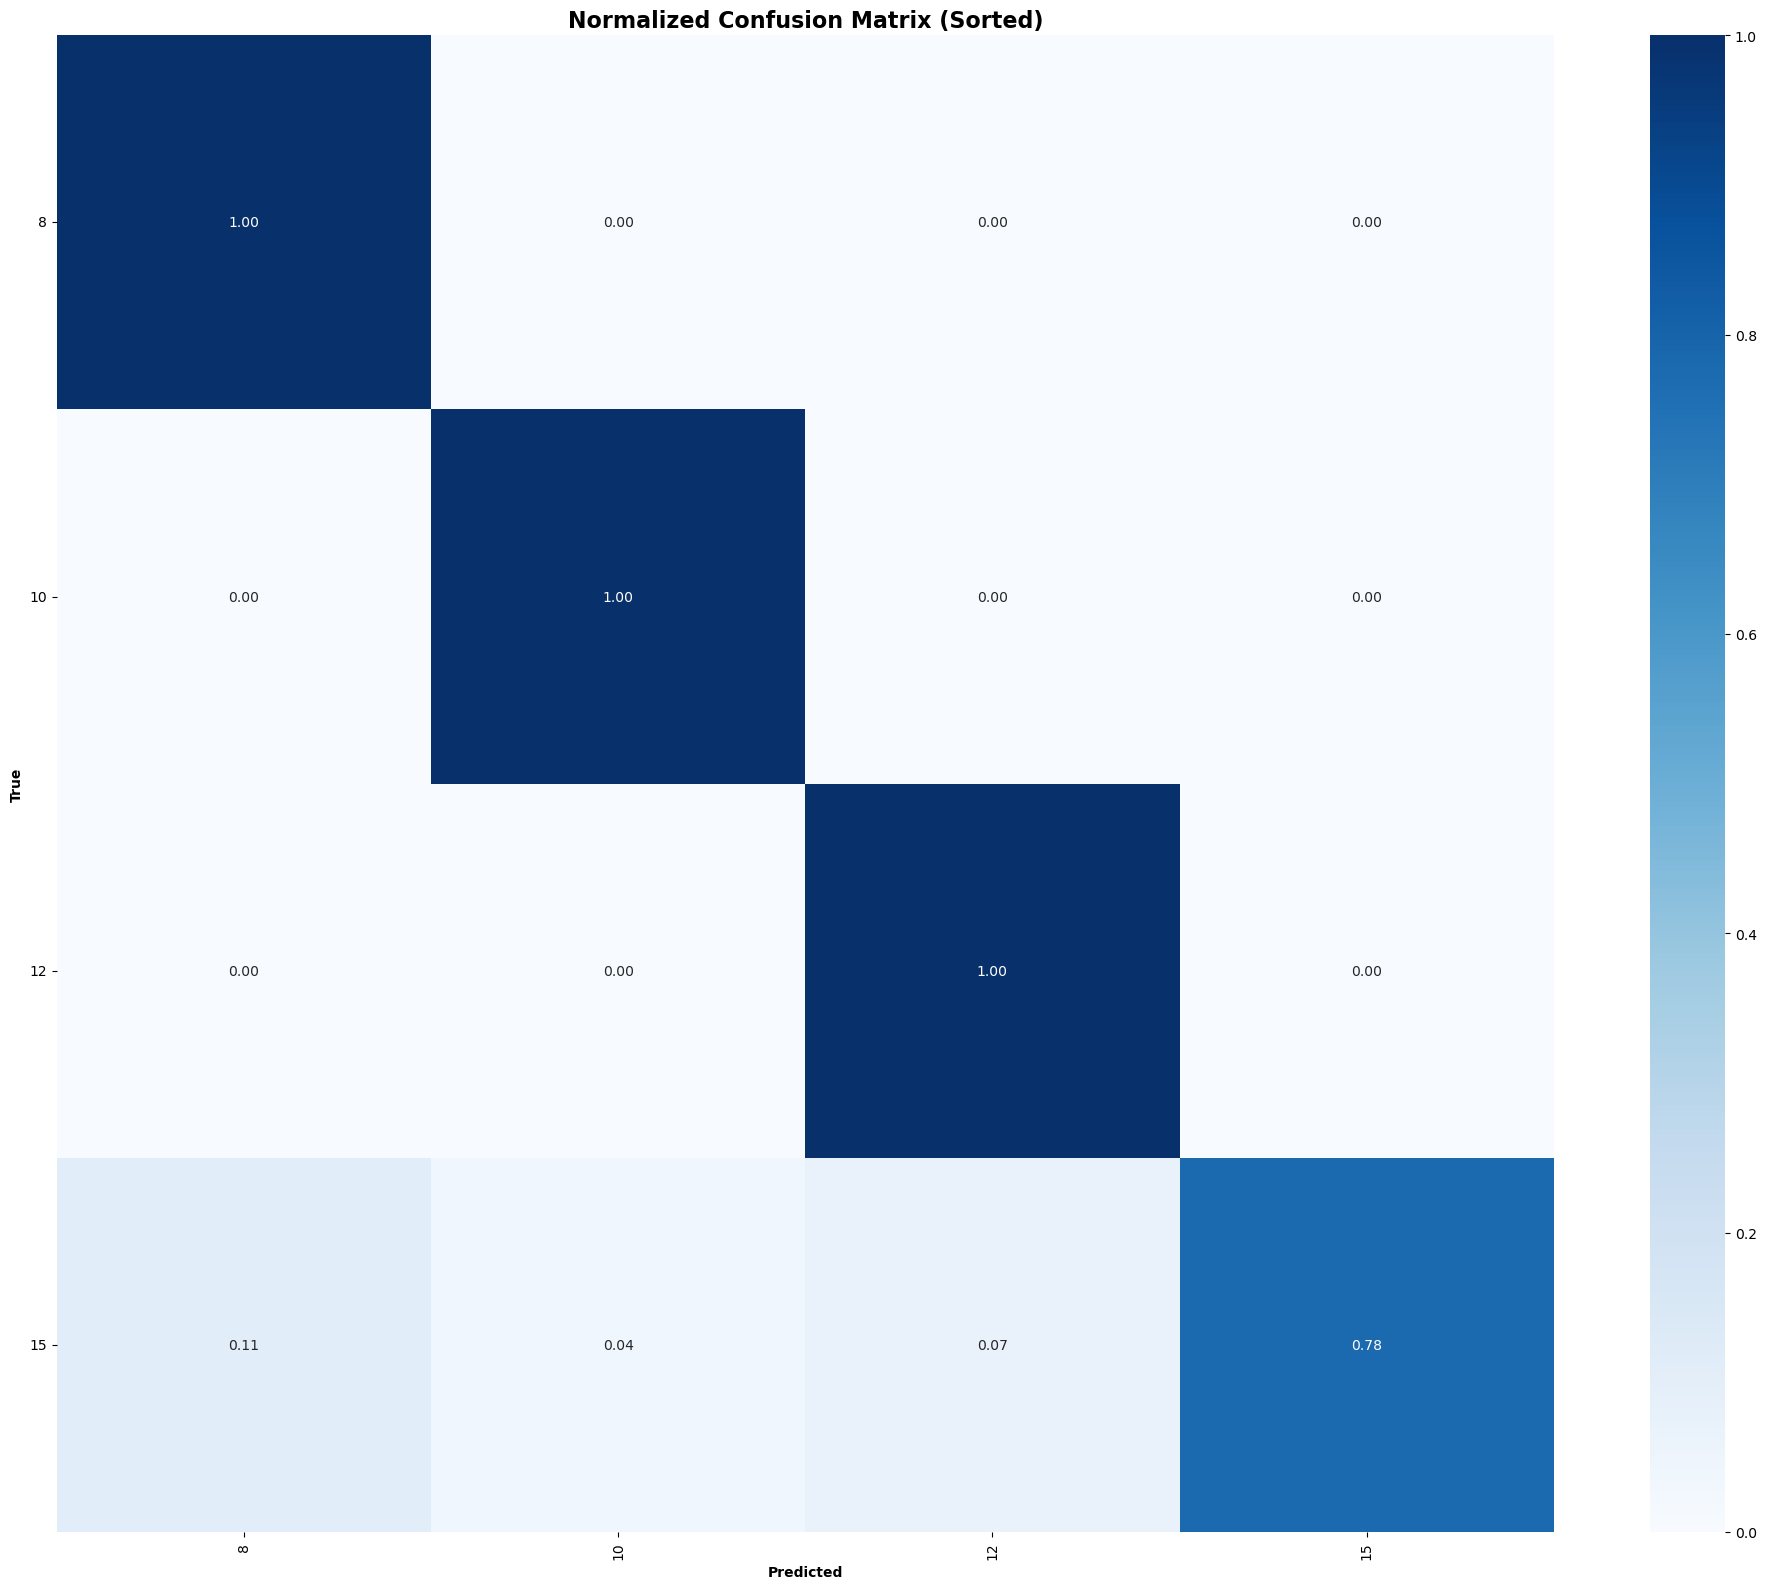

Test set Accuracy: 0.9375
Recall: 0.9375
F1 Score: 0.9351
Confusion Matrix:
[[23  0  0  0]
 [ 0 22  0  0]
 [ 0  0 24  0]
 [ 3  1  2 21]]
Running for subject S13 ---------------
Testing on subject 13.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.6250
Epoch 1/50: Train Loss: 1.2942, Train Accuracy: 0.3618, Val Loss: 0.8712, Val Accuracy: 0.6250
Validation loss decreased...
Best model saved with accuracy: 0.7500
Epoch 2/50: Train Loss: 0.7597, Train Accuracy: 0.7108, Val Loss: 0.7000, Val Accuracy: 0.7500
Validation loss decreased...
Epoch 3/50: Train Loss: 0.5340, Train Accuracy: 0.8157, Val Loss: 0.7354, Val Accuracy: 0.7083
Epoch 4/50: Train Loss: 0.5236, Train Accuracy: 0.8164, Val Loss: 0.6906, Val Accuracy: 0.7500
Best model saved with accuracy: 0.8333
Epoch 5/50: Train Loss: 0.4698, Train Accuracy: 0.8331, Val Loss: 0.5648, Val Accuracy: 0.8333
Validation loss decreased...
Epoch 6/50: Train Loss: 0.4412, Train Accur

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

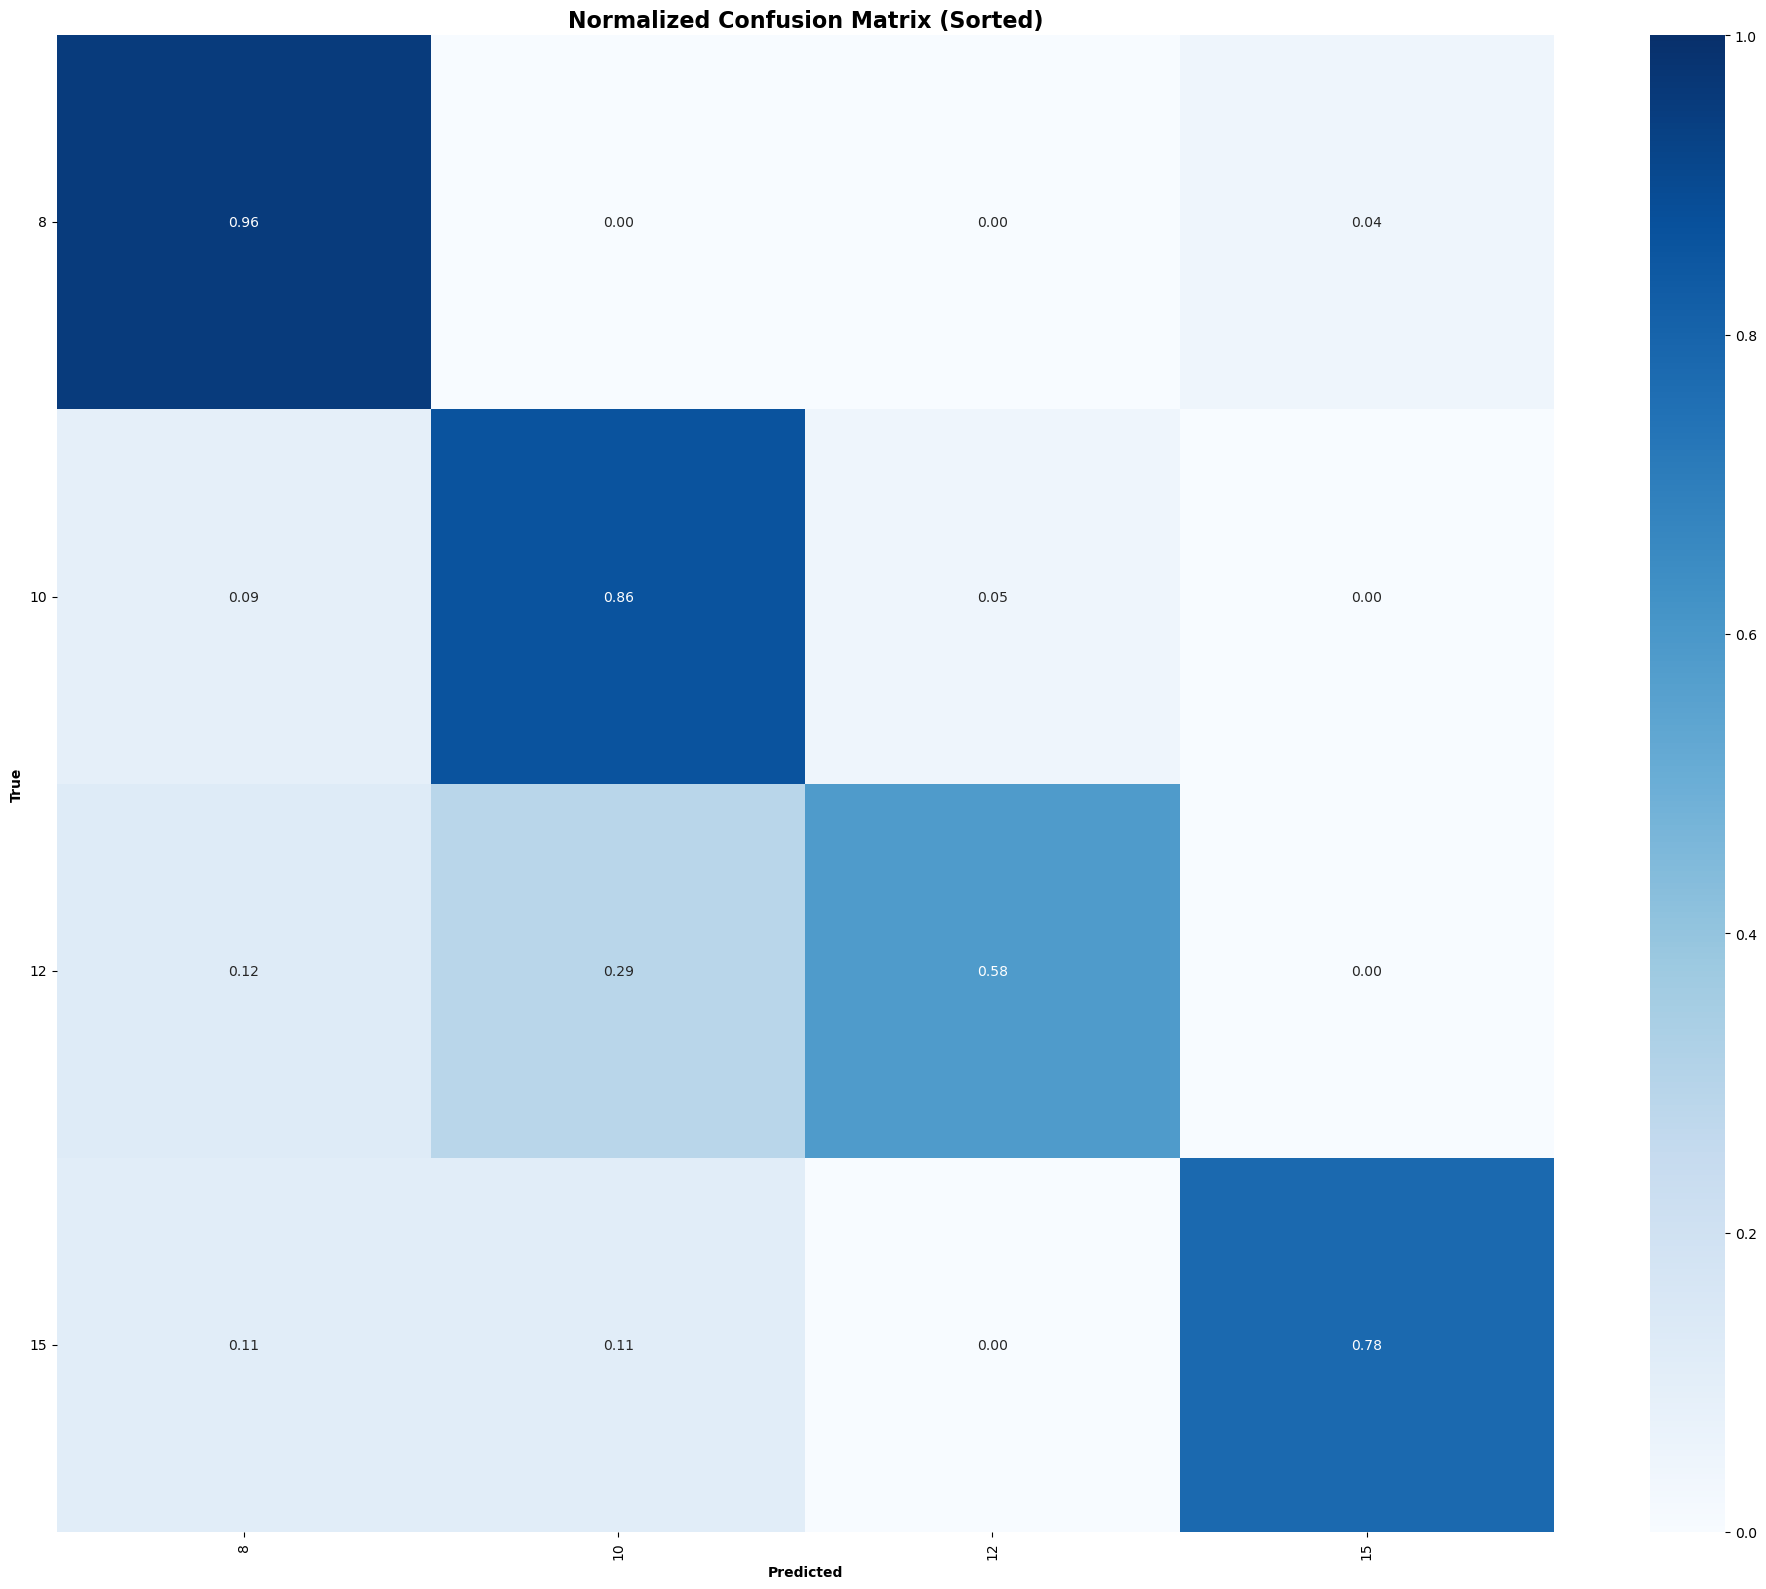

Test set Accuracy: 0.7917
Recall: 0.7917
F1 Score: 0.7902
Confusion Matrix:
[[22  0  0  1]
 [ 2 19  1  0]
 [ 3  7 14  0]
 [ 3  3  0 21]]
Running for subject S14 ---------------
Testing on subject 14.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.1250
Epoch 1/50: Train Loss: 1.2824, Train Accuracy: 0.3610, Val Loss: 1.4911, Val Accuracy: 0.1250
Validation loss decreased...
Best model saved with accuracy: 0.2083
Epoch 2/50: Train Loss: 0.8672, Train Accuracy: 0.6422, Val Loss: 1.5879, Val Accuracy: 0.2083
Epoch 3/50: Train Loss: 0.5943, Train Accuracy: 0.7922, Val Loss: 1.4990, Val Accuracy: 0.2083
Best model saved with accuracy: 0.3333
Epoch 4/50: Train Loss: 0.5007, Train Accuracy: 0.8326, Val Loss: 1.4335, Val Accuracy: 0.3333
Validation loss decreased...
Best model saved with accuracy: 0.4583
Epoch 5/50: Train Loss: 0.4710, Train Accuracy: 0.8400, Val Loss: 1.2330, Val Accuracy: 0.4583
Validation loss decreased...
Epoc

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

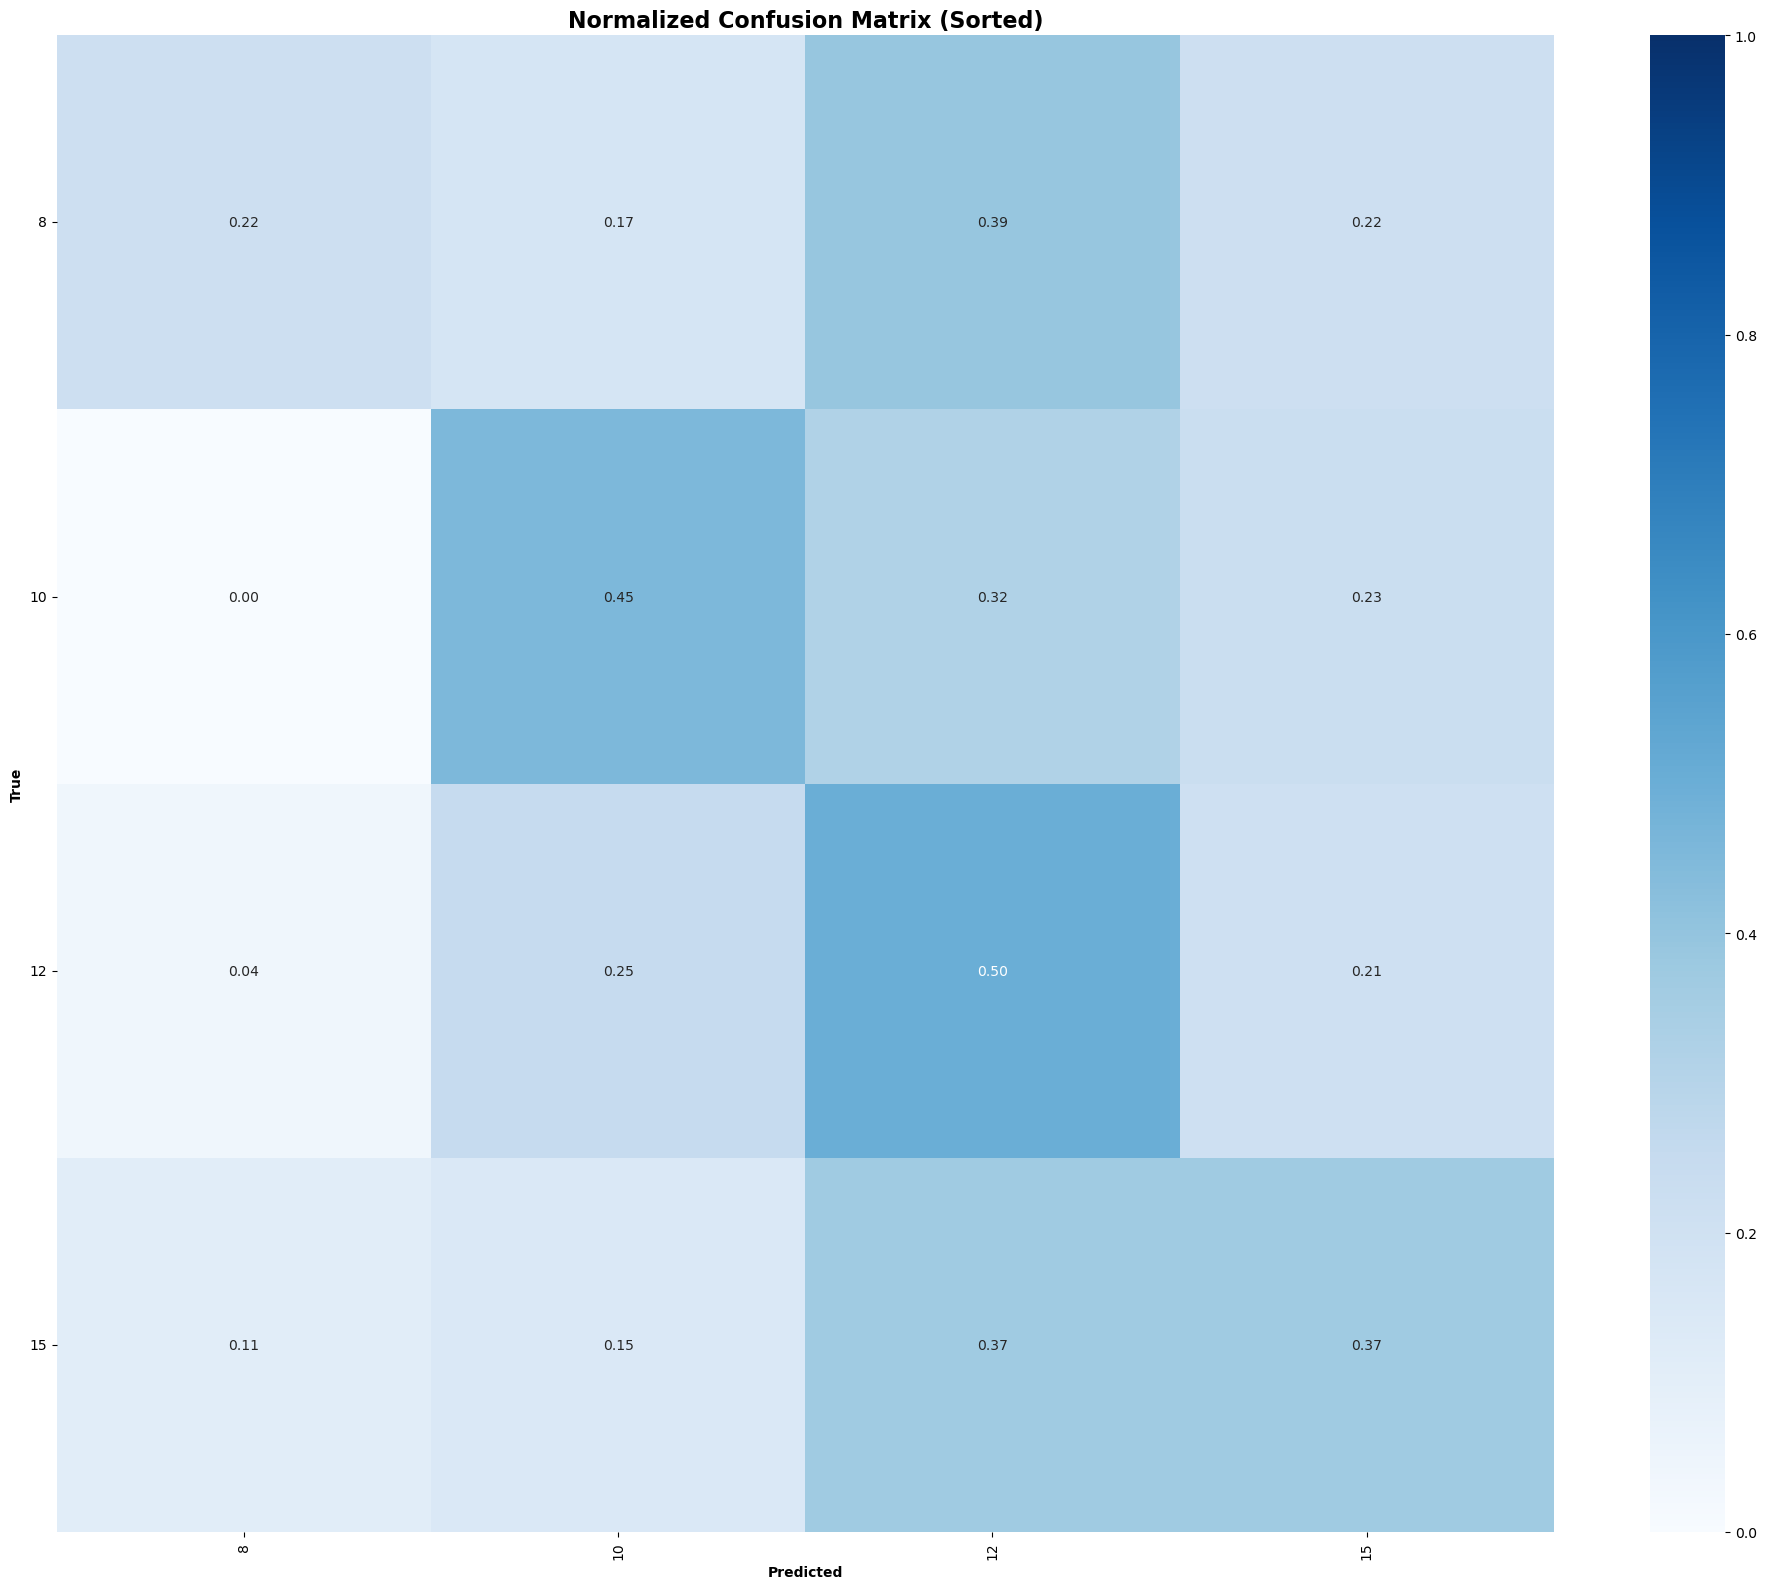

Test set Accuracy: 0.3854
Recall: 0.3854
F1 Score: 0.3795
Confusion Matrix:
[[ 5  4  9  5]
 [ 0 10  7  5]
 [ 1  6 12  5]
 [ 3  4 10 10]]
Running for subject S15 ---------------
Testing on subject 15.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.9167
Epoch 1/50: Train Loss: 1.2599, Train Accuracy: 0.4056, Val Loss: 0.6251, Val Accuracy: 0.9167
Validation loss decreased...
Epoch 2/50: Train Loss: 0.7583, Train Accuracy: 0.7233, Val Loss: 0.4933, Val Accuracy: 0.8750
Validation loss decreased...
Best model saved with accuracy: 1.0000
Epoch 3/50: Train Loss: 0.5655, Train Accuracy: 0.7983, Val Loss: 0.1603, Val Accuracy: 1.0000
Validation loss decreased...
Epoch 4/50: Train Loss: 0.5175, Train Accuracy: 0.8275, Val Loss: 0.2743, Val Accuracy: 0.9167
Epoch 5/50: Train Loss: 0.4824, Train Accuracy: 0.8368, Val Loss: 0.1675, Val Accuracy: 0.9583
Epoch 6/50: Train Loss: 0.4519, Train Accuracy: 0.8392, Val Loss: 0.0950, Val Accu

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

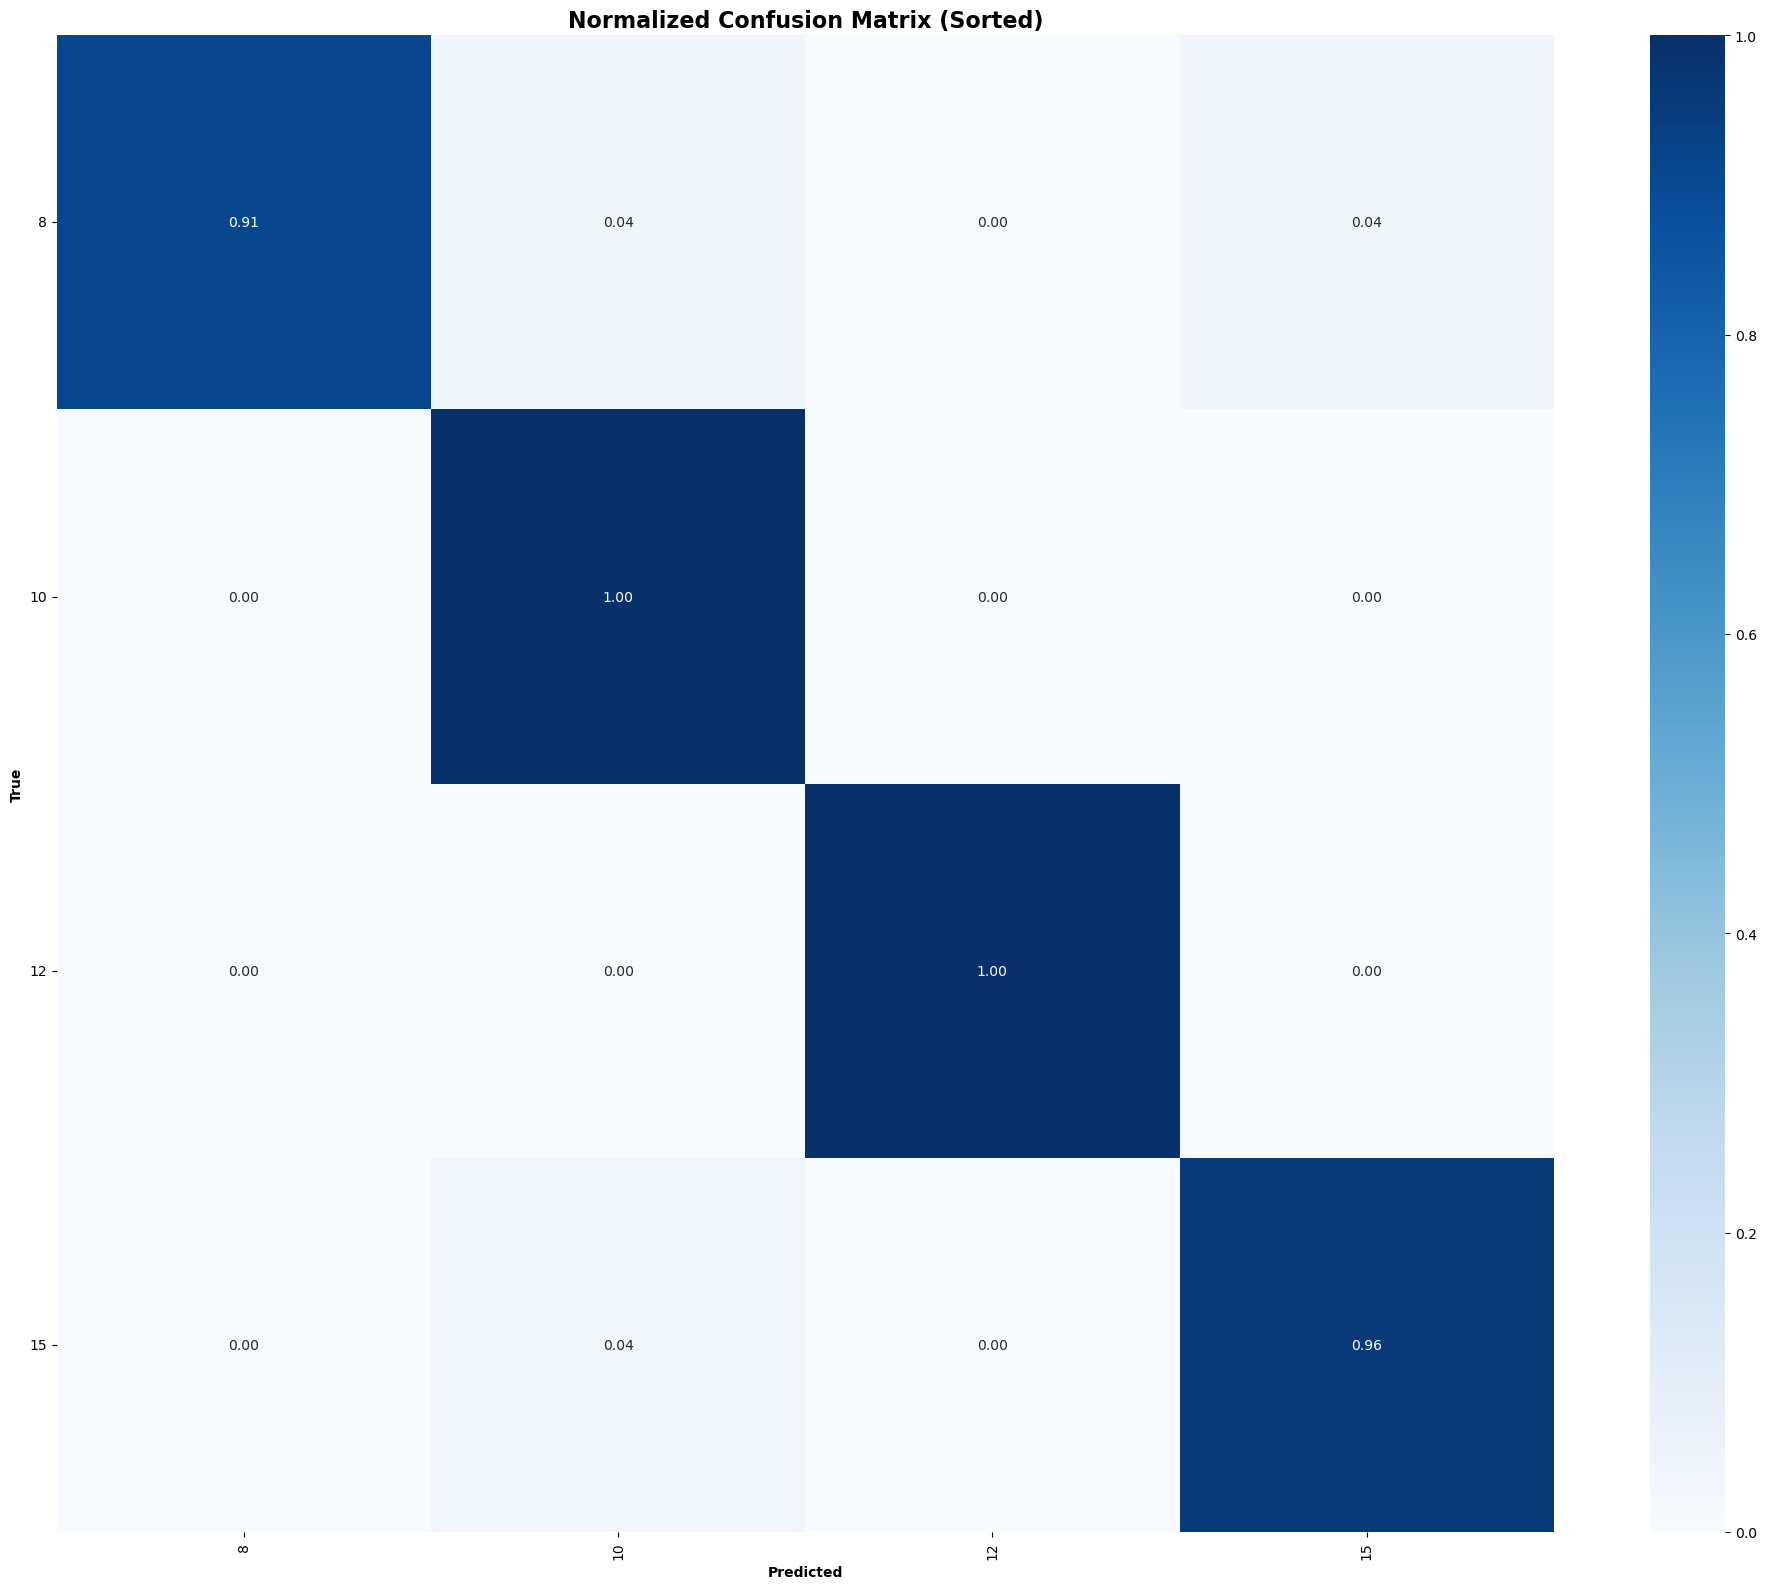

Test set Accuracy: 0.9688
Recall: 0.9688
F1 Score: 0.9687
Confusion Matrix:
[[21  1  0  1]
 [ 0 22  0  0]
 [ 0  0 24  0]
 [ 0  1  0 26]]
Running for subject S16 ---------------
Testing on subject 16.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.6250
Epoch 1/50: Train Loss: 1.1711, Train Accuracy: 0.4581, Val Loss: 1.0702, Val Accuracy: 0.6250
Validation loss decreased...
Best model saved with accuracy: 0.7500
Epoch 2/50: Train Loss: 0.6298, Train Accuracy: 0.7789, Val Loss: 0.9400, Val Accuracy: 0.7500
Validation loss decreased...
Epoch 3/50: Train Loss: 0.5109, Train Accuracy: 0.8172, Val Loss: 0.7259, Val Accuracy: 0.7500
Validation loss decreased...
Best model saved with accuracy: 0.7917
Epoch 4/50: Train Loss: 0.4522, Train Accuracy: 0.8480, Val Loss: 0.7207, Val Accuracy: 0.7917
Best model saved with accuracy: 0.8333
Epoch 5/50: Train Loss: 0.4544, Train Accuracy: 0.8434, Val Loss: 0.5277, Val Accuracy: 0.8333
Vali

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

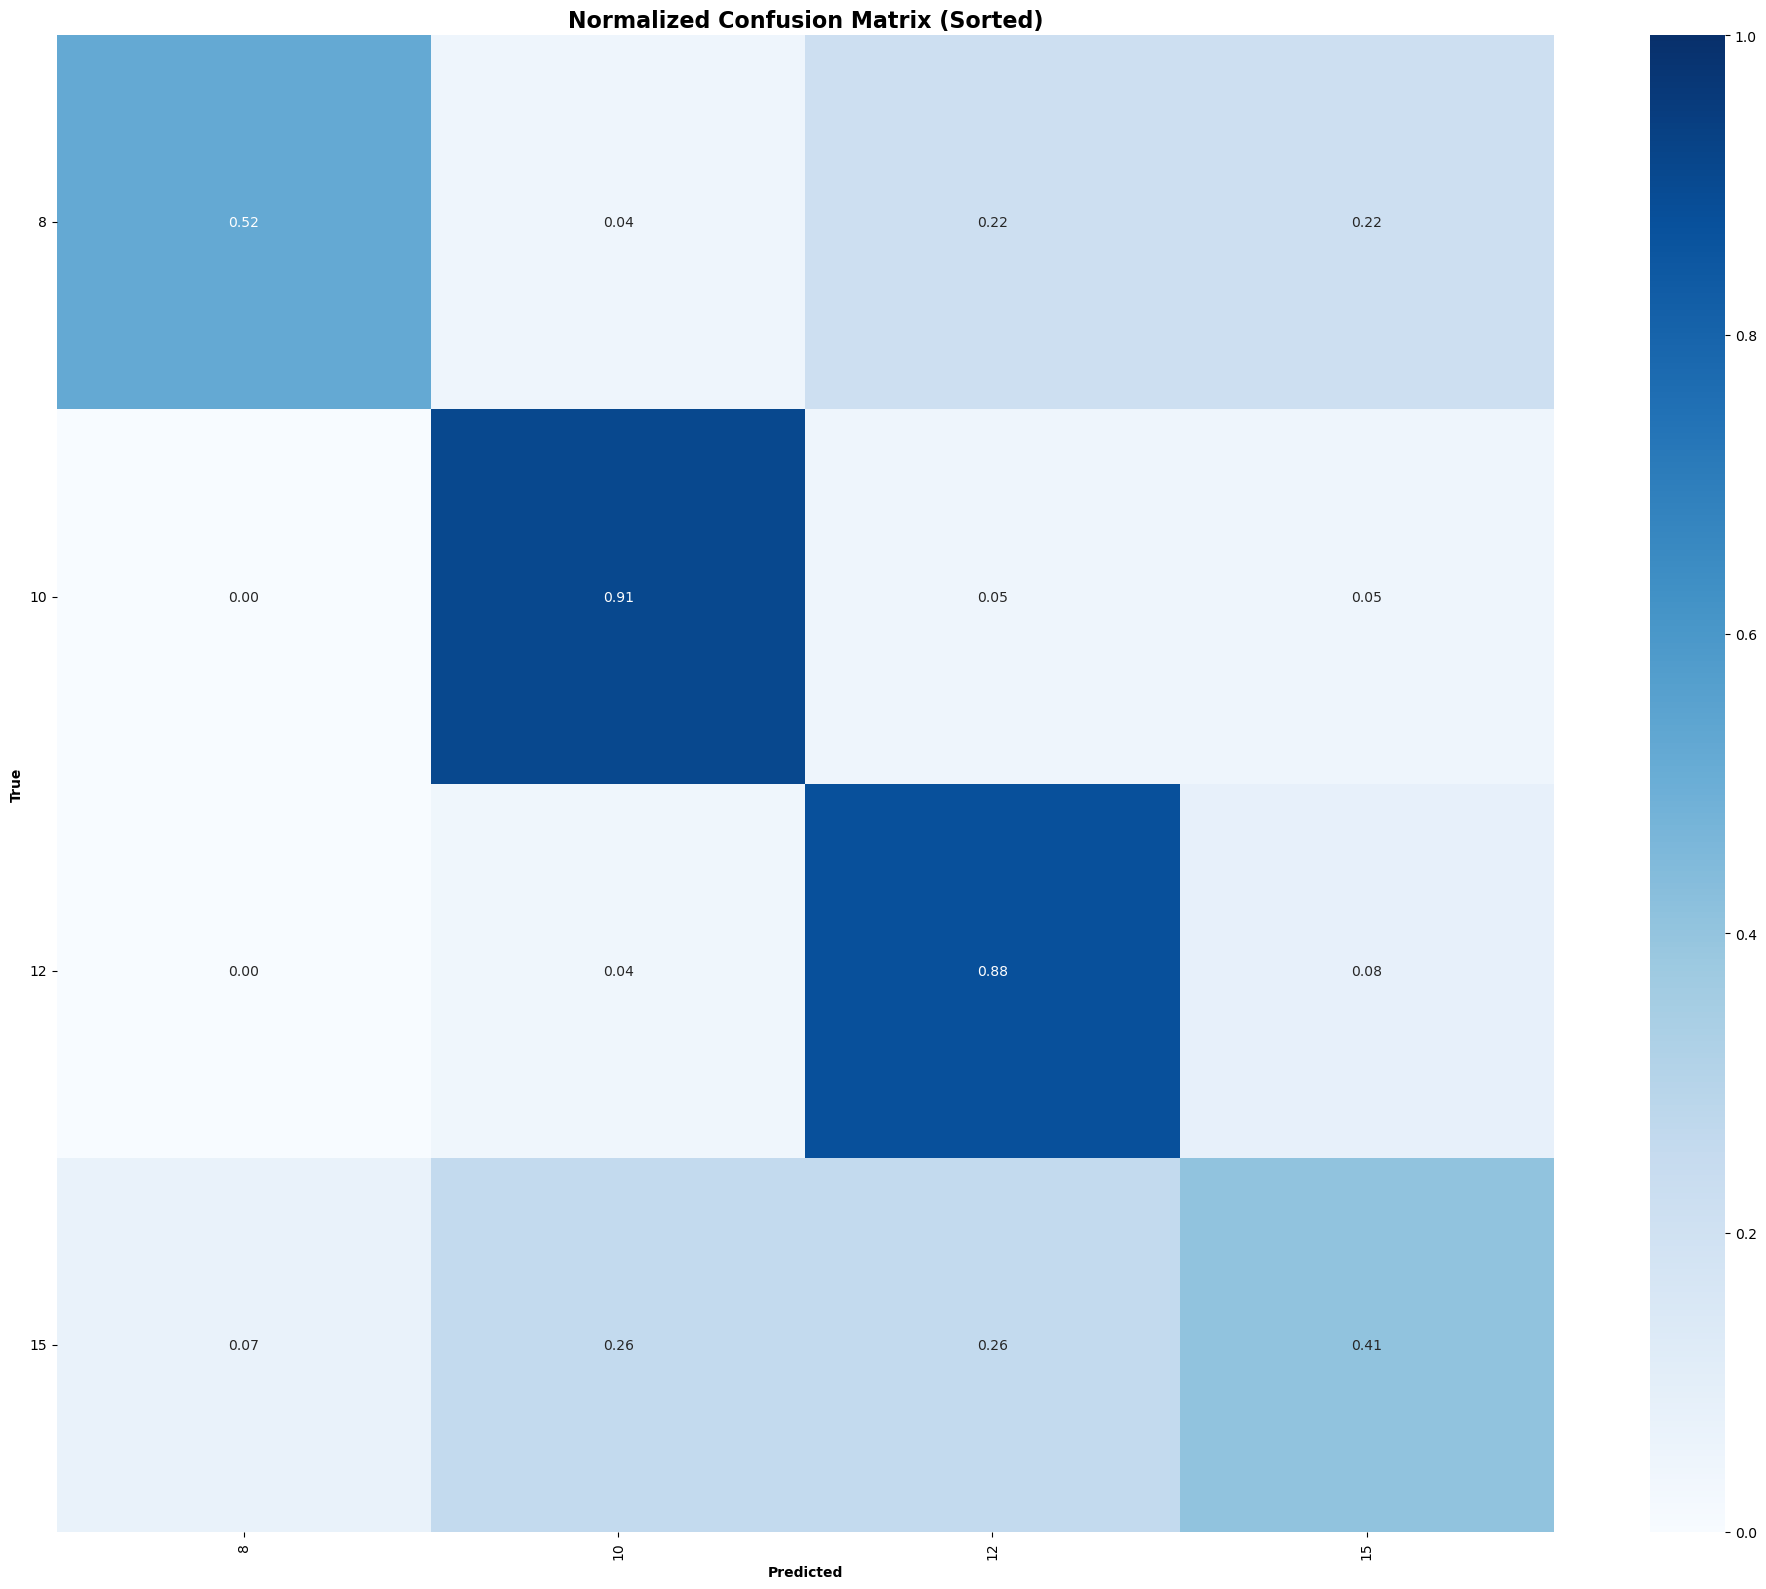

Test set Accuracy: 0.6667
Recall: 0.6667
F1 Score: 0.6507
Confusion Matrix:
[[12  1  5  5]
 [ 0 20  1  1]
 [ 0  1 21  2]
 [ 2  7  7 11]]
Running for subject S17 ---------------
Testing on subject 17.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 1.0000
Epoch 1/50: Train Loss: 1.2106, Train Accuracy: 0.4225, Val Loss: 0.4660, Val Accuracy: 1.0000
Validation loss decreased...
Epoch 2/50: Train Loss: 0.6438, Train Accuracy: 0.7804, Val Loss: 0.2901, Val Accuracy: 0.9167
Validation loss decreased...
Epoch 3/50: Train Loss: 0.5363, Train Accuracy: 0.8096, Val Loss: 0.1659, Val Accuracy: 0.9583
Validation loss decreased...
Epoch 4/50: Train Loss: 0.4736, Train Accuracy: 0.8400, Val Loss: 0.1407, Val Accuracy: 0.9583
Validation loss decreased...
Epoch 5/50: Train Loss: 0.4284, Train Accuracy: 0.8522, Val Loss: 0.2666, Val Accuracy: 0.9583
Epoch 6/50: Train Loss: 0.4357, Train Accuracy: 0.8527, Val Loss: 0.2230, Val Accuracy: 0.95

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

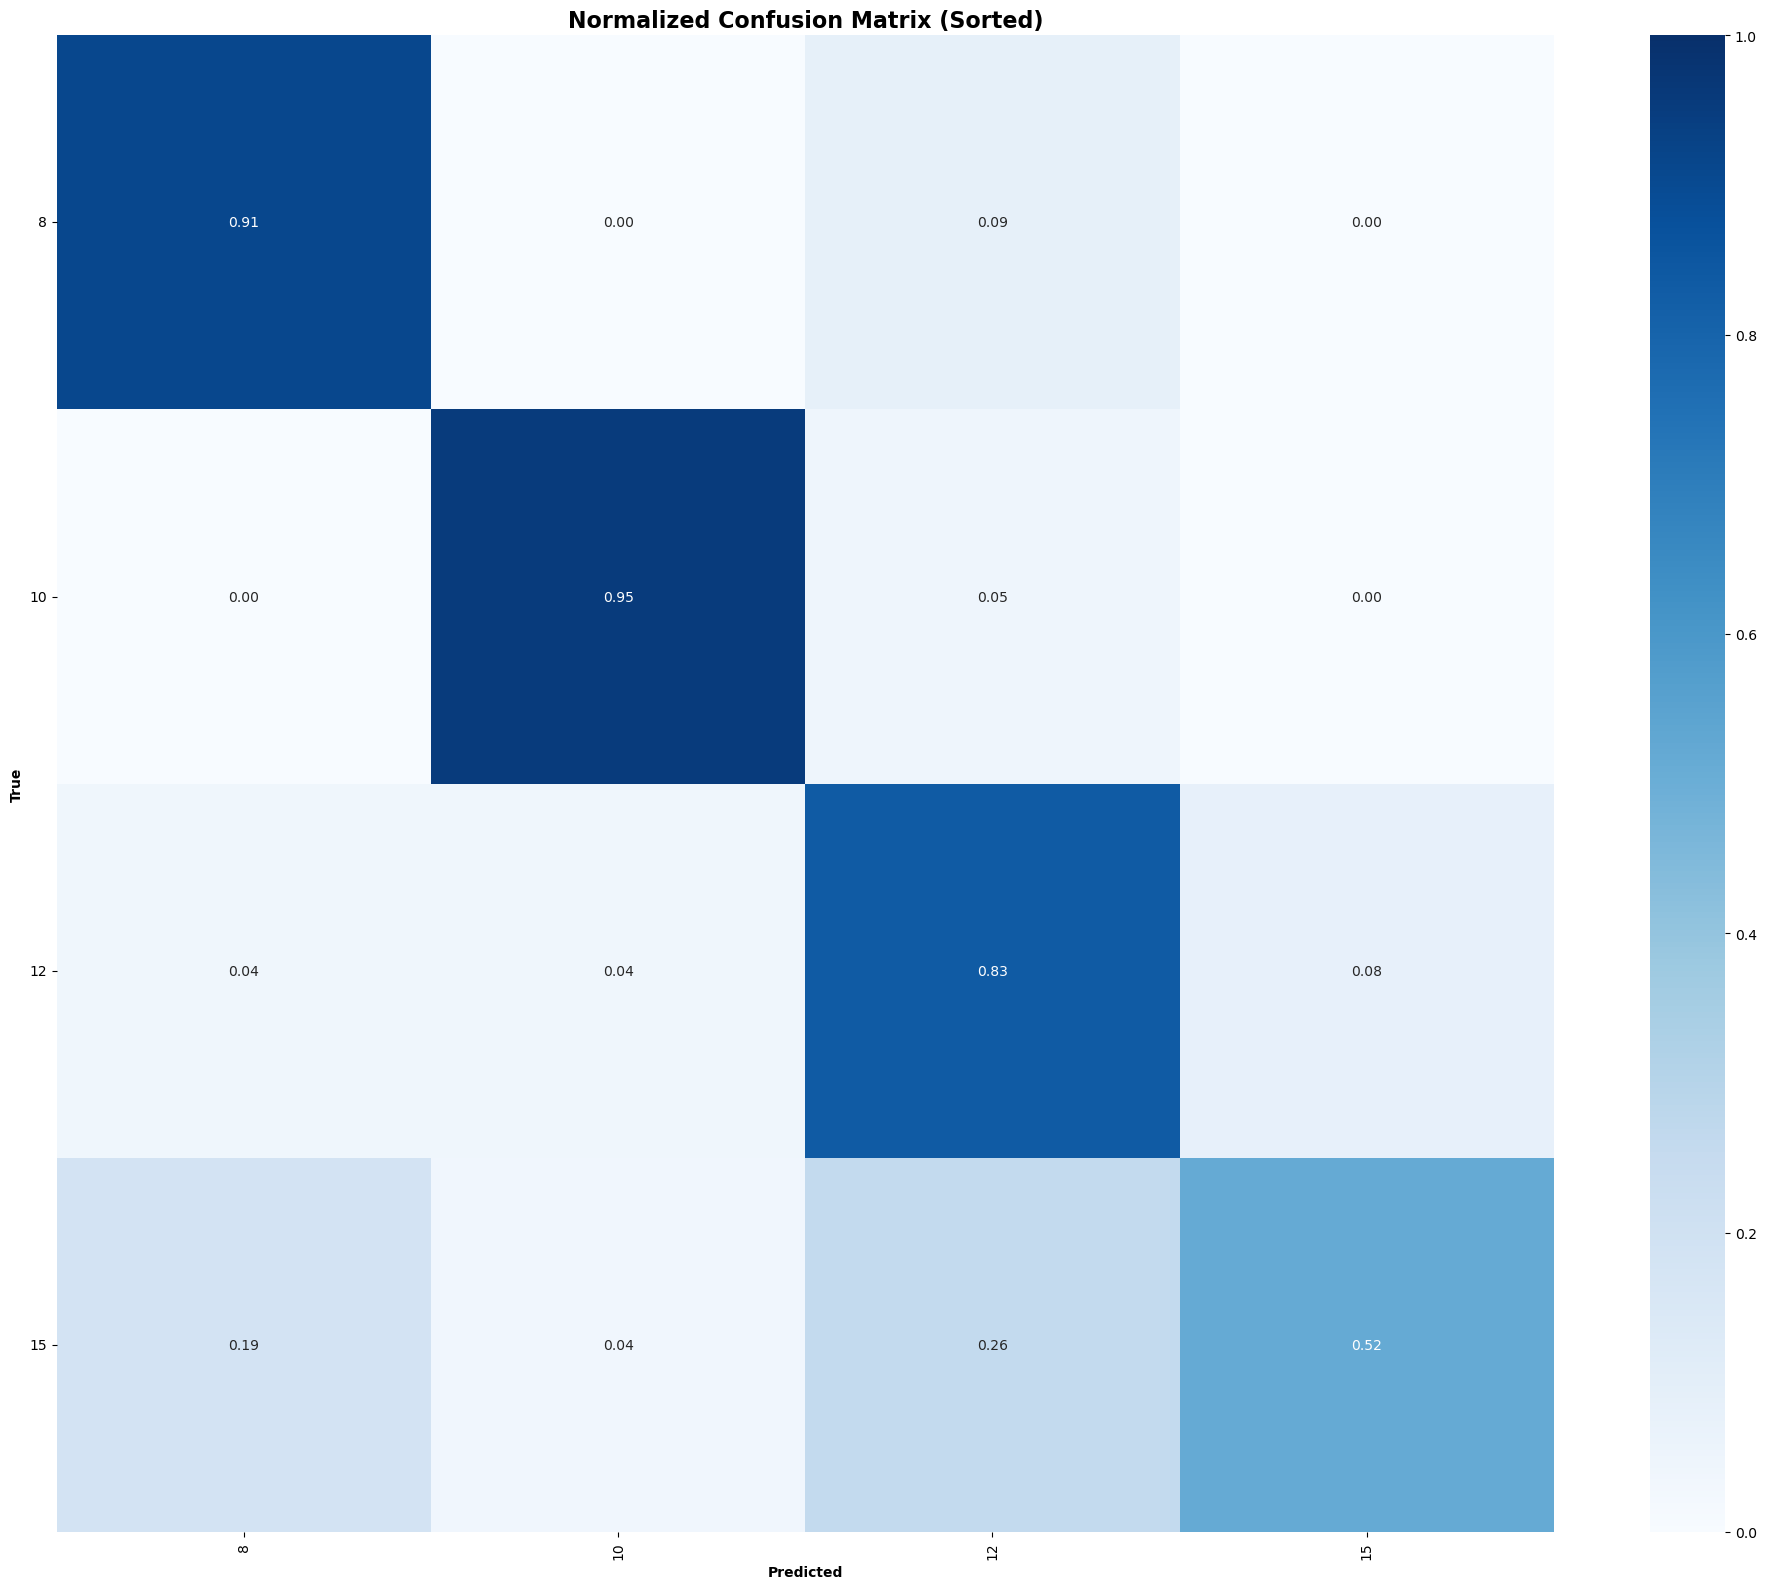

Test set Accuracy: 0.7917
Recall: 0.7917
F1 Score: 0.7835
Confusion Matrix:
[[21  0  2  0]
 [ 0 21  1  0]
 [ 1  1 20  2]
 [ 5  1  7 14]]
Running for subject S18 ---------------
Testing on subject 18.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.6250
Epoch 1/50: Train Loss: 1.3310, Train Accuracy: 0.3287, Val Loss: 1.1013, Val Accuracy: 0.6250
Validation loss decreased...
Best model saved with accuracy: 0.9167
Epoch 2/50: Train Loss: 0.7390, Train Accuracy: 0.7326, Val Loss: 0.6044, Val Accuracy: 0.9167
Validation loss decreased...
Epoch 3/50: Train Loss: 0.5643, Train Accuracy: 0.8029, Val Loss: 0.7052, Val Accuracy: 0.7500
Epoch 4/50: Train Loss: 0.5173, Train Accuracy: 0.8228, Val Loss: 0.6038, Val Accuracy: 0.7083
Epoch 5/50: Train Loss: 0.4678, Train Accuracy: 0.8360, Val Loss: 0.6260, Val Accuracy: 0.8333
Epoch 6/50: Train Loss: 0.4308, Train Accuracy: 0.8475, Val Loss: 0.5990, Val Accuracy: 0.7500
Epoch 7/50: Trai

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

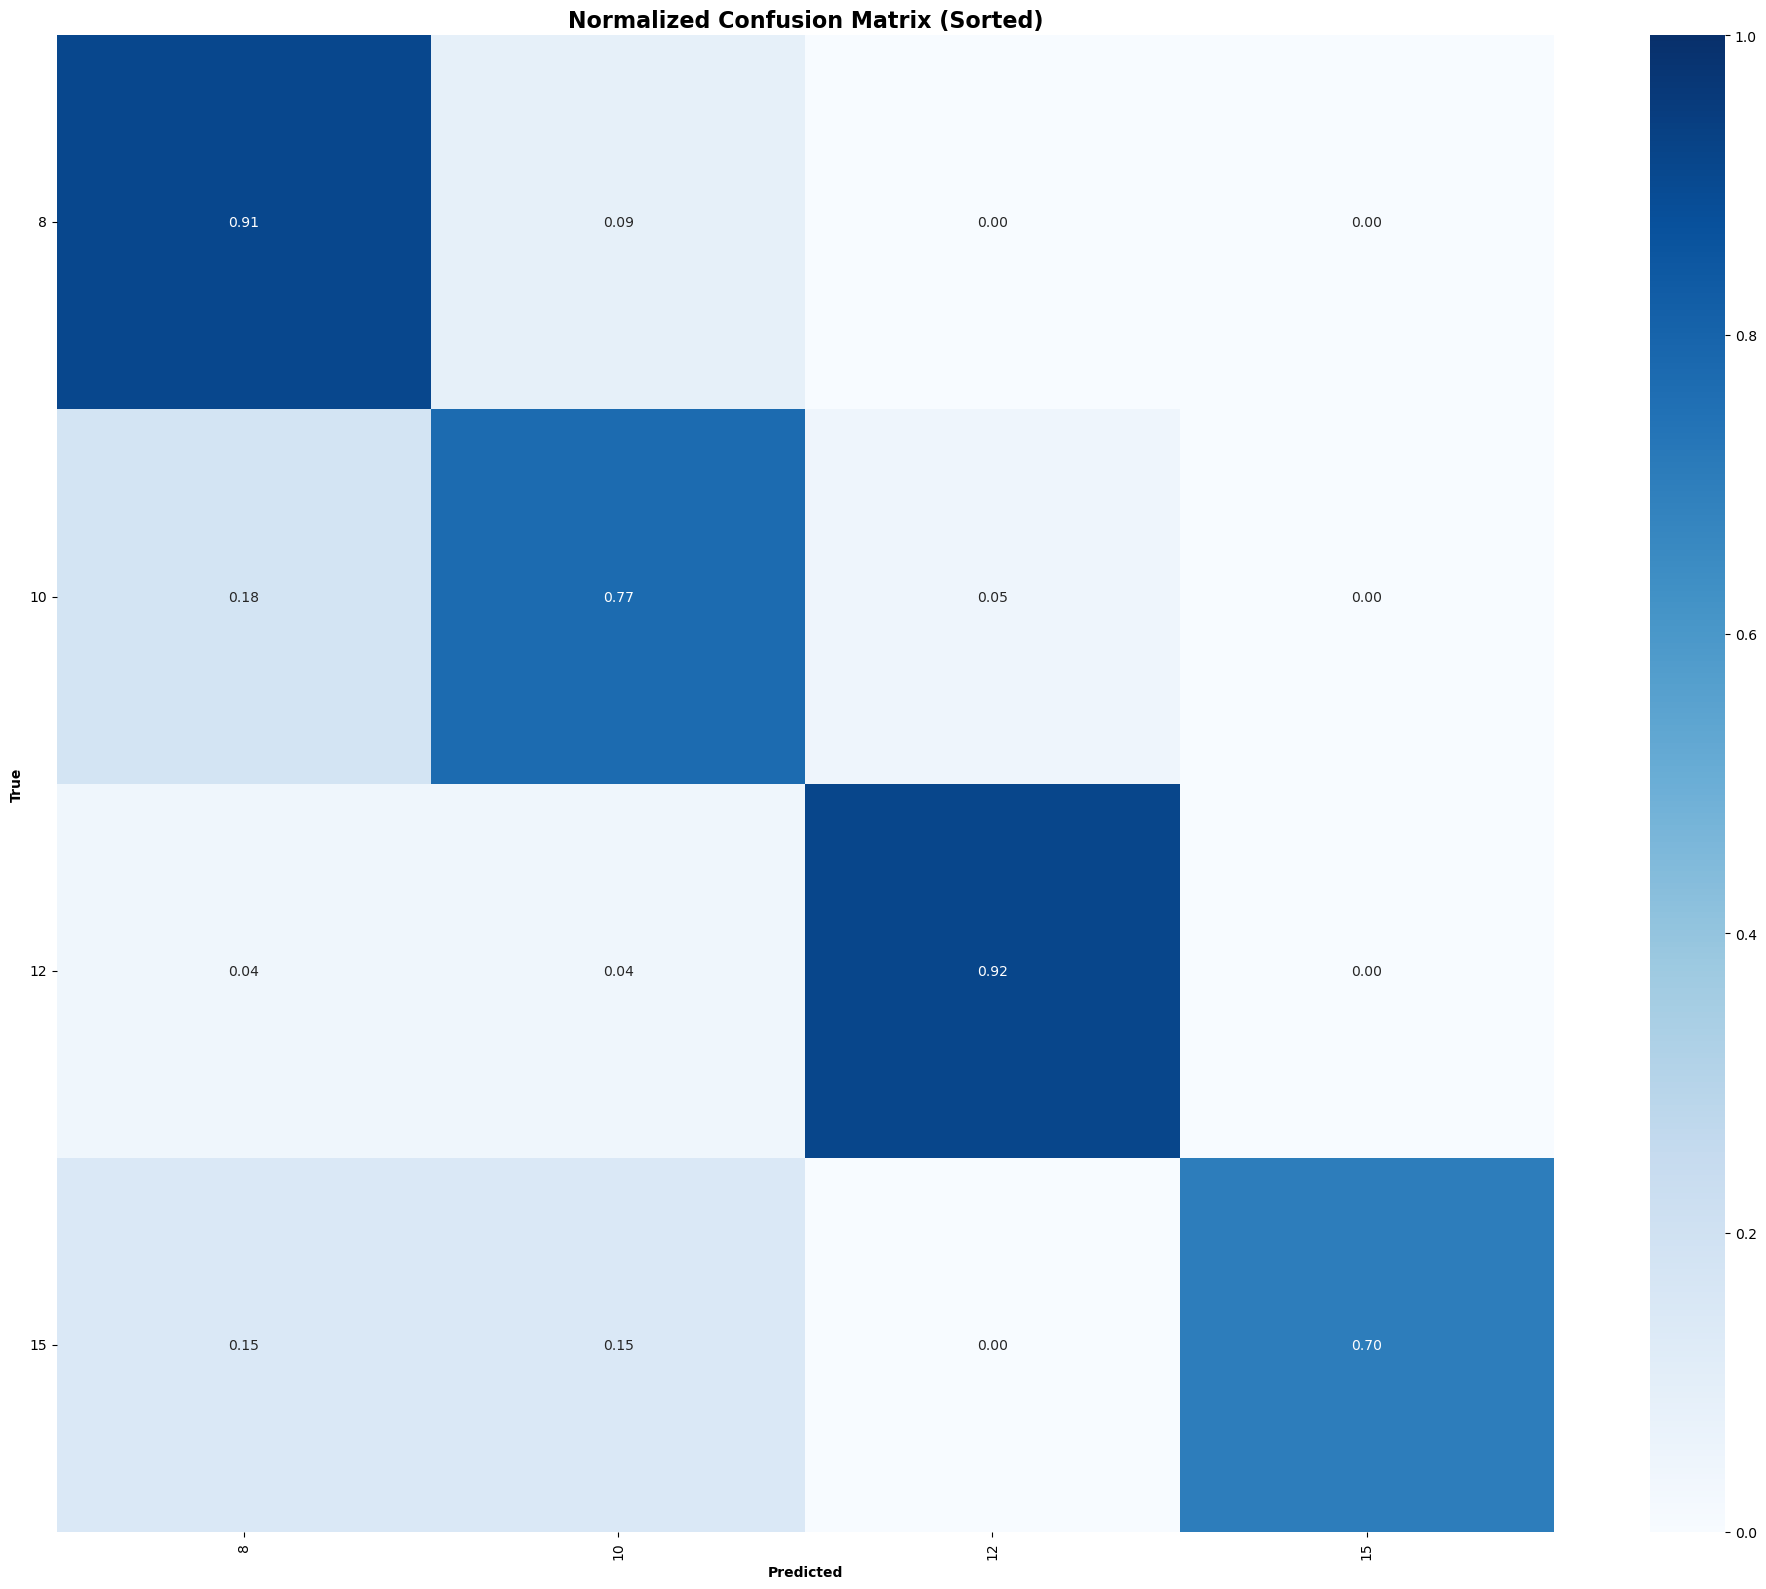

Test set Accuracy: 0.8229
Recall: 0.8229
F1 Score: 0.8256
Confusion Matrix:
[[21  2  0  0]
 [ 4 17  1  0]
 [ 1  1 22  0]
 [ 4  4  0 19]]
Running for subject S19 ---------------
Testing on subject 19.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.5417
Epoch 1/50: Train Loss: 1.2156, Train Accuracy: 0.4189, Val Loss: 1.0857, Val Accuracy: 0.5417
Validation loss decreased...
Best model saved with accuracy: 0.7083
Epoch 2/50: Train Loss: 0.6449, Train Accuracy: 0.7733, Val Loss: 0.7892, Val Accuracy: 0.7083
Validation loss decreased...
Epoch 3/50: Train Loss: 0.5437, Train Accuracy: 0.8172, Val Loss: 0.8571, Val Accuracy: 0.7083
Epoch 4/50: Train Loss: 0.4956, Train Accuracy: 0.8257, Val Loss: 0.8880, Val Accuracy: 0.5833
Epoch 5/50: Train Loss: 0.4583, Train Accuracy: 0.8449, Val Loss: 0.8775, Val Accuracy: 0.7083
Epoch 6/50: Train Loss: 0.4328, Train Accuracy: 0.8485, Val Loss: 0.8508, Val Accuracy: 0.6250
Epoch 7/50: Trai

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

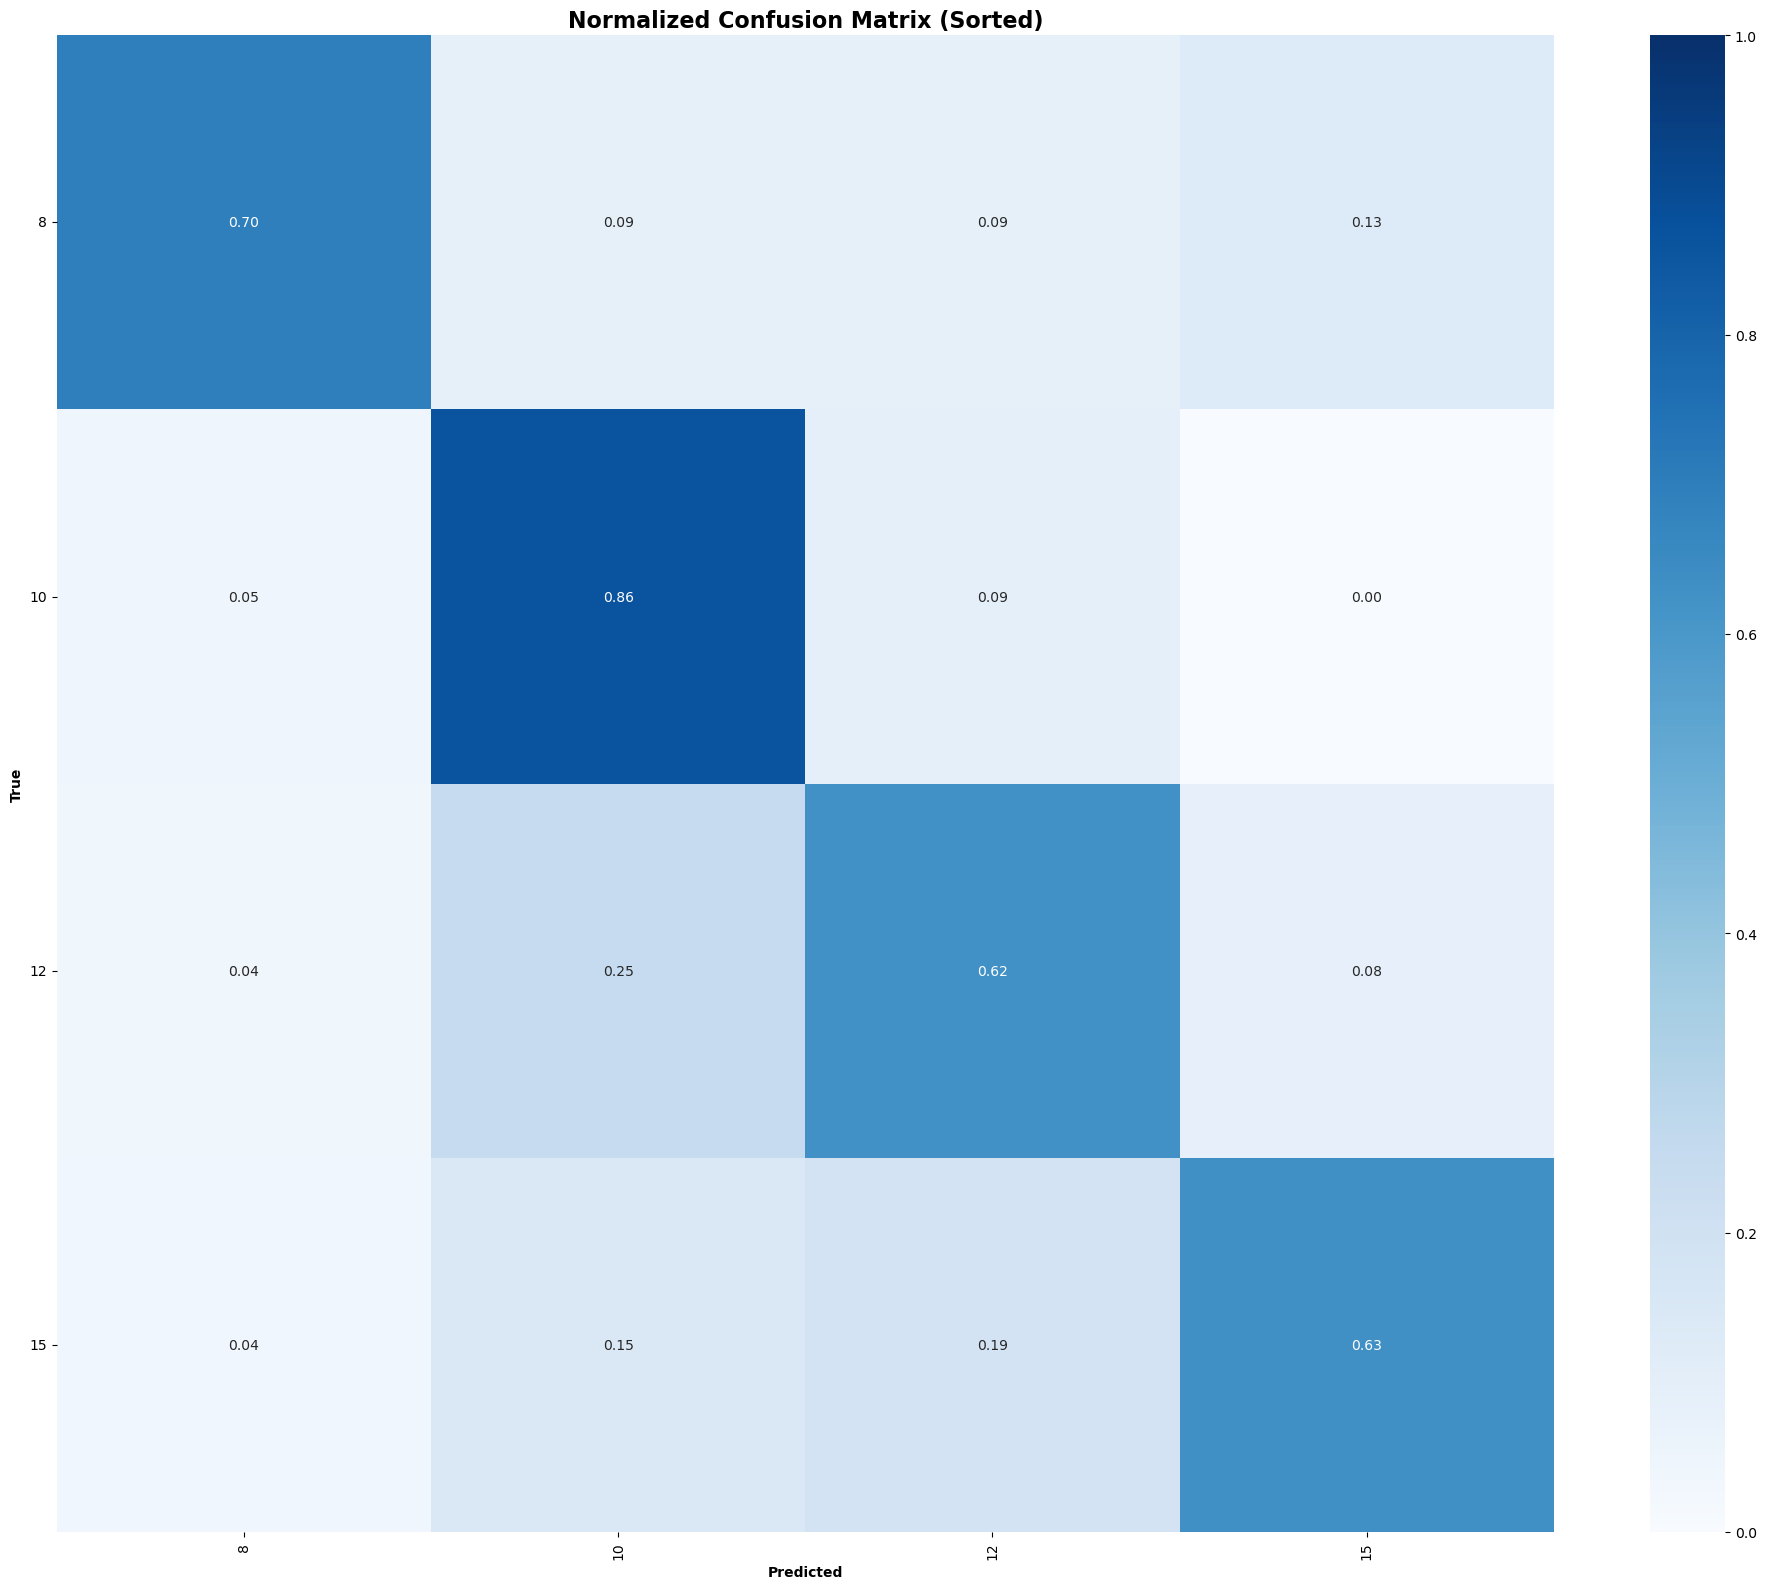

Test set Accuracy: 0.6979
Recall: 0.6979
F1 Score: 0.6983
Confusion Matrix:
[[16  2  2  3]
 [ 1 19  2  0]
 [ 1  6 15  2]
 [ 1  4  5 17]]
Running for subject S20 ---------------
Testing on subject 20.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.6667
Epoch 1/50: Train Loss: 1.2687, Train Accuracy: 0.3836, Val Loss: 0.9616, Val Accuracy: 0.6667
Validation loss decreased...
Best model saved with accuracy: 0.8750
Epoch 2/50: Train Loss: 0.7236, Train Accuracy: 0.7453, Val Loss: 0.6401, Val Accuracy: 0.8750
Validation loss decreased...
Best model saved with accuracy: 0.9583
Epoch 3/50: Train Loss: 0.5877, Train Accuracy: 0.7963, Val Loss: 0.4400, Val Accuracy: 0.9583
Validation loss decreased...
Best model saved with accuracy: 1.0000
Epoch 4/50: Train Loss: 0.5507, Train Accuracy: 0.8113, Val Loss: 0.5608, Val Accuracy: 1.0000
Epoch 5/50: Train Loss: 0.4836, Train Accuracy: 0.8333, Val Loss: 0.3422, Val Accuracy: 0.9167
Vali

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

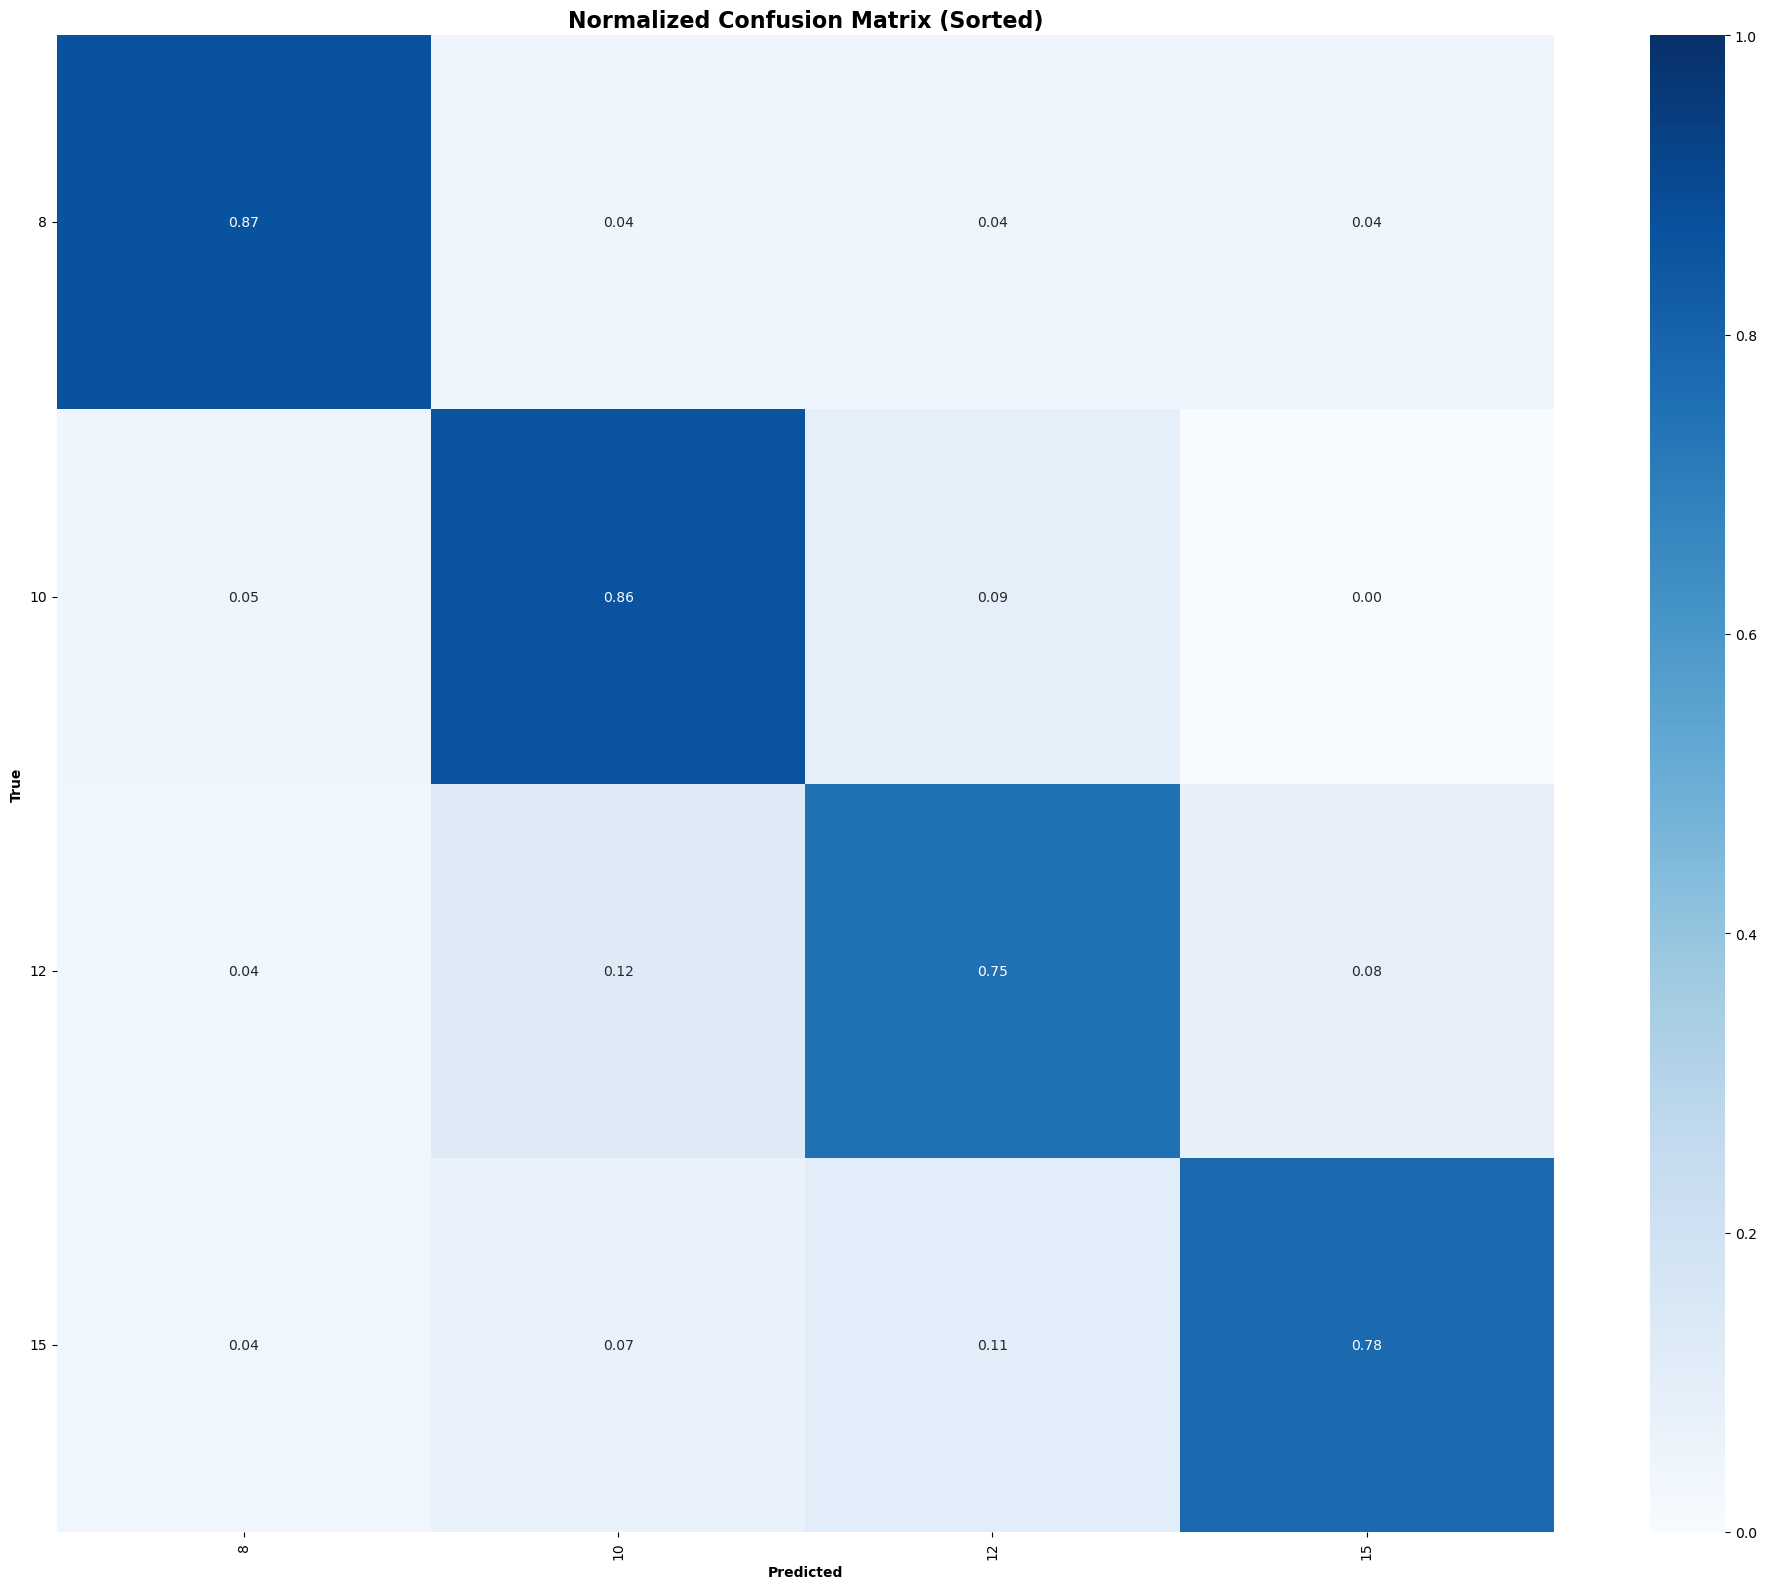

Test set Accuracy: 0.8125
Recall: 0.8125
F1 Score: 0.8127
Confusion Matrix:
[[20  1  1  1]
 [ 1 19  2  0]
 [ 1  3 18  2]
 [ 1  2  3 21]]
Running for subject S21 ---------------
Testing on subject 21.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.7500
Epoch 1/50: Train Loss: 1.1825, Train Accuracy: 0.4475, Val Loss: 1.0507, Val Accuracy: 0.7500
Validation loss decreased...
Best model saved with accuracy: 0.8333
Epoch 2/50: Train Loss: 0.6473, Train Accuracy: 0.7703, Val Loss: 0.8162, Val Accuracy: 0.8333
Validation loss decreased...
Epoch 3/50: Train Loss: 0.5298, Train Accuracy: 0.8245, Val Loss: 0.7523, Val Accuracy: 0.7917
Validation loss decreased...
Epoch 4/50: Train Loss: 0.4822, Train Accuracy: 0.8365, Val Loss: 0.6687, Val Accuracy: 0.7917
Validation loss decreased...
Epoch 5/50: Train Loss: 0.4513, Train Accuracy: 0.8439, Val Loss: 0.6861, Val Accuracy: 0.8333
Epoch 6/50: Train Loss: 0.4369, Train Accuracy: 0.850

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

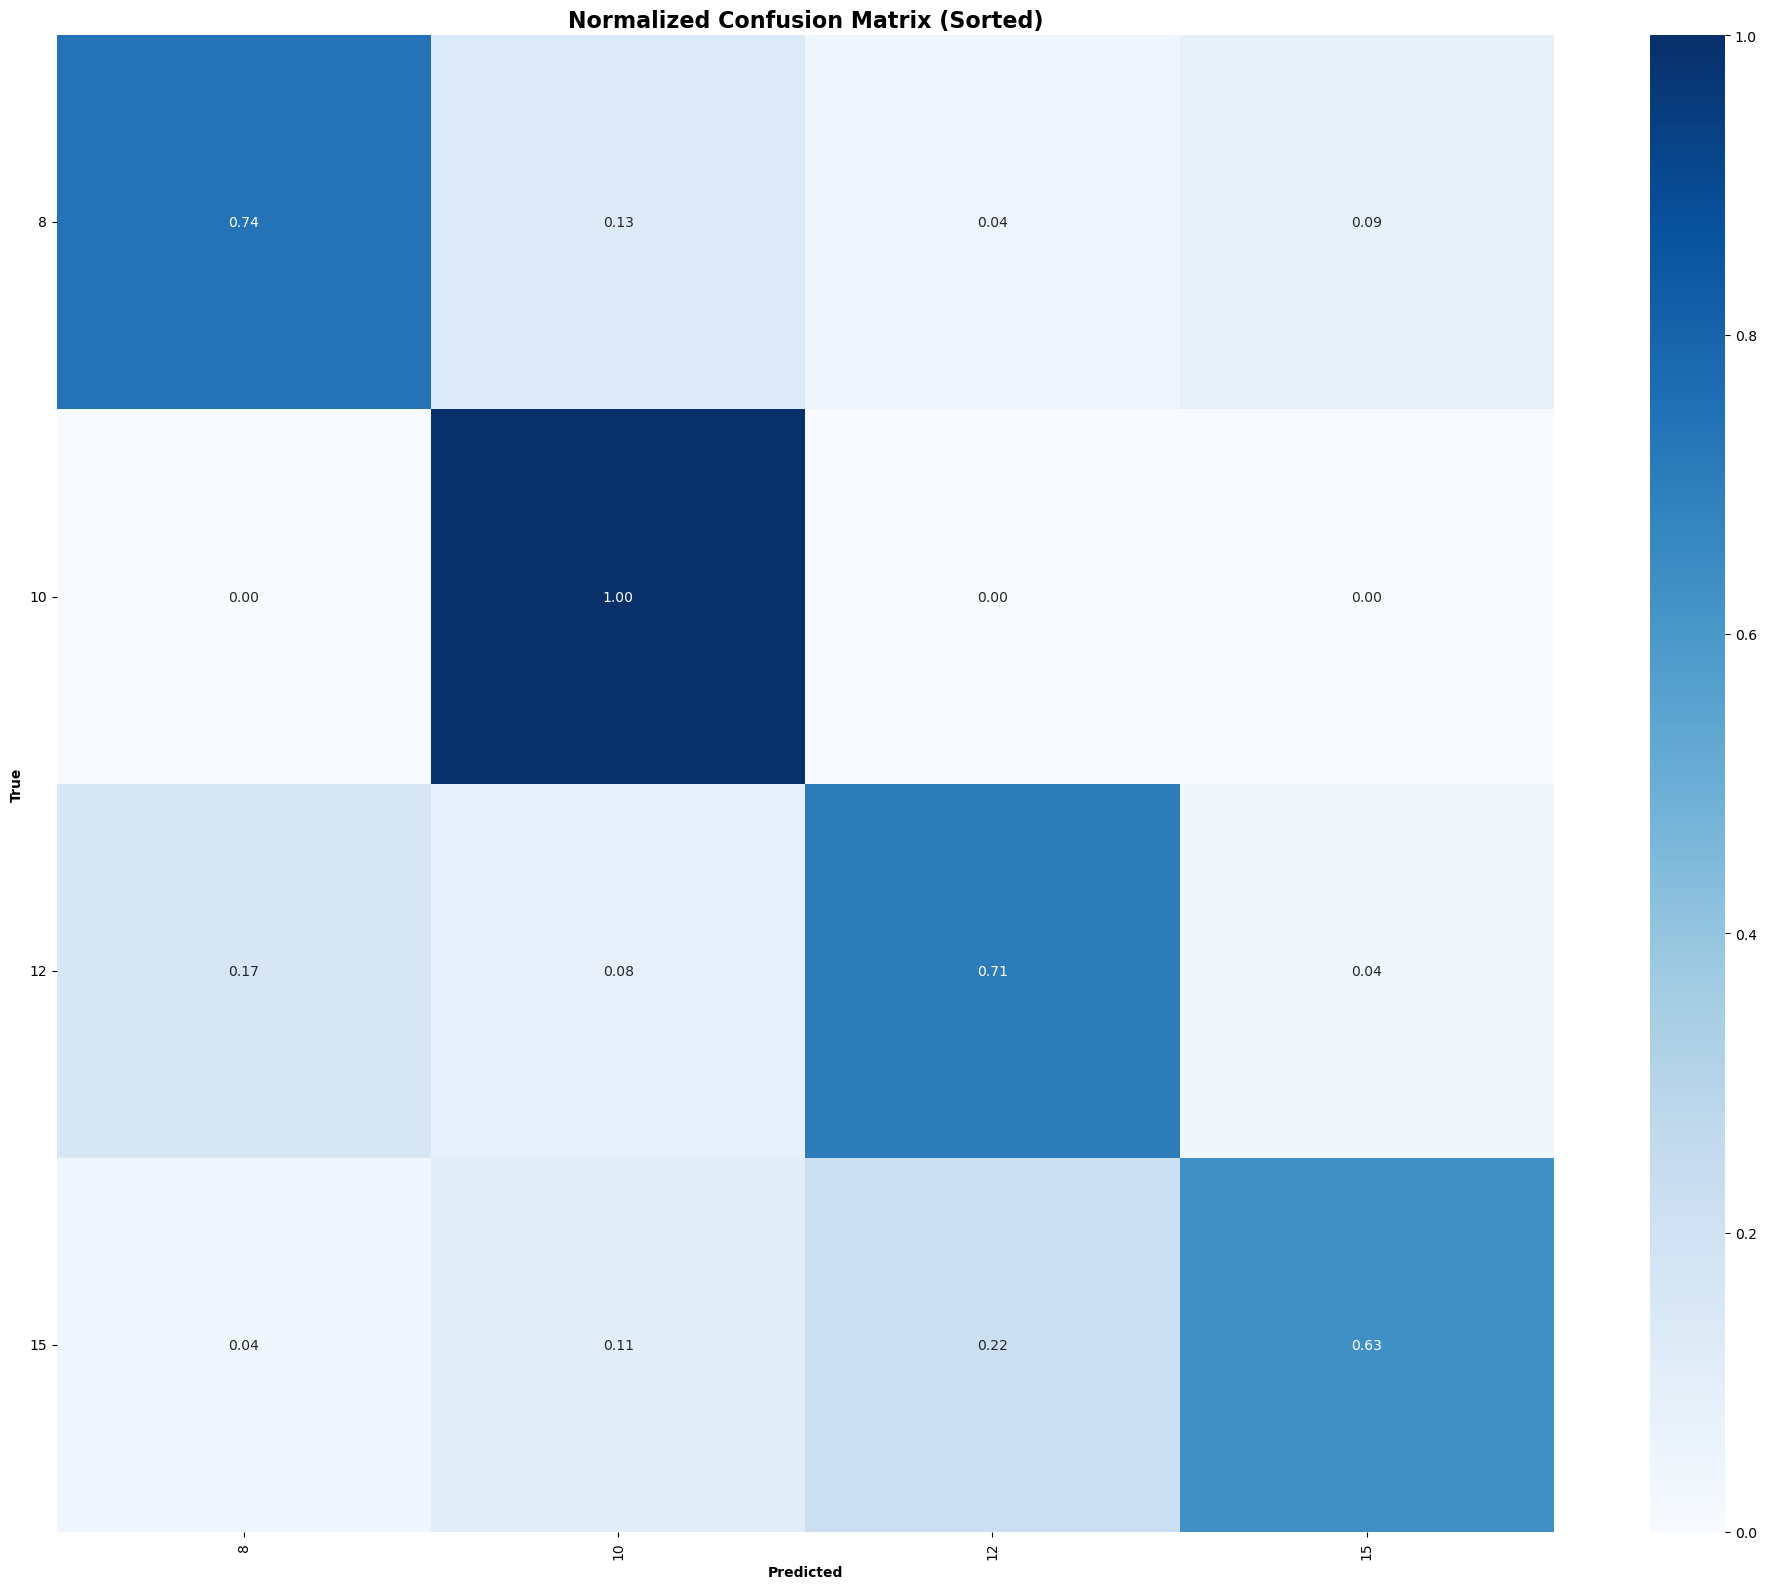

Test set Accuracy: 0.7604
Recall: 0.7604
F1 Score: 0.7555
Confusion Matrix:
[[17  3  1  2]
 [ 0 22  0  0]
 [ 4  2 17  1]
 [ 1  3  6 17]]
Running for subject S22 ---------------
Testing on subject 22.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.8750
Epoch 1/50: Train Loss: 1.2876, Train Accuracy: 0.3630, Val Loss: 0.6826, Val Accuracy: 0.8750
Validation loss decreased...
Best model saved with accuracy: 0.9583
Epoch 2/50: Train Loss: 0.7044, Train Accuracy: 0.7522, Val Loss: 0.2339, Val Accuracy: 0.9583
Validation loss decreased...
Best model saved with accuracy: 1.0000
Epoch 3/50: Train Loss: 0.5776, Train Accuracy: 0.7995, Val Loss: 0.1018, Val Accuracy: 1.0000
Validation loss decreased...
Epoch 4/50: Train Loss: 0.5198, Train Accuracy: 0.8169, Val Loss: 0.1965, Val Accuracy: 0.9167
Epoch 5/50: Train Loss: 0.4886, Train Accuracy: 0.8277, Val Loss: 0.0646, Val Accuracy: 1.0000
Validation loss decreased...
Epoch 6/50: Tr

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

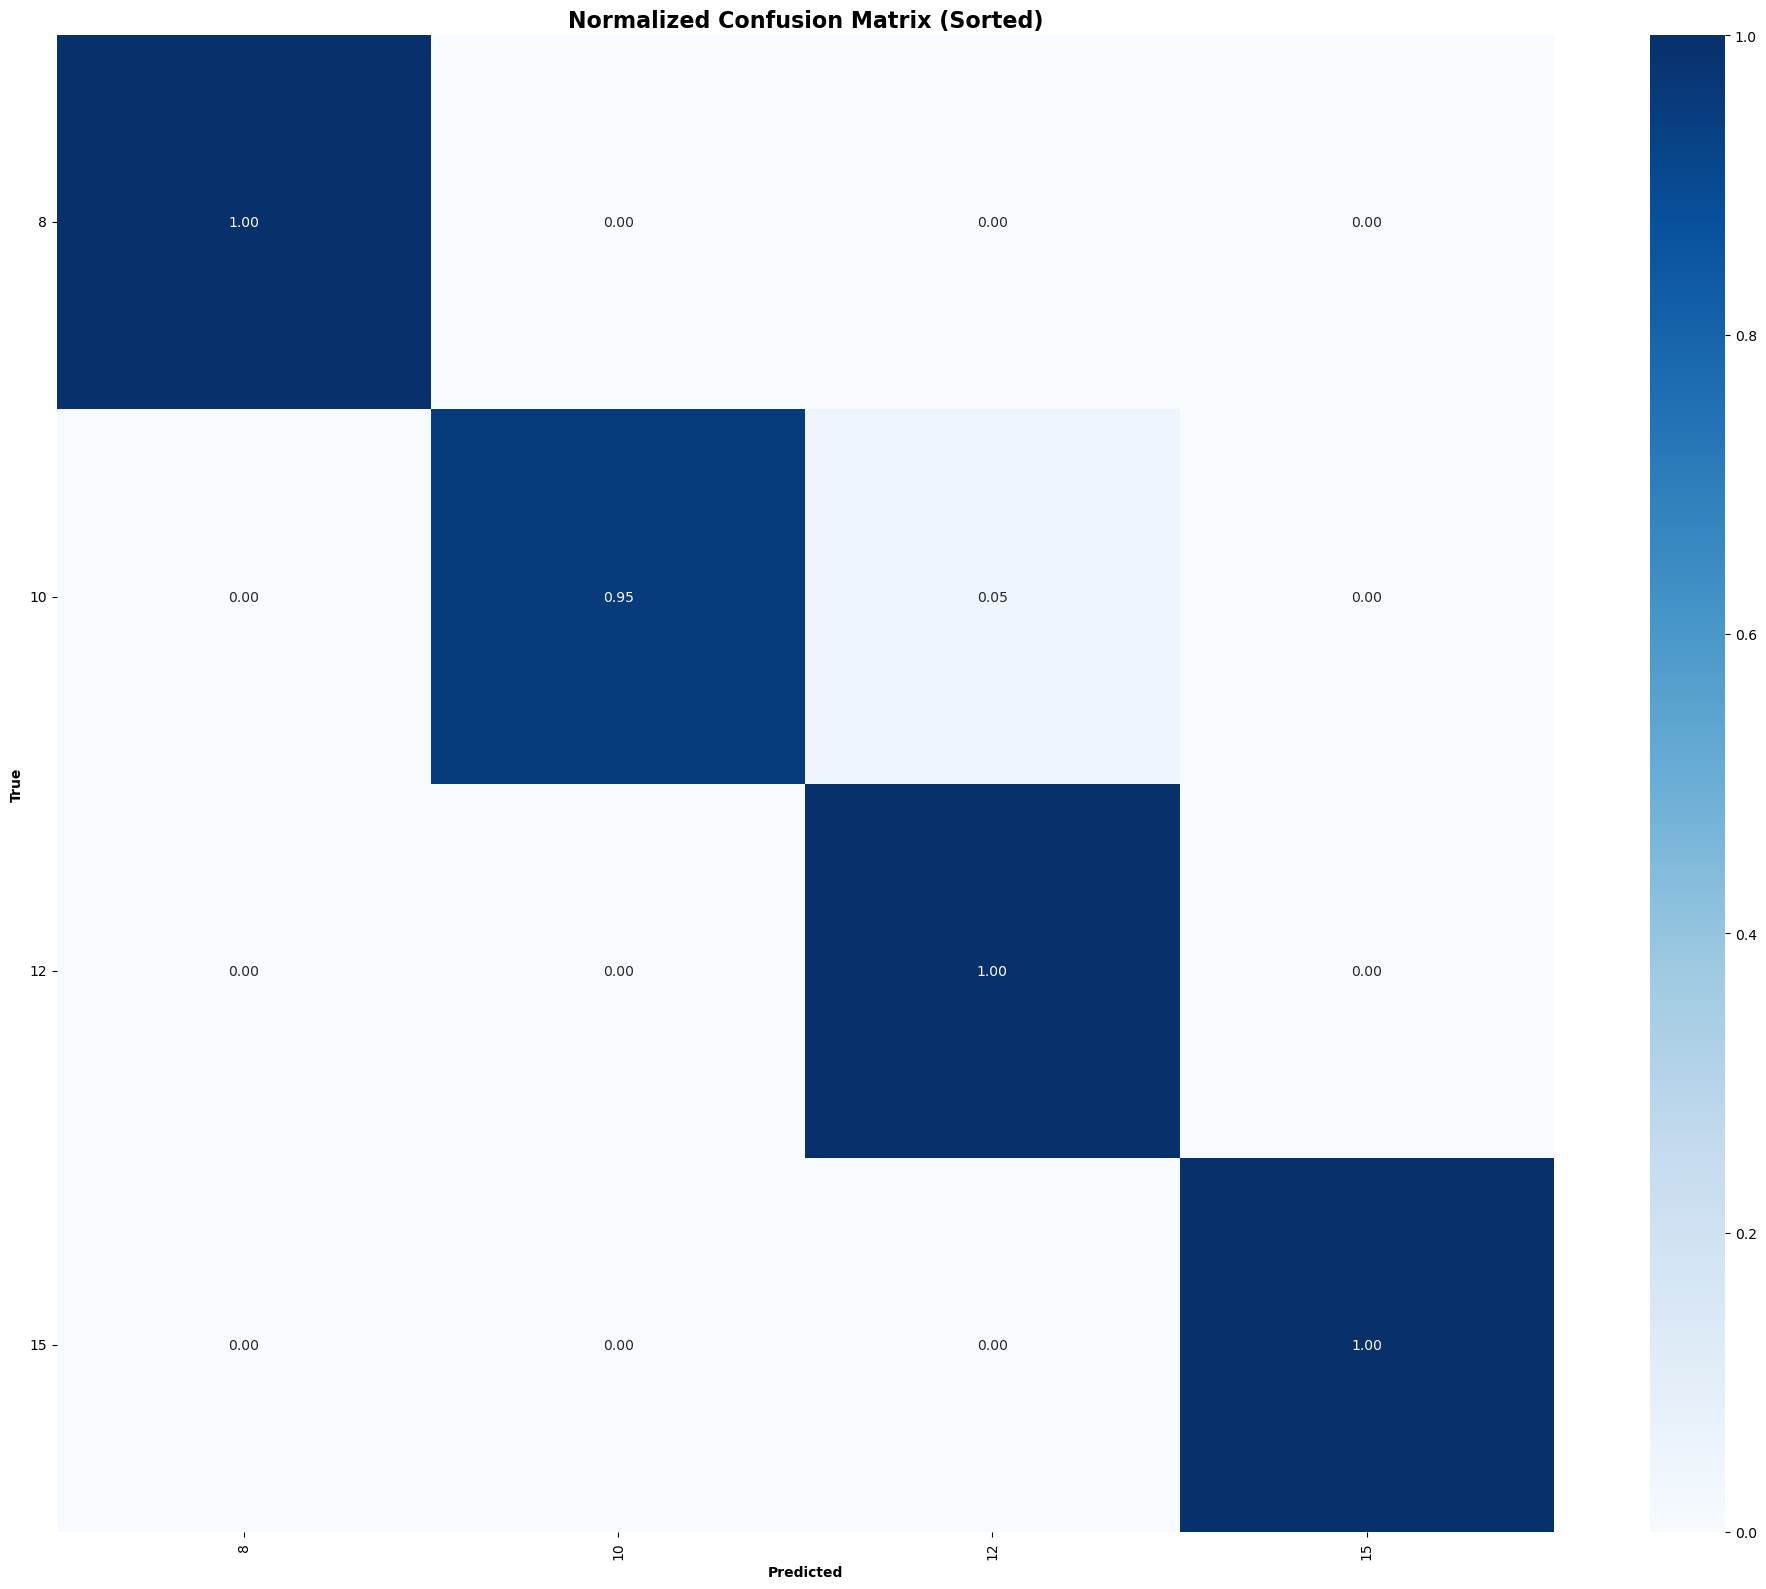

Test set Accuracy: 0.9896
Recall: 0.9896
F1 Score: 0.9896
Confusion Matrix:
[[23  0  0  0]
 [ 0 21  1  0]
 [ 0  0 24  0]
 [ 0  0  0 27]]
Running for subject S23 ---------------
Testing on subject 23.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.5833
Epoch 1/50: Train Loss: 1.2363, Train Accuracy: 0.3951, Val Loss: 1.0494, Val Accuracy: 0.5833
Validation loss decreased...
Best model saved with accuracy: 0.6667
Epoch 2/50: Train Loss: 0.6386, Train Accuracy: 0.7762, Val Loss: 0.9018, Val Accuracy: 0.6667
Validation loss decreased...
Epoch 3/50: Train Loss: 0.5150, Train Accuracy: 0.8189, Val Loss: 1.0196, Val Accuracy: 0.5417
Epoch 4/50: Train Loss: 0.4698, Train Accuracy: 0.8375, Val Loss: 0.9925, Val Accuracy: 0.5833
Epoch 5/50: Train Loss: 0.4420, Train Accuracy: 0.8498, Val Loss: 0.9370, Val Accuracy: 0.6250
Epoch 6/50: Train Loss: 0.4101, Train Accuracy: 0.8603, Val Loss: 1.1042, Val Accuracy: 0.5417
Epoch 7/50: Trai

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

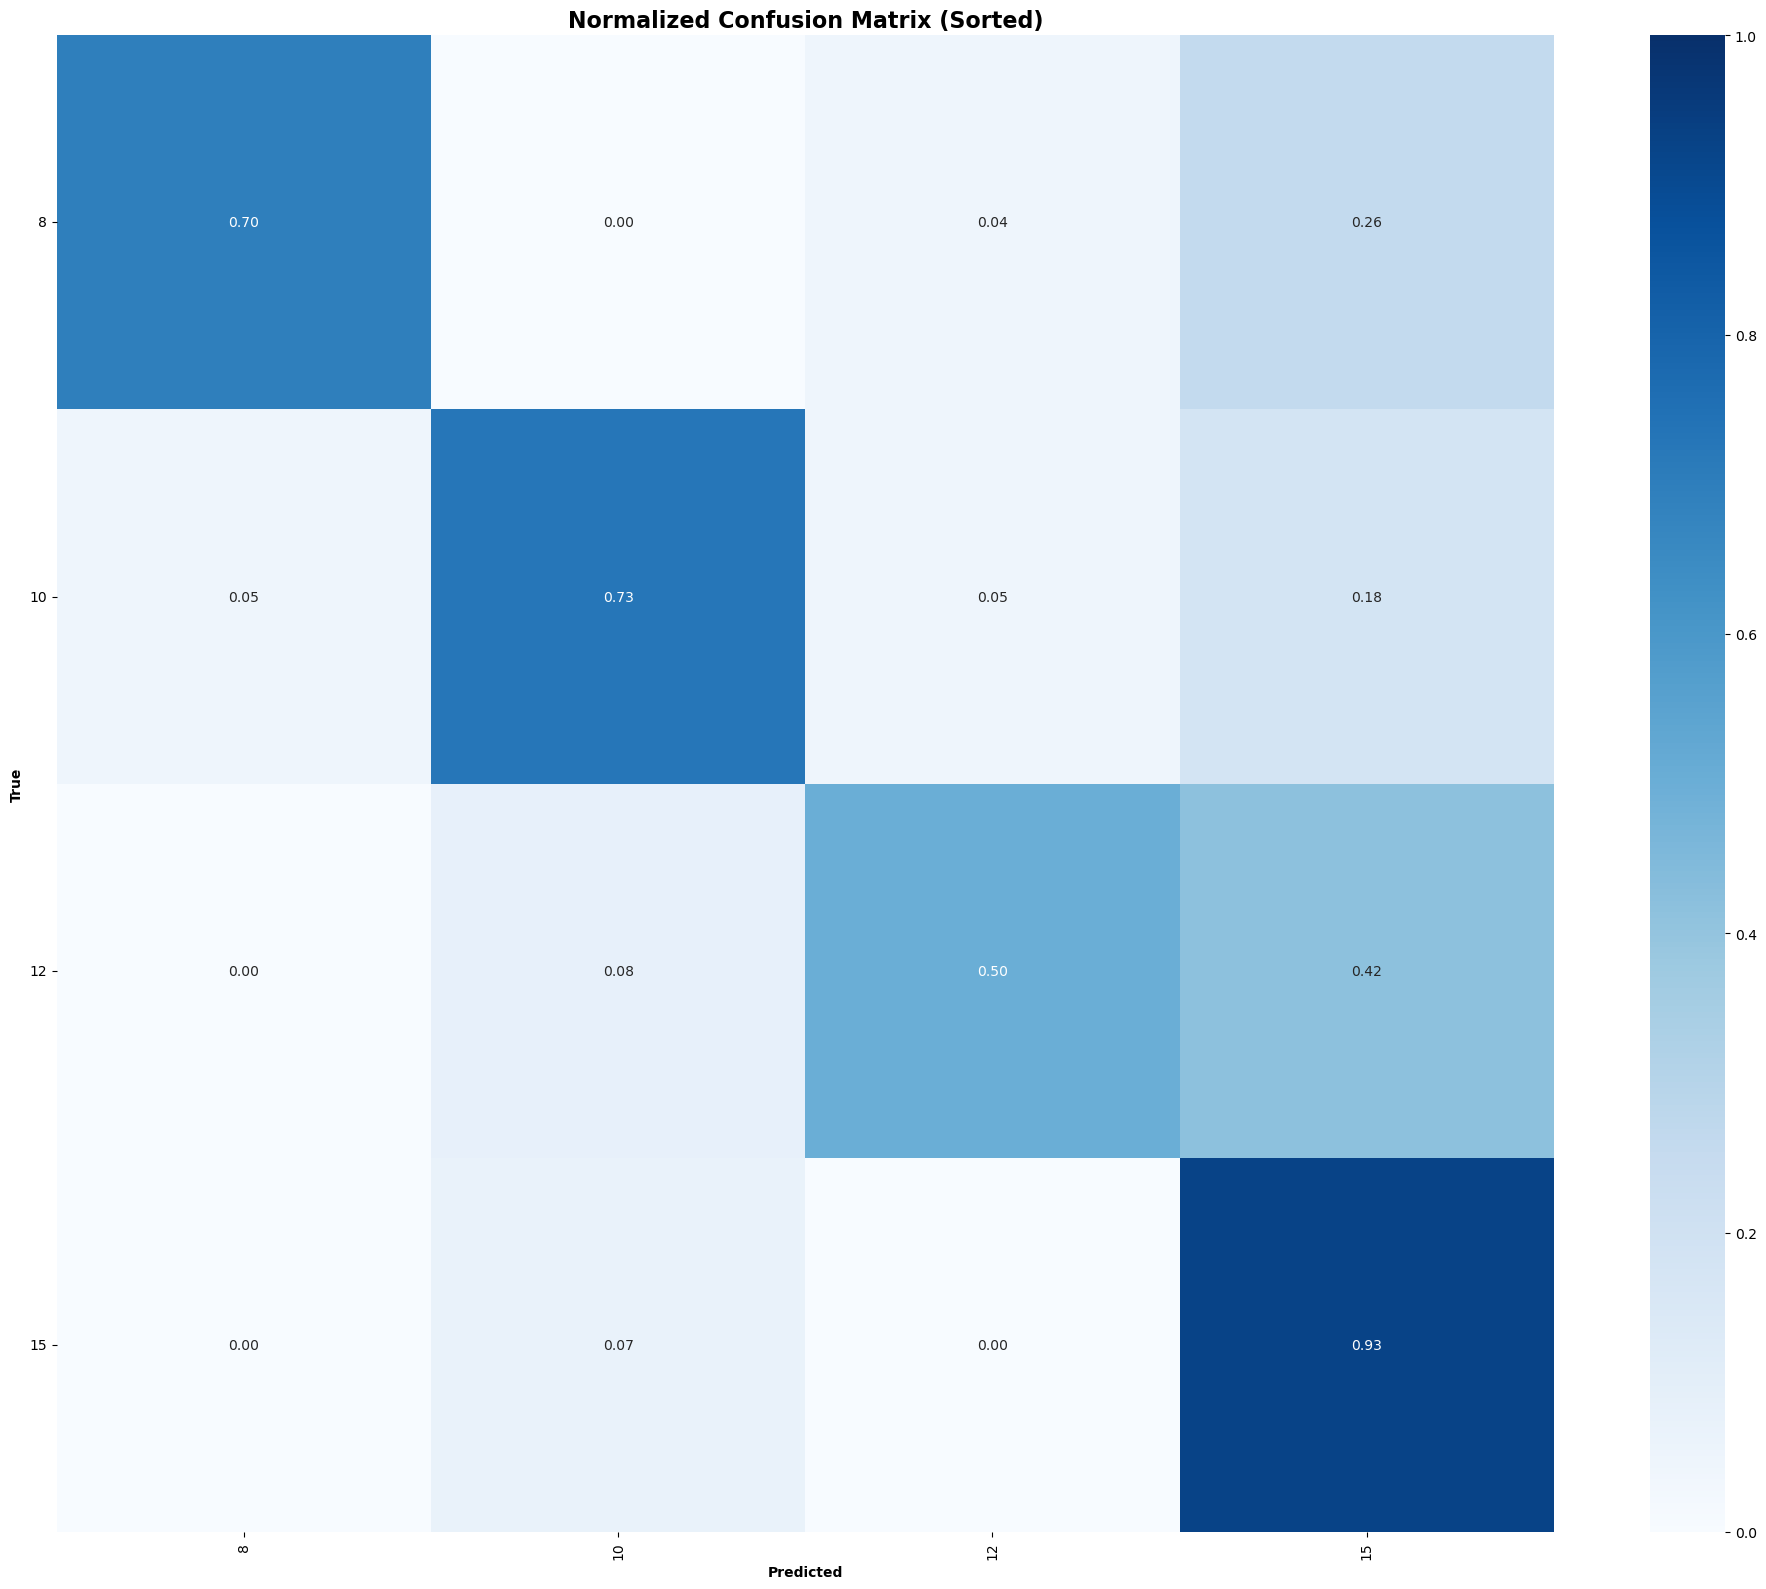

Test set Accuracy: 0.7188
Recall: 0.7188
F1 Score: 0.7195
Confusion Matrix:
[[16  0  1  6]
 [ 1 16  1  4]
 [ 0  2 12 10]
 [ 0  2  0 25]]
Running for subject S24 ---------------
Testing on subject 24.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.8333
Epoch 1/50: Train Loss: 1.2587, Train Accuracy: 0.3895, Val Loss: 0.8273, Val Accuracy: 0.8333
Validation loss decreased...
Best model saved with accuracy: 0.9583
Epoch 2/50: Train Loss: 0.7692, Train Accuracy: 0.7120, Val Loss: 0.4660, Val Accuracy: 0.9583
Validation loss decreased...
Epoch 3/50: Train Loss: 0.5921, Train Accuracy: 0.7873, Val Loss: 0.3767, Val Accuracy: 0.9583
Validation loss decreased...
Epoch 4/50: Train Loss: 0.5528, Train Accuracy: 0.8137, Val Loss: 0.2893, Val Accuracy: 0.9167
Validation loss decreased...
Best model saved with accuracy: 1.0000
Epoch 5/50: Train Loss: 0.4934, Train Accuracy: 0.8243, Val Loss: 0.1897, Val Accuracy: 1.0000
Validation los

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

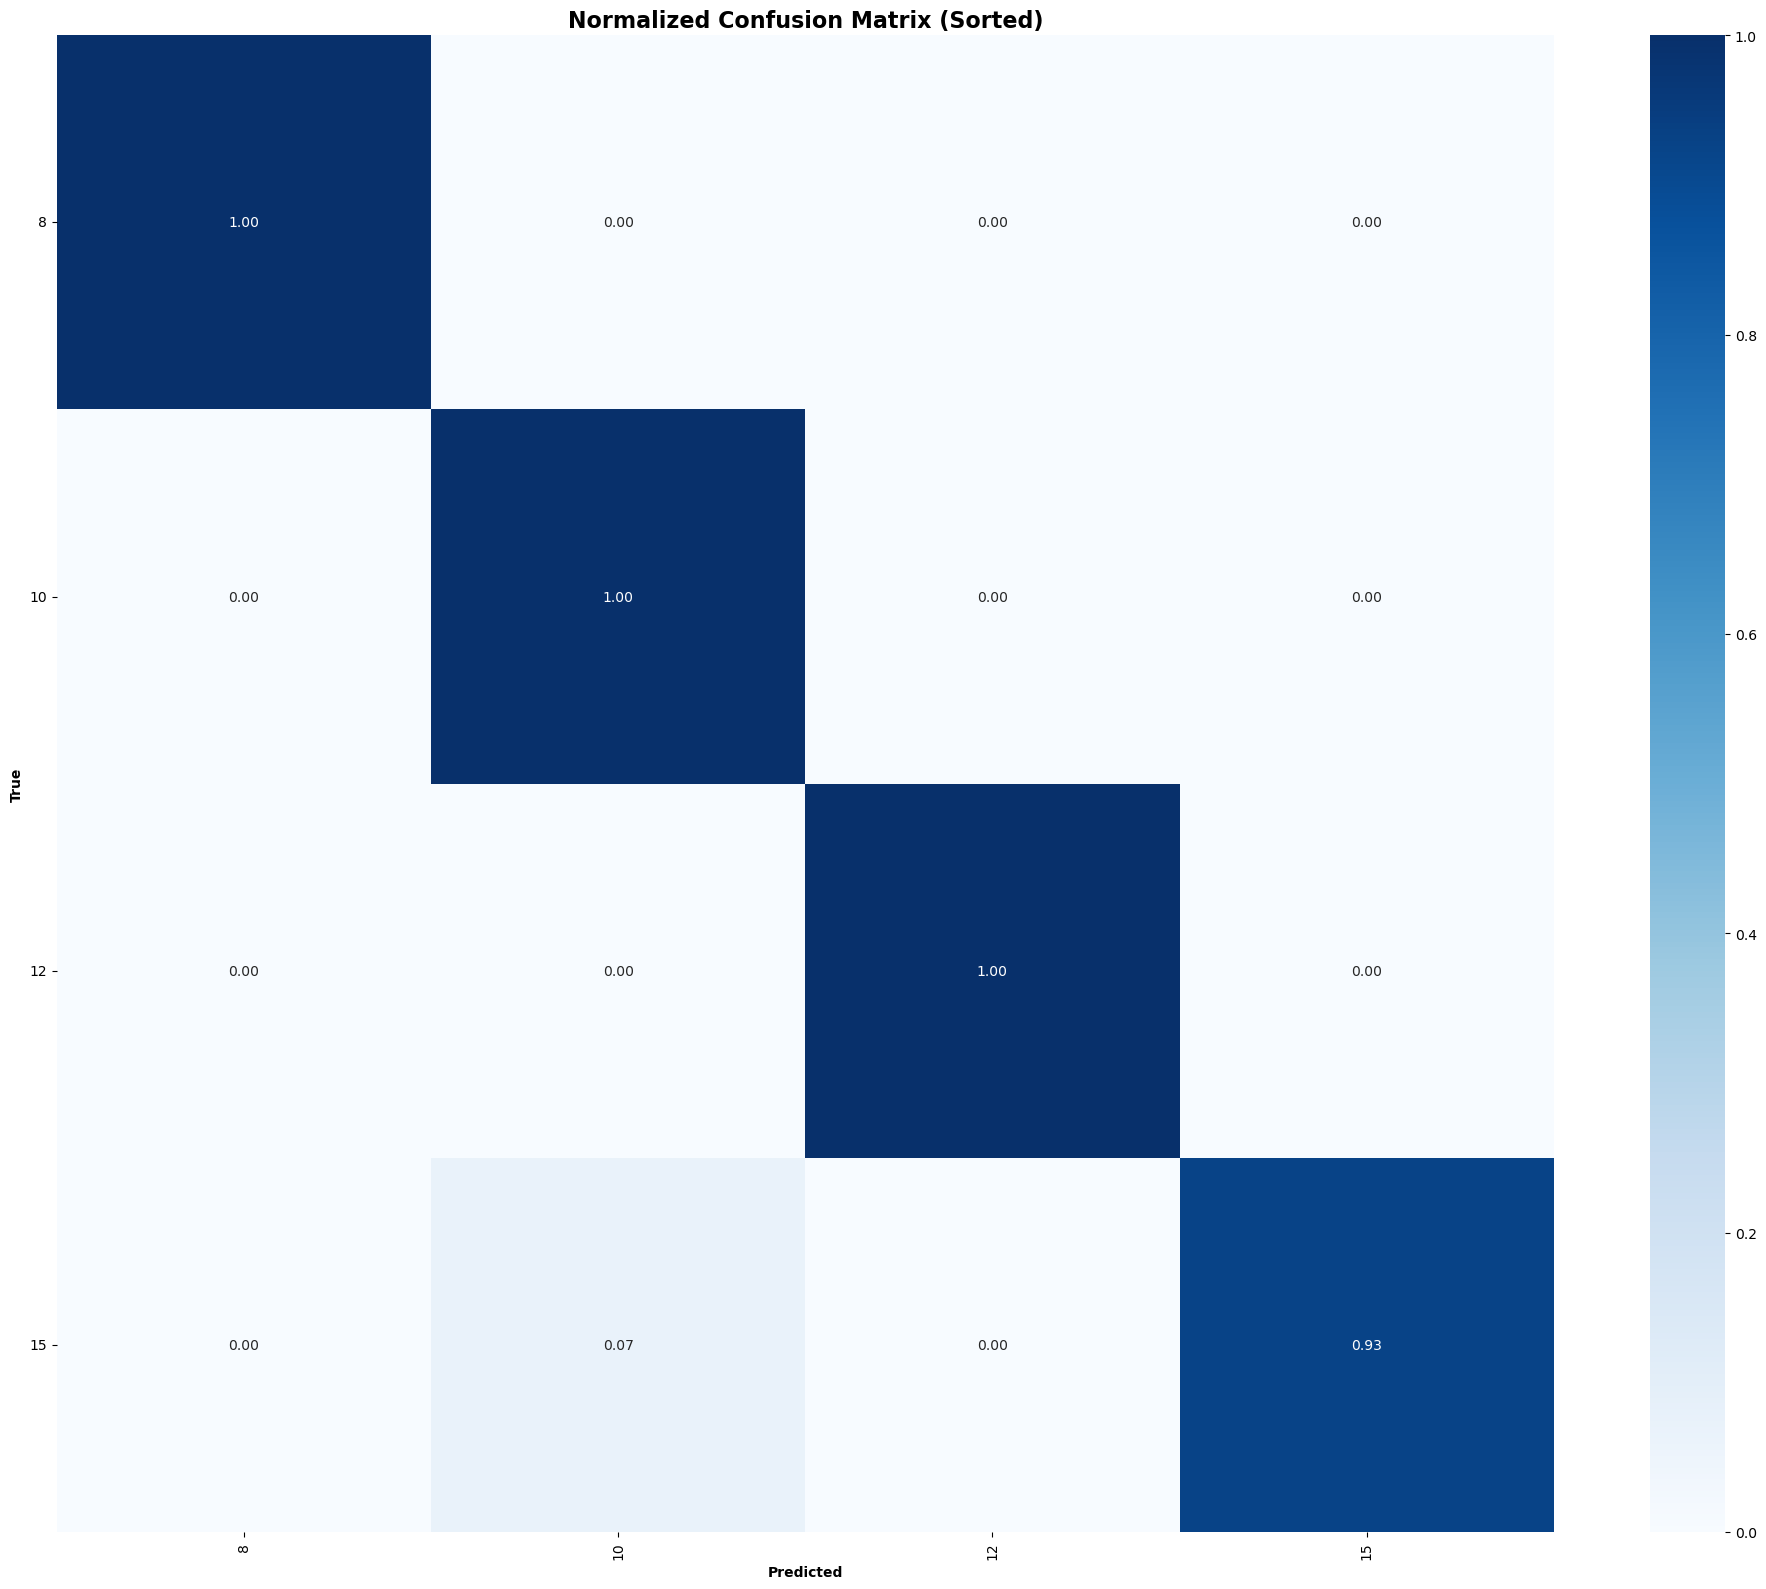

Test set Accuracy: 0.9792
Recall: 0.9792
F1 Score: 0.9792
Confusion Matrix:
[[23  0  0  0]
 [ 0 22  0  0]
 [ 0  0 24  0]
 [ 0  2  0 25]]
Running for subject S25 ---------------
Testing on subject 25.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.8333
Epoch 1/50: Train Loss: 1.2299, Train Accuracy: 0.4142, Val Loss: 0.5640, Val Accuracy: 0.8333
Validation loss decreased...
Best model saved with accuracy: 0.9583
Epoch 2/50: Train Loss: 0.7412, Train Accuracy: 0.7289, Val Loss: 0.1992, Val Accuracy: 0.9583
Validation loss decreased...
Epoch 3/50: Train Loss: 0.5785, Train Accuracy: 0.7980, Val Loss: 0.1842, Val Accuracy: 0.9583
Validation loss decreased...
Epoch 4/50: Train Loss: 0.5281, Train Accuracy: 0.8159, Val Loss: 0.1971, Val Accuracy: 0.9167
Epoch 5/50: Train Loss: 0.4827, Train Accuracy: 0.8289, Val Loss: 0.2844, Val Accuracy: 0.9583
Best model saved with accuracy: 1.0000
Epoch 6/50: Train Loss: 0.4673, Train Accur

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

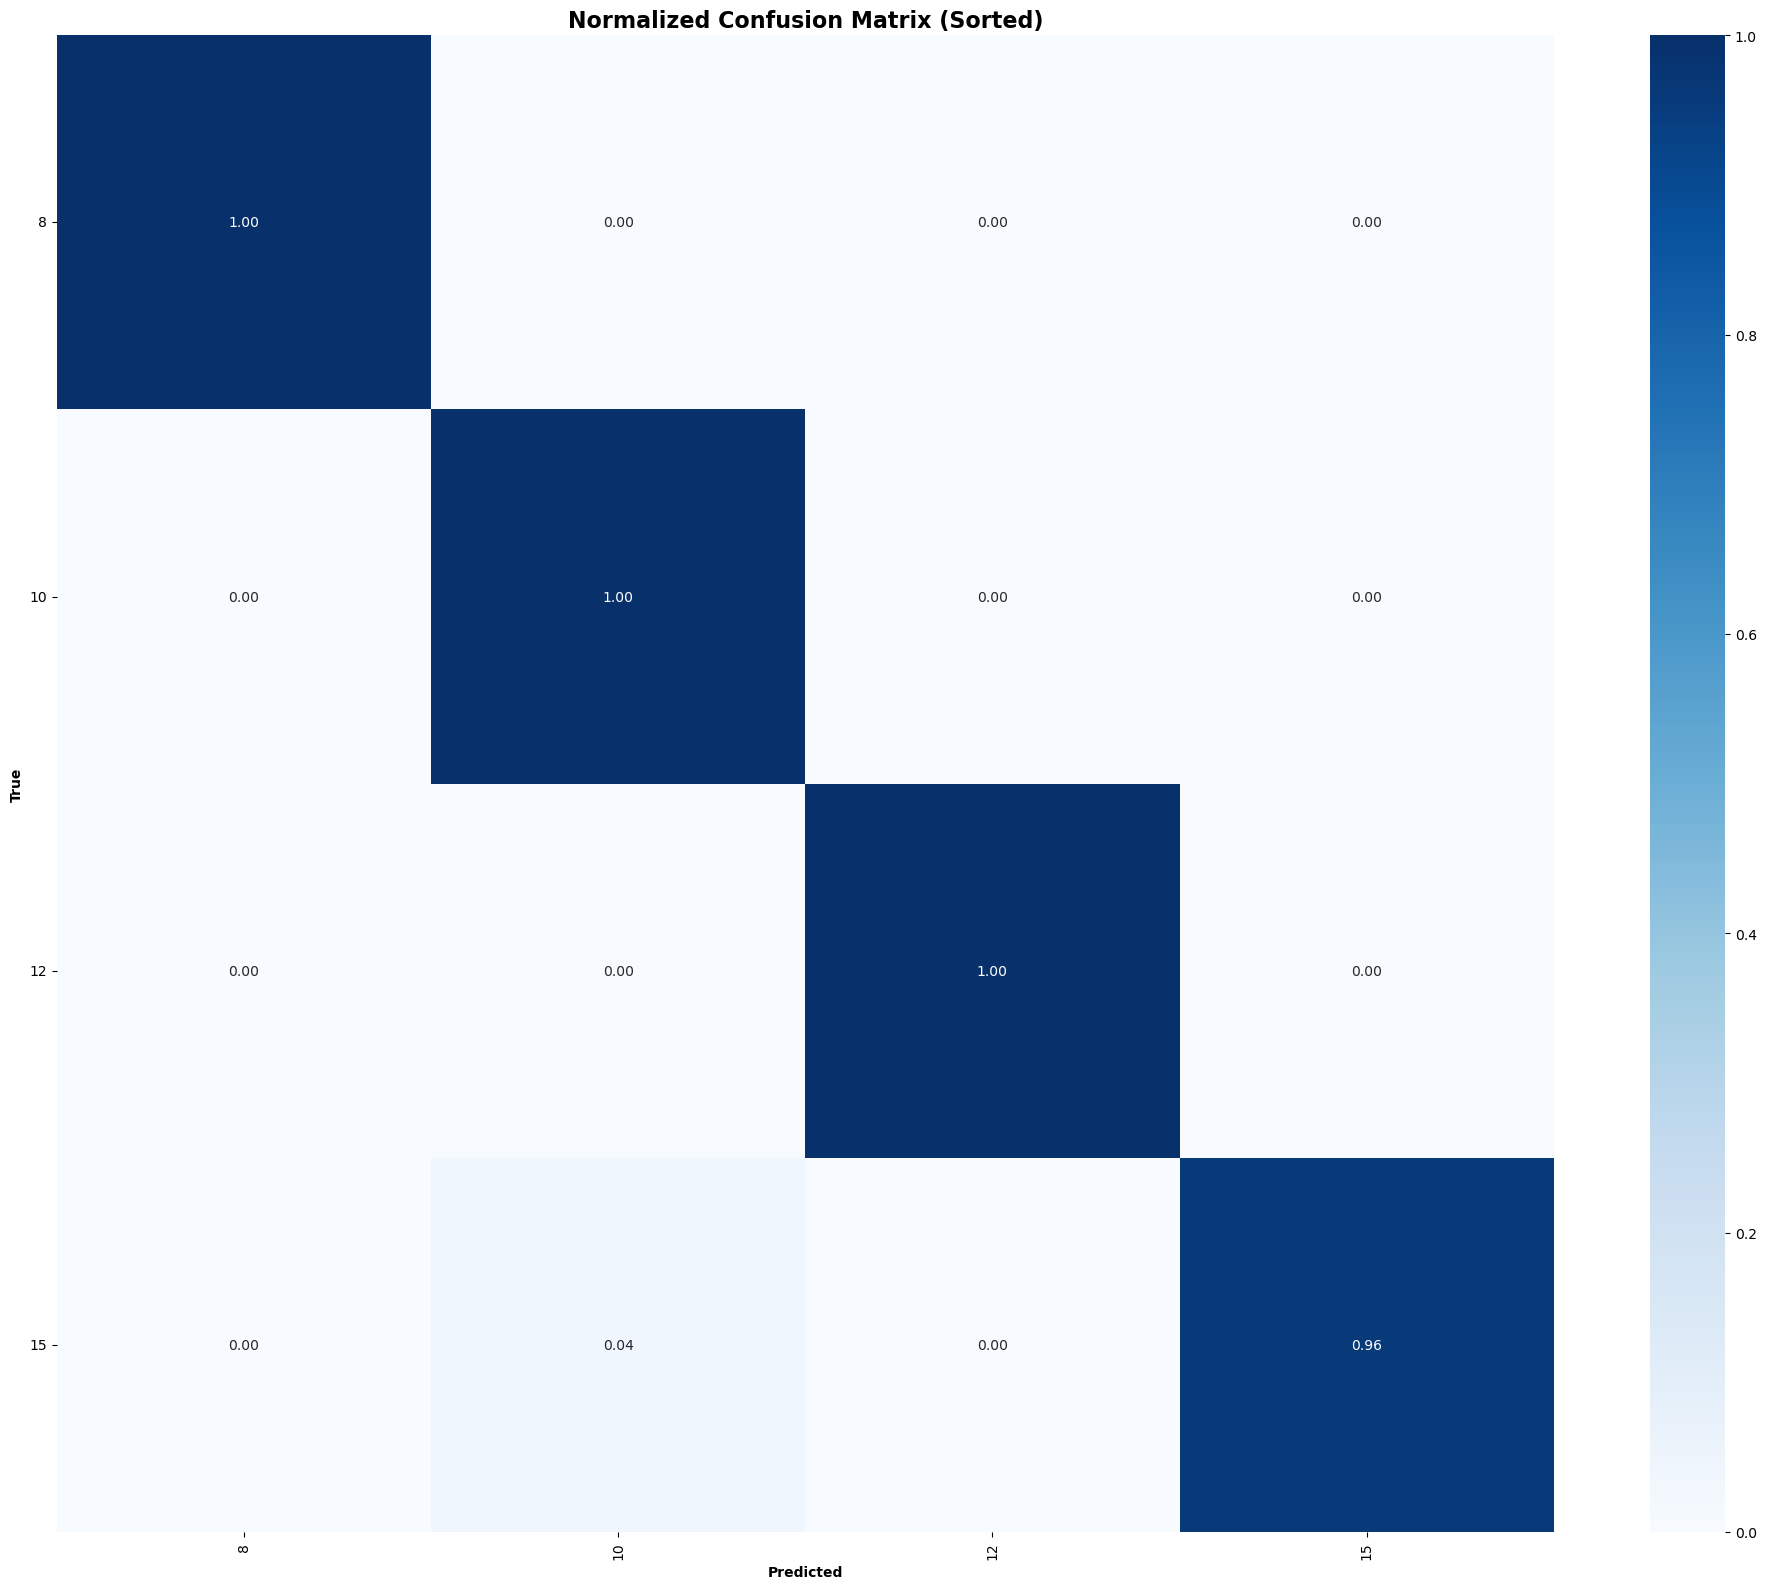

Test set Accuracy: 0.9896
Recall: 0.9896
F1 Score: 0.9896
Confusion Matrix:
[[23  0  0  0]
 [ 0 22  0  0]
 [ 0  0 24  0]
 [ 0  1  0 26]]
Running for subject S26 ---------------
Testing on subject 26.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.9583
Epoch 1/50: Train Loss: 1.3701, Train Accuracy: 0.2863, Val Loss: 1.1189, Val Accuracy: 0.9583
Validation loss decreased...
Epoch 2/50: Train Loss: 0.8645, Train Accuracy: 0.6775, Val Loss: 0.3936, Val Accuracy: 0.9167
Validation loss decreased...
Epoch 3/50: Train Loss: 0.6018, Train Accuracy: 0.7931, Val Loss: 0.3669, Val Accuracy: 0.9167
Validation loss decreased...
Epoch 4/50: Train Loss: 0.5164, Train Accuracy: 0.8201, Val Loss: 0.3459, Val Accuracy: 0.8750
Validation loss decreased...
Epoch 5/50: Train Loss: 0.4932, Train Accuracy: 0.8257, Val Loss: 0.4878, Val Accuracy: 0.9167
Epoch 6/50: Train Loss: 0.4770, Train Accuracy: 0.8311, Val Loss: 0.2741, Val Accuracy: 0.91

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

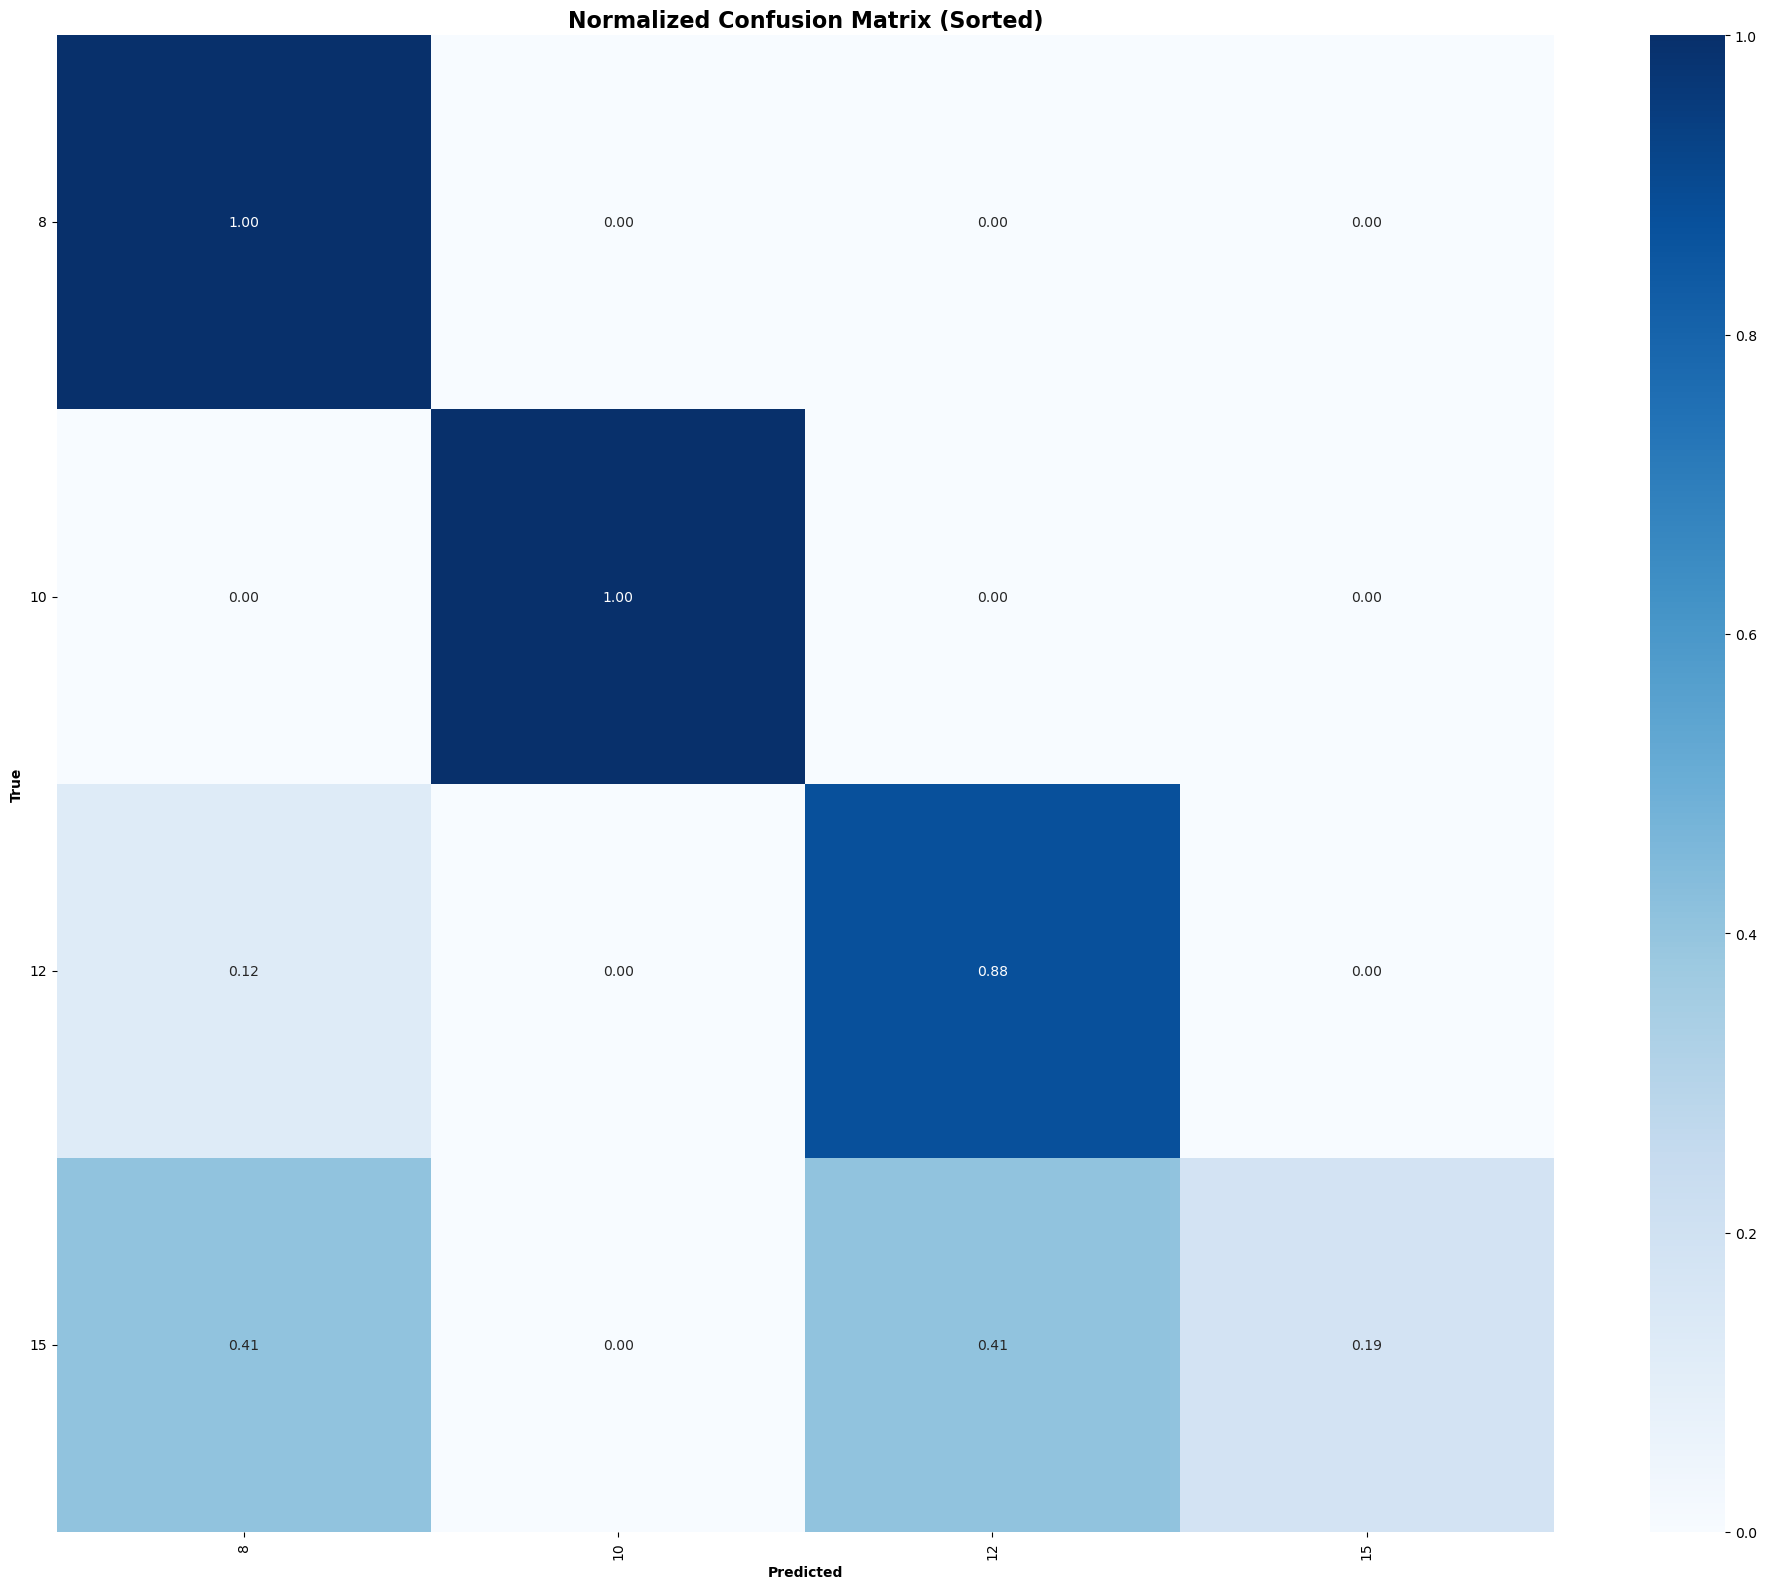

Test set Accuracy: 0.7396
Recall: 0.7396
F1 Score: 0.6882
Confusion Matrix:
[[23  0  0  0]
 [ 0 22  0  0]
 [ 3  0 21  0]
 [11  0 11  5]]
Running for subject S27 ---------------
Testing on subject 27.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.8750
Epoch 1/50: Train Loss: 1.1934, Train Accuracy: 0.4493, Val Loss: 0.6502, Val Accuracy: 0.8750
Validation loss decreased...
Best model saved with accuracy: 0.9583
Epoch 2/50: Train Loss: 0.7292, Train Accuracy: 0.7468, Val Loss: 0.3747, Val Accuracy: 0.9583
Validation loss decreased...
Epoch 3/50: Train Loss: 0.6017, Train Accuracy: 0.7953, Val Loss: 0.3127, Val Accuracy: 0.9167
Validation loss decreased...
Epoch 4/50: Train Loss: 0.5328, Train Accuracy: 0.8110, Val Loss: 0.2647, Val Accuracy: 0.9167
Validation loss decreased...
Epoch 5/50: Train Loss: 0.4825, Train Accuracy: 0.8289, Val Loss: 0.1688, Val Accuracy: 0.9583
Validation loss decreased...
Epoch 6/50: Train Loss: 

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

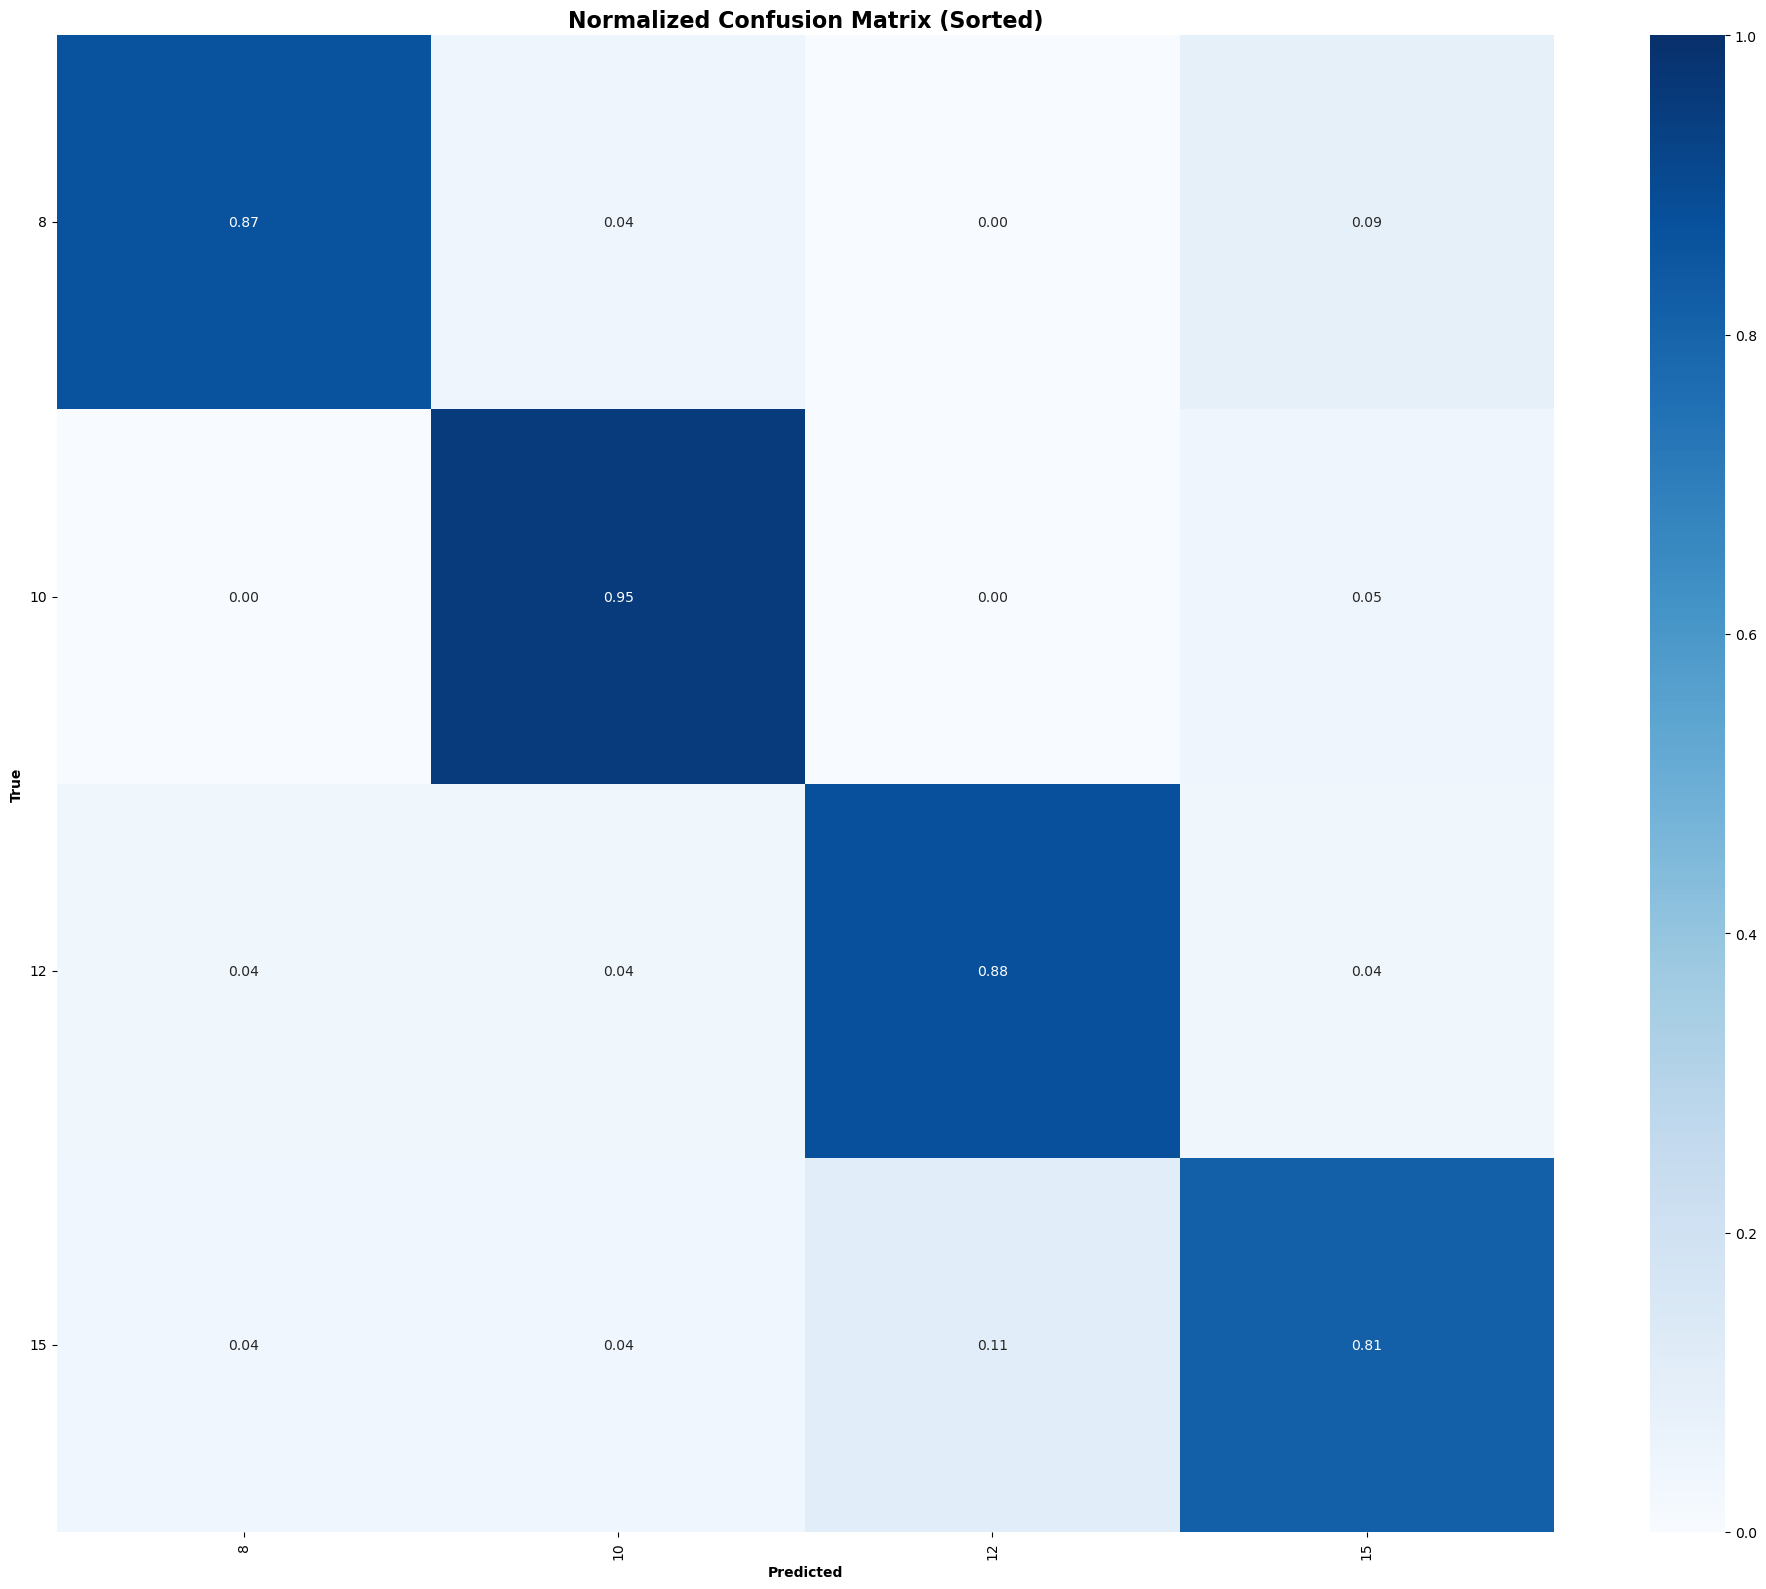

Test set Accuracy: 0.8750
Recall: 0.8750
F1 Score: 0.8744
Confusion Matrix:
[[20  1  0  2]
 [ 0 21  0  1]
 [ 1  1 21  1]
 [ 1  1  3 22]]
Running for subject S28 ---------------
Testing on subject 28.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.7917
Epoch 1/50: Train Loss: 1.2971, Train Accuracy: 0.3525, Val Loss: 0.9118, Val Accuracy: 0.7917
Validation loss decreased...
Best model saved with accuracy: 0.9583
Epoch 2/50: Train Loss: 0.7830, Train Accuracy: 0.7091, Val Loss: 0.6340, Val Accuracy: 0.9583
Validation loss decreased...
Epoch 3/50: Train Loss: 0.6048, Train Accuracy: 0.7900, Val Loss: 0.5155, Val Accuracy: 0.9583
Validation loss decreased...
Epoch 4/50: Train Loss: 0.5630, Train Accuracy: 0.8044, Val Loss: 0.4703, Val Accuracy: 0.9583
Validation loss decreased...
Epoch 5/50: Train Loss: 0.5028, Train Accuracy: 0.8287, Val Loss: 0.3969, Val Accuracy: 0.9583
Validation loss decreased...
Epoch 6/50: Train Loss: 

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

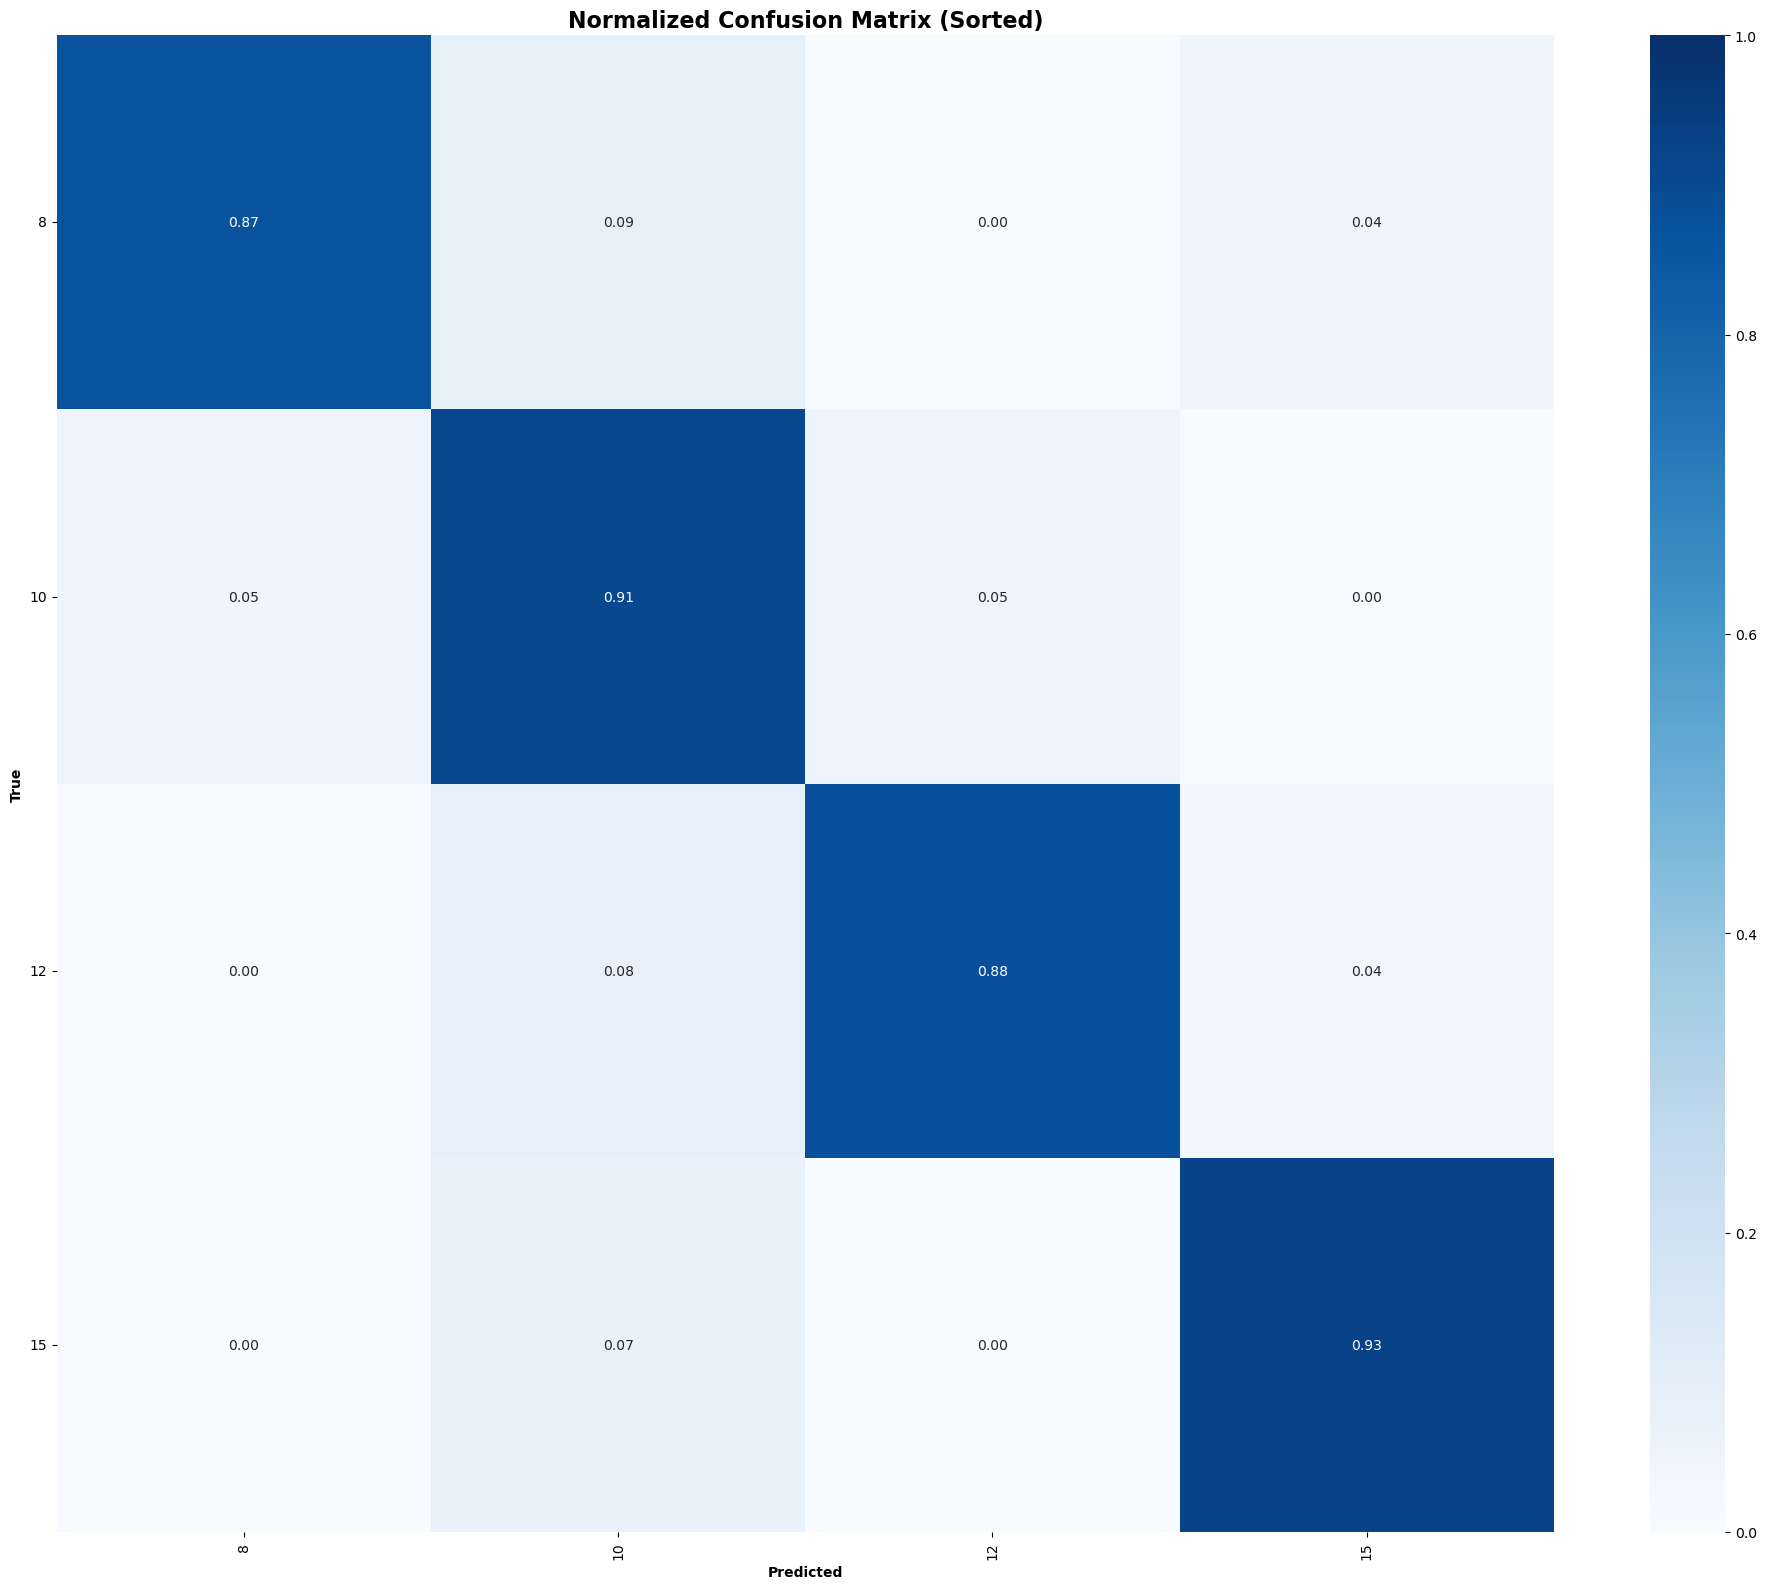

Test set Accuracy: 0.8958
Recall: 0.8958
F1 Score: 0.8975
Confusion Matrix:
[[20  2  0  1]
 [ 1 20  1  0]
 [ 0  2 21  1]
 [ 0  2  0 25]]
Running for subject S29 ---------------
Testing on subject 29.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.7083
Epoch 1/50: Train Loss: 1.2919, Train Accuracy: 0.3703, Val Loss: 1.0688, Val Accuracy: 0.7083
Validation loss decreased...
Epoch 2/50: Train Loss: 0.7950, Train Accuracy: 0.6941, Val Loss: 0.9073, Val Accuracy: 0.6667
Validation loss decreased...
Epoch 3/50: Train Loss: 0.5790, Train Accuracy: 0.7961, Val Loss: 0.7887, Val Accuracy: 0.6667
Validation loss decreased...
Best model saved with accuracy: 0.7500
Epoch 4/50: Train Loss: 0.5268, Train Accuracy: 0.8184, Val Loss: 0.8127, Val Accuracy: 0.7500
Epoch 5/50: Train Loss: 0.4915, Train Accuracy: 0.8316, Val Loss: 0.8480, Val Accuracy: 0.7500
Epoch 6/50: Train Loss: 0.4708, Train Accuracy: 0.8368, Val Loss: 0.8506, Val Accu

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

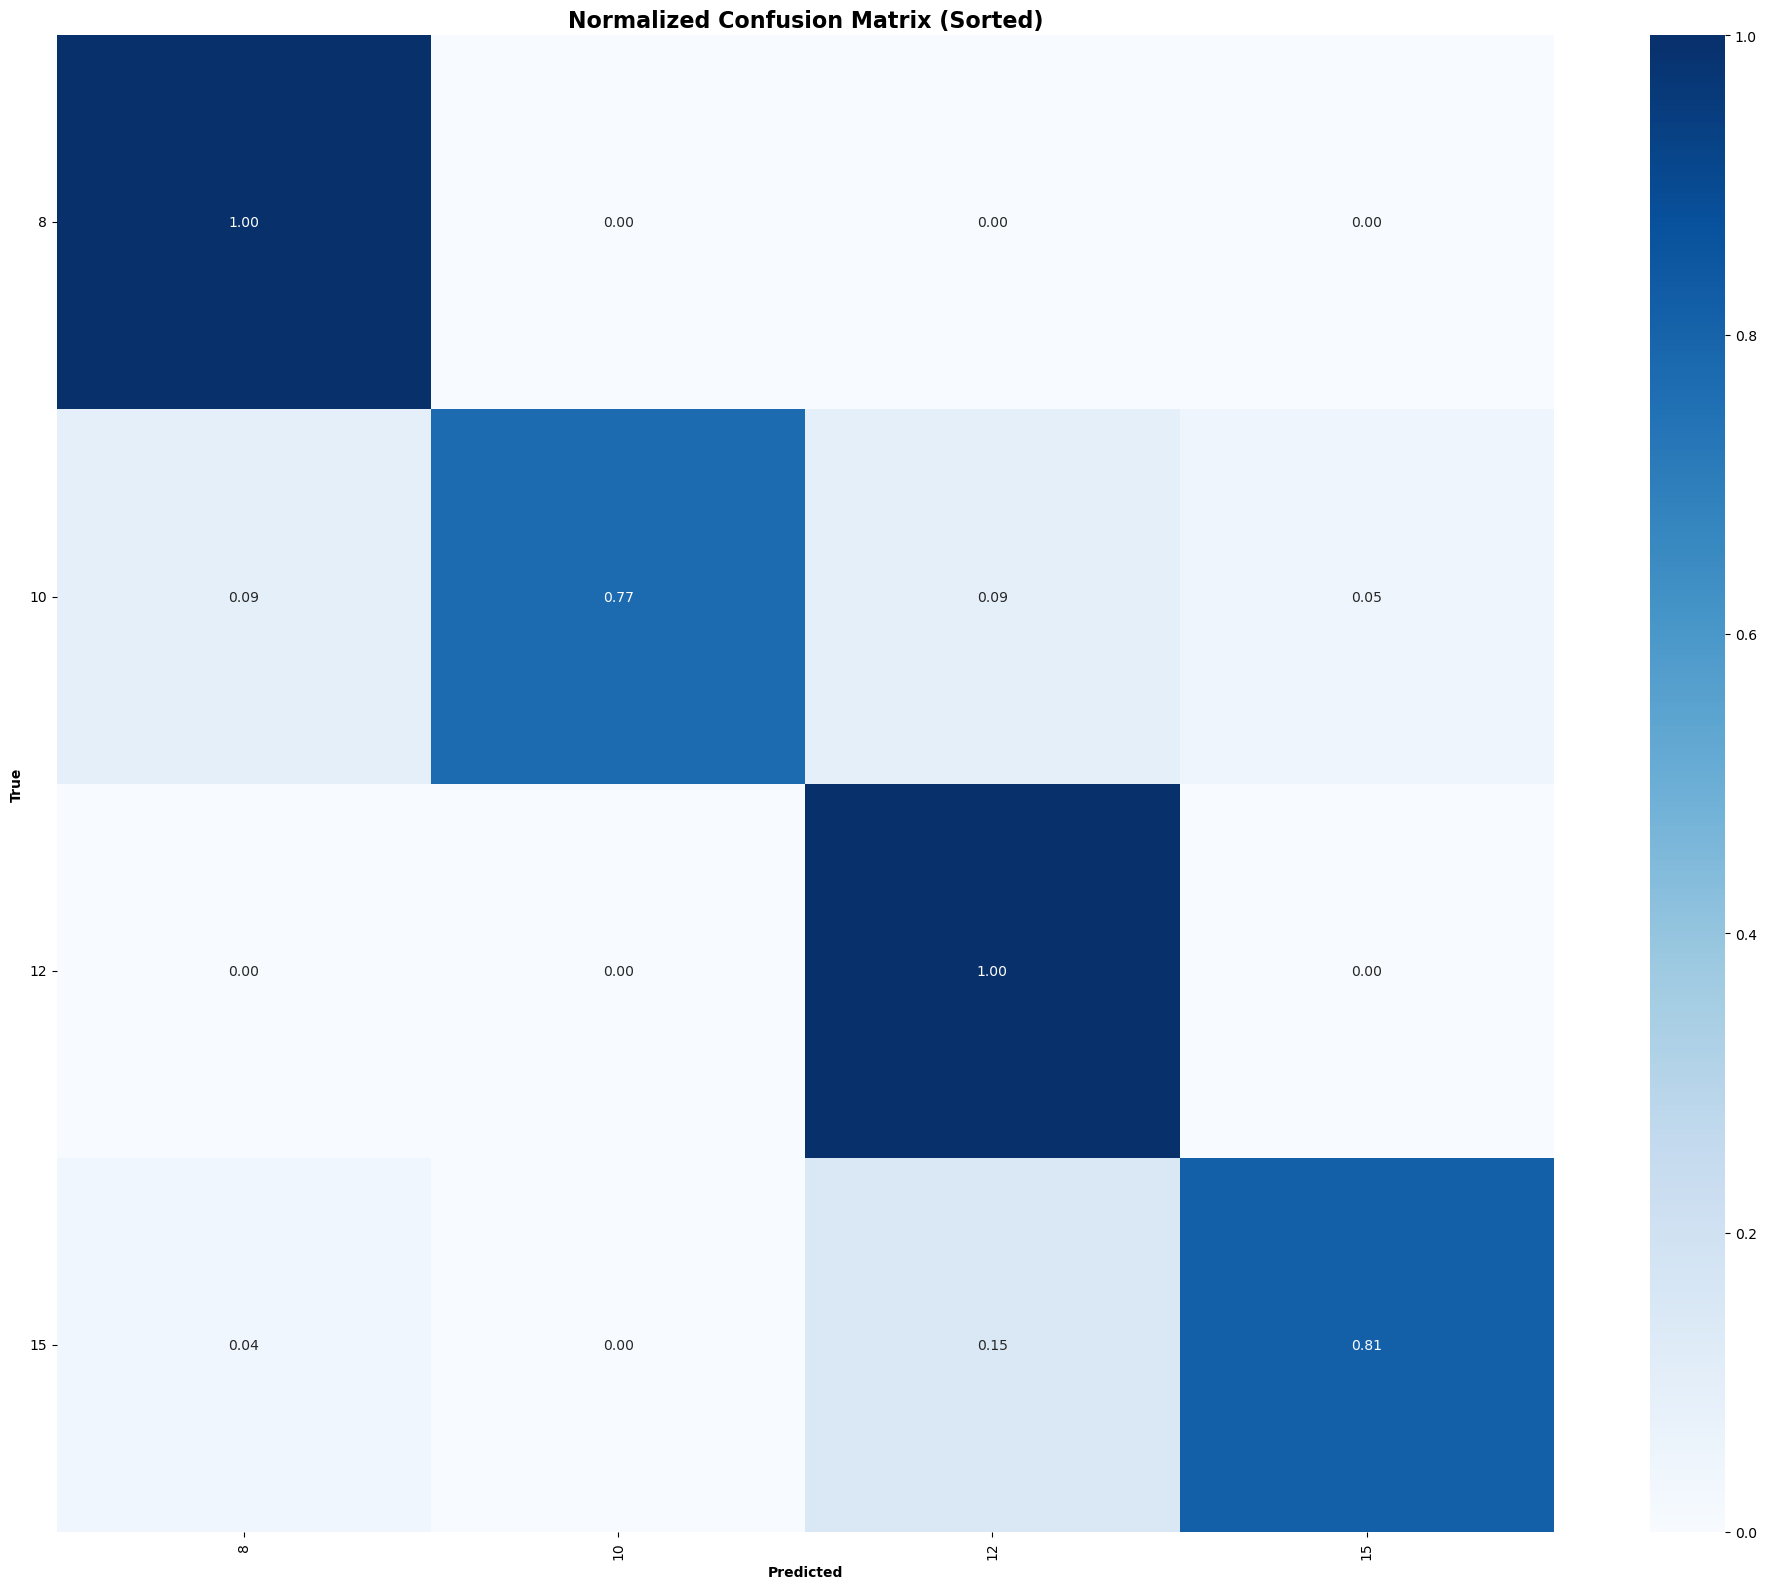

Test set Accuracy: 0.8958
Recall: 0.8958
F1 Score: 0.8944
Confusion Matrix:
[[23  0  0  0]
 [ 2 17  2  1]
 [ 0  0 24  0]
 [ 1  0  4 22]]
Running for subject S30 ---------------
Testing on subject 30.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.7083
Epoch 1/50: Train Loss: 1.3077, Train Accuracy: 0.3414, Val Loss: 0.8933, Val Accuracy: 0.7083
Validation loss decreased...
Best model saved with accuracy: 0.7500
Epoch 2/50: Train Loss: 0.7596, Train Accuracy: 0.7201, Val Loss: 0.6078, Val Accuracy: 0.7500
Validation loss decreased...
Best model saved with accuracy: 0.7917
Epoch 3/50: Train Loss: 0.5594, Train Accuracy: 0.8034, Val Loss: 0.5821, Val Accuracy: 0.7917
Validation loss decreased...
Best model saved with accuracy: 0.8333
Epoch 4/50: Train Loss: 0.5135, Train Accuracy: 0.8230, Val Loss: 0.4523, Val Accuracy: 0.8333
Validation loss decreased...
Epoch 5/50: Train Loss: 0.4757, Train Accuracy: 0.8382, Val Loss: 0.59

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

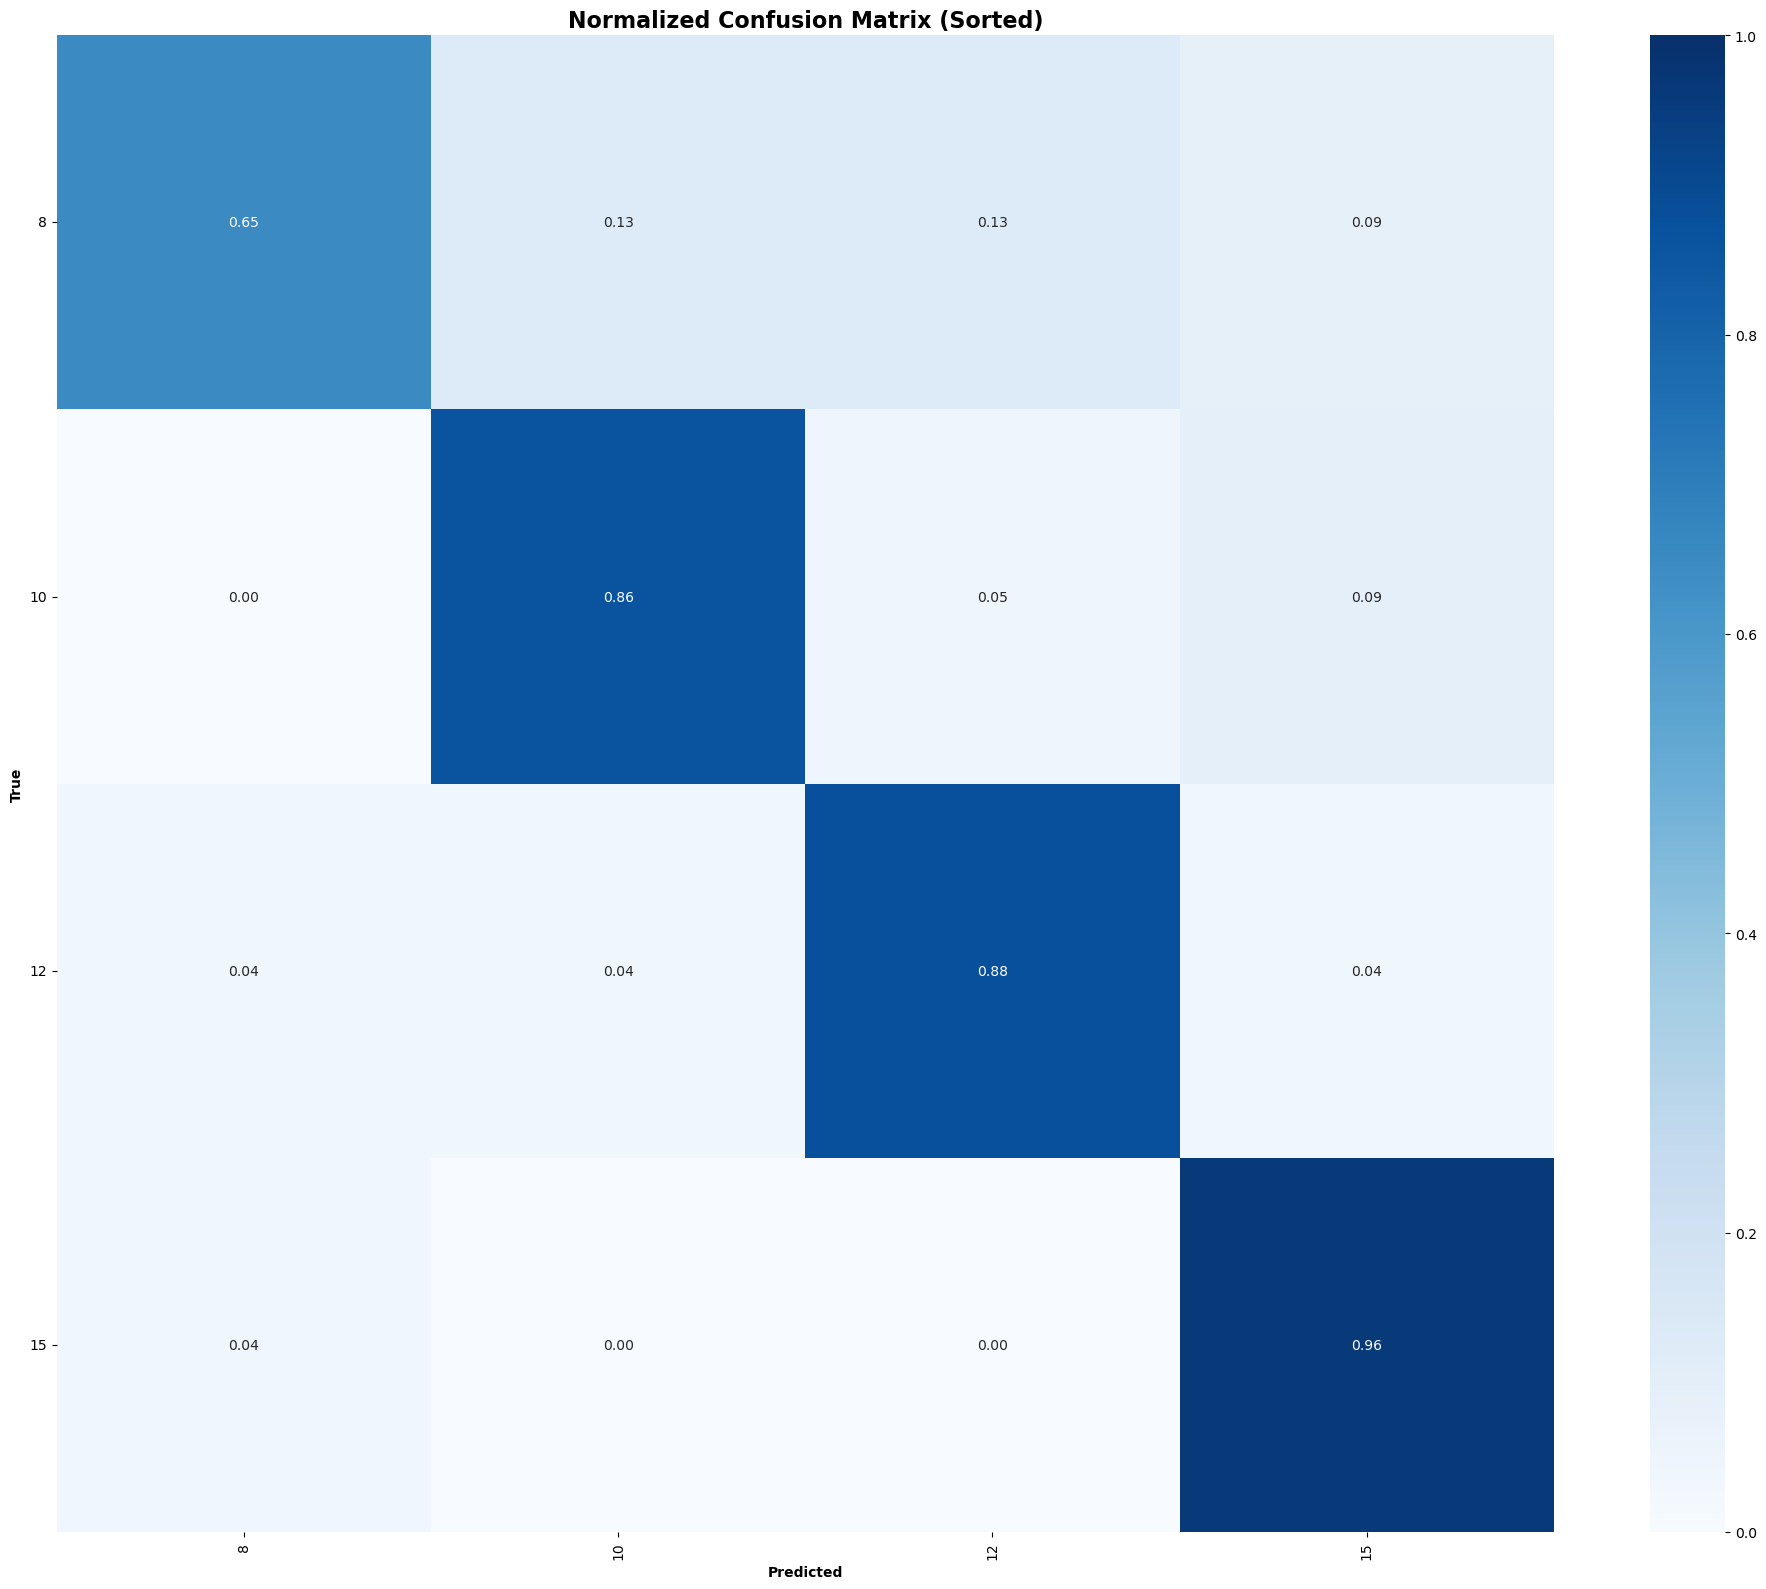

Test set Accuracy: 0.8438
Recall: 0.8438
F1 Score: 0.8396
Confusion Matrix:
[[15  3  3  2]
 [ 0 19  1  2]
 [ 1  1 21  1]
 [ 1  0  0 26]]
Running for subject S31 ---------------
Testing on subject 31.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.7500
Epoch 1/50: Train Loss: 1.2560, Train Accuracy: 0.3936, Val Loss: 1.0603, Val Accuracy: 0.7500
Validation loss decreased...
Best model saved with accuracy: 0.8333
Epoch 2/50: Train Loss: 0.7344, Train Accuracy: 0.7422, Val Loss: 0.4990, Val Accuracy: 0.8333
Validation loss decreased...
Best model saved with accuracy: 0.9583
Epoch 3/50: Train Loss: 0.6106, Train Accuracy: 0.7831, Val Loss: 0.2378, Val Accuracy: 0.9583
Validation loss decreased...
Epoch 4/50: Train Loss: 0.5062, Train Accuracy: 0.8260, Val Loss: 0.3137, Val Accuracy: 0.9583
Epoch 5/50: Train Loss: 0.4981, Train Accuracy: 0.8270, Val Loss: 0.3102, Val Accuracy: 0.9167
Epoch 6/50: Train Loss: 0.4603, Train Accur

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

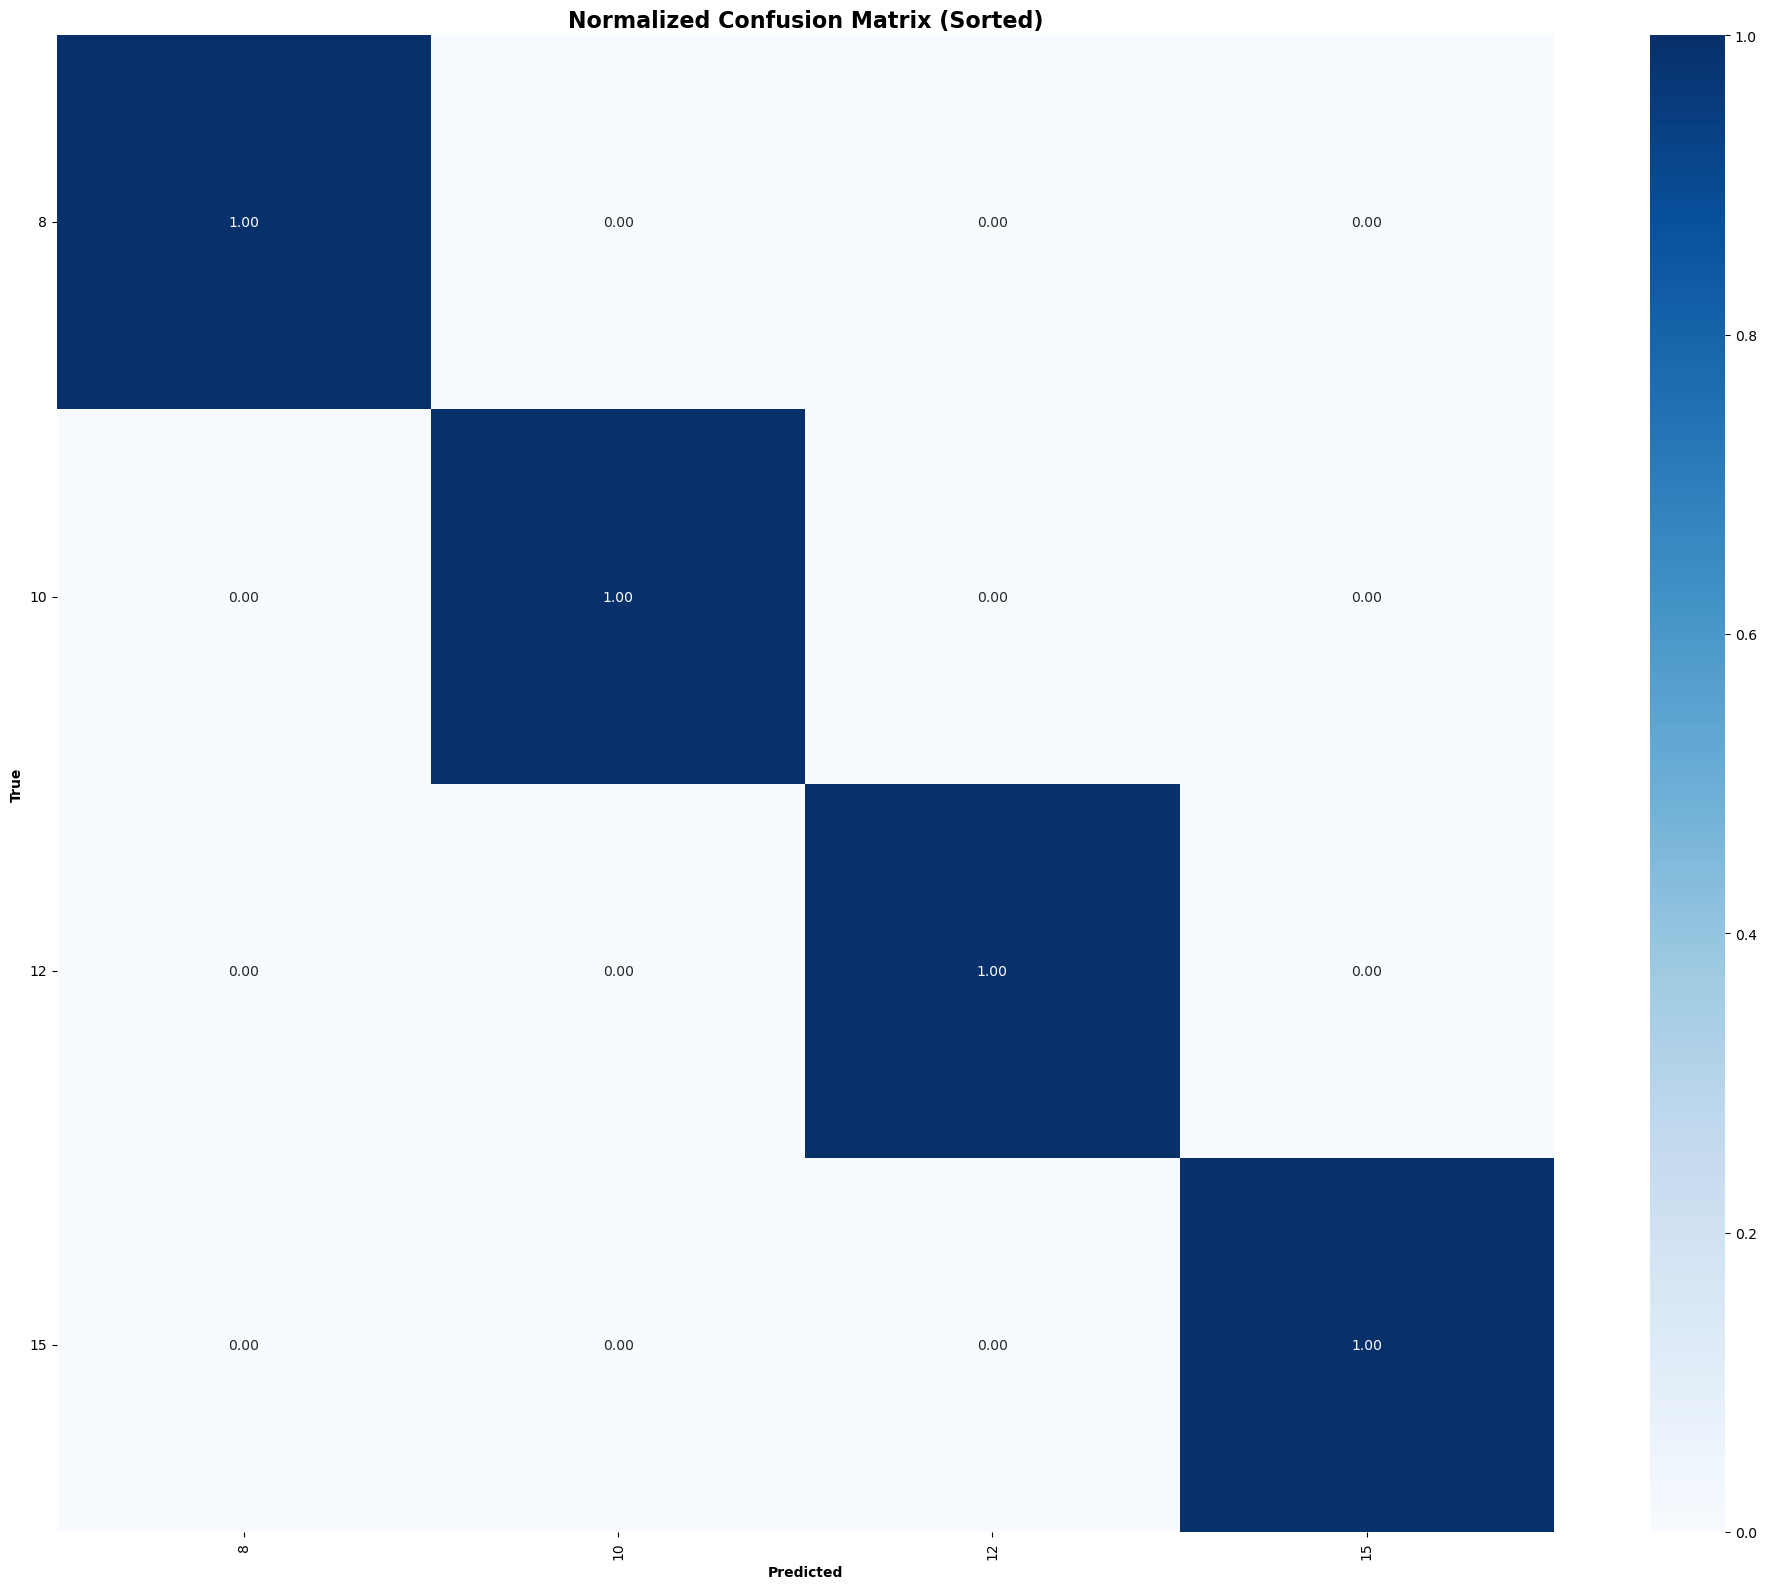

Test set Accuracy: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Confusion Matrix:
[[23  0  0  0]
 [ 0 22  0  0]
 [ 0  0 24  0]
 [ 0  0  0 27]]
Running for subject S32 ---------------
Testing on subject 32.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.9167
Epoch 1/50: Train Loss: 1.2137, Train Accuracy: 0.4145, Val Loss: 0.5010, Val Accuracy: 0.9167
Validation loss decreased...
Best model saved with accuracy: 1.0000
Epoch 2/50: Train Loss: 0.7484, Train Accuracy: 0.7270, Val Loss: 0.1263, Val Accuracy: 1.0000
Validation loss decreased...
Epoch 3/50: Train Loss: 0.5834, Train Accuracy: 0.7904, Val Loss: 0.0482, Val Accuracy: 1.0000
Validation loss decreased...
Epoch 4/50: Train Loss: 0.5400, Train Accuracy: 0.8157, Val Loss: 0.0566, Val Accuracy: 1.0000
Epoch 5/50: Train Loss: 0.4815, Train Accuracy: 0.8279, Val Loss: 0.0171, Val Accuracy: 1.0000
Validation loss decreased...
Epoch 6/50: Train Loss: 0.4806, Train Accuracy: 0.834

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

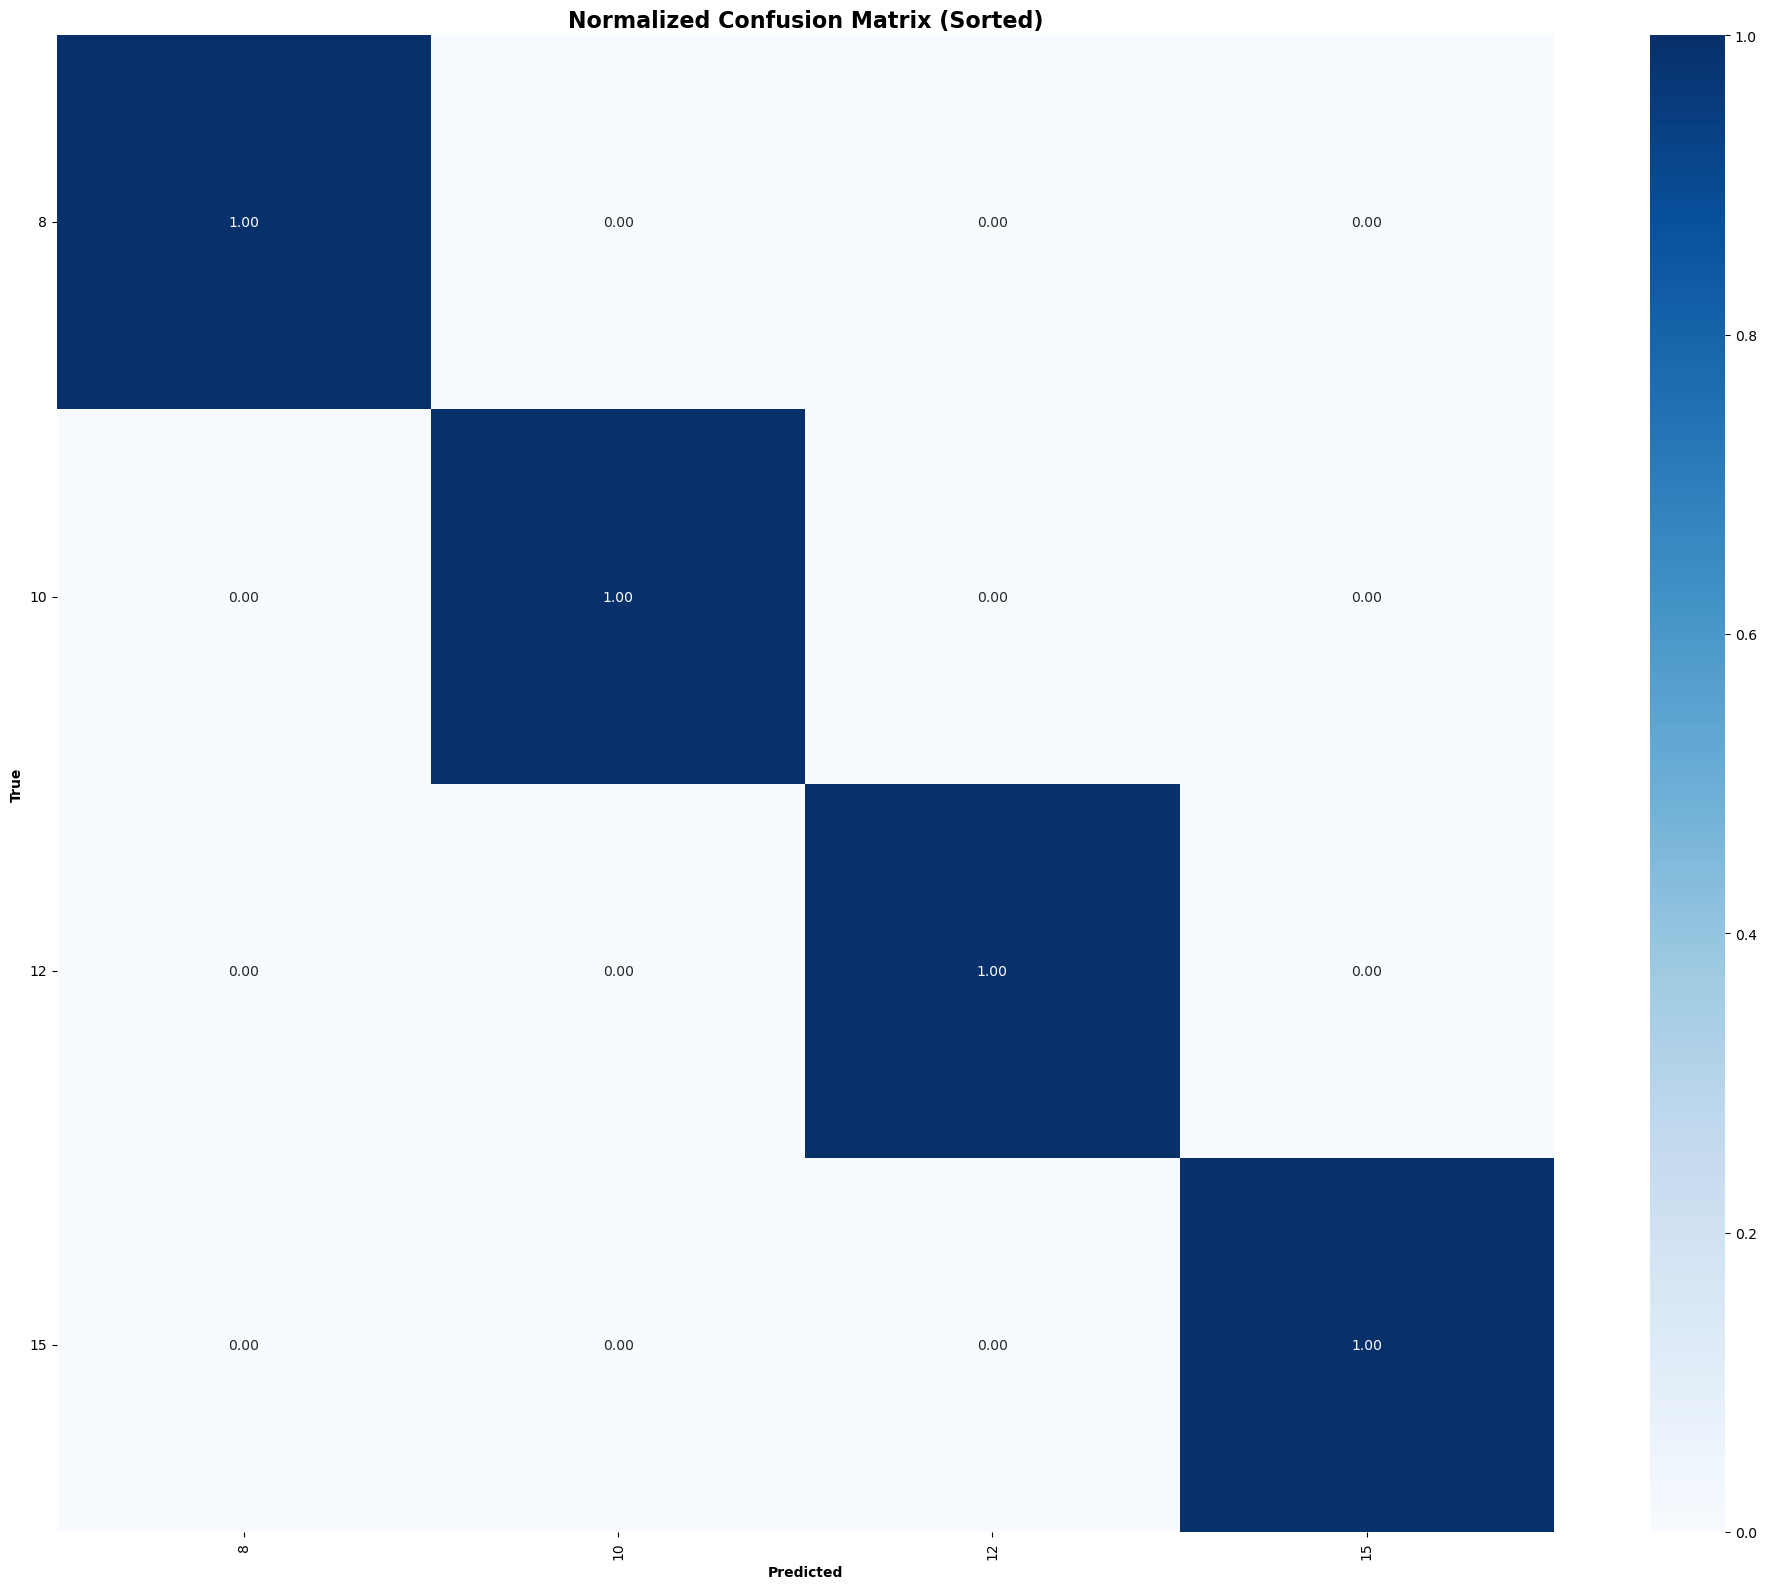

Test set Accuracy: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Confusion Matrix:
[[23  0  0  0]
 [ 0 22  0  0]
 [ 0  0 24  0]
 [ 0  0  0 27]]
Running for subject S33 ---------------
Testing on subject 33.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.2917
Epoch 1/50: Train Loss: 1.2245, Train Accuracy: 0.4105, Val Loss: 1.3490, Val Accuracy: 0.2917
Validation loss decreased...
Best model saved with accuracy: 0.3750
Epoch 2/50: Train Loss: 0.7364, Train Accuracy: 0.7395, Val Loss: 1.3405, Val Accuracy: 0.3750
Epoch 3/50: Train Loss: 0.5441, Train Accuracy: 0.8088, Val Loss: 1.3632, Val Accuracy: 0.3333
Epoch 4/50: Train Loss: 0.4925, Train Accuracy: 0.8343, Val Loss: 1.3494, Val Accuracy: 0.2917
Best model saved with accuracy: 0.4167
Epoch 5/50: Train Loss: 0.4727, Train Accuracy: 0.8507, Val Loss: 1.3410, Val Accuracy: 0.4167
Best model saved with accuracy: 0.5417
Epoch 6/50: Train Loss: 0.4301, Train Accuracy: 0.8566, Val Lo

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

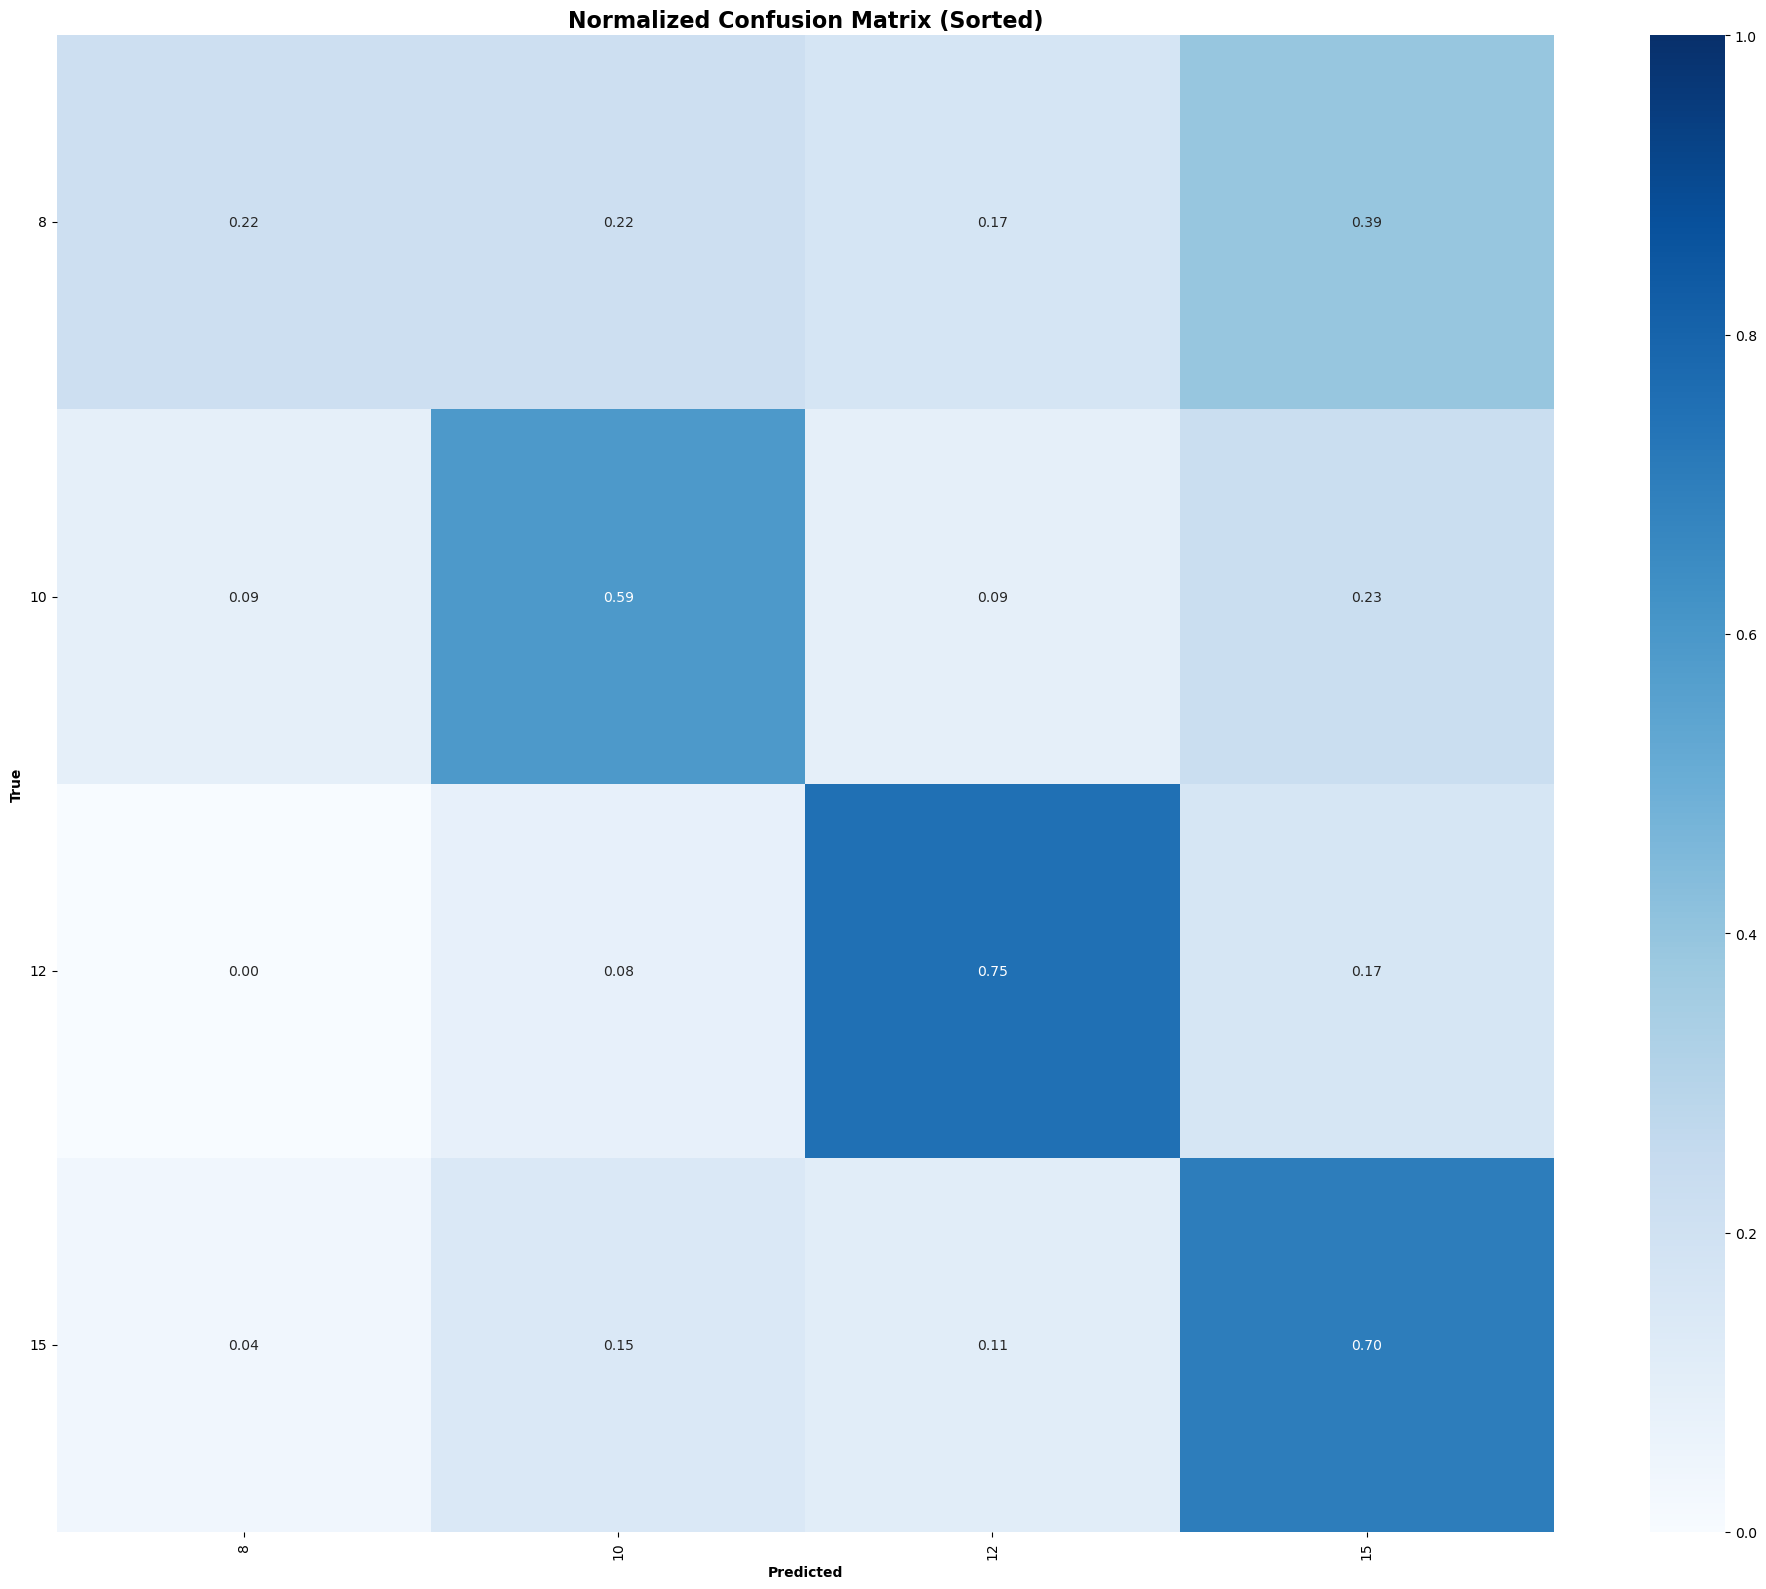

Test set Accuracy: 0.5729
Recall: 0.5729
F1 Score: 0.5503
Confusion Matrix:
[[ 5  5  4  9]
 [ 2 13  2  5]
 [ 0  2 18  4]
 [ 1  4  3 19]]
Running for subject S34 ---------------
Testing on subject 34.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.9167
Epoch 1/50: Train Loss: 1.2340, Train Accuracy: 0.4145, Val Loss: 0.6582, Val Accuracy: 0.9167
Validation loss decreased...
Best model saved with accuracy: 0.9583
Epoch 2/50: Train Loss: 0.6998, Train Accuracy: 0.7520, Val Loss: 0.1528, Val Accuracy: 0.9583
Validation loss decreased...
Epoch 3/50: Train Loss: 0.5795, Train Accuracy: 0.8012, Val Loss: 0.1243, Val Accuracy: 0.9583
Validation loss decreased...
Epoch 4/50: Train Loss: 0.5173, Train Accuracy: 0.8250, Val Loss: 0.0808, Val Accuracy: 0.9583
Validation loss decreased...
Epoch 5/50: Train Loss: 0.4971, Train Accuracy: 0.8250, Val Loss: 0.1199, Val Accuracy: 0.9583
Epoch 6/50: Train Loss: 0.4653, Train Accuracy: 0.842

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

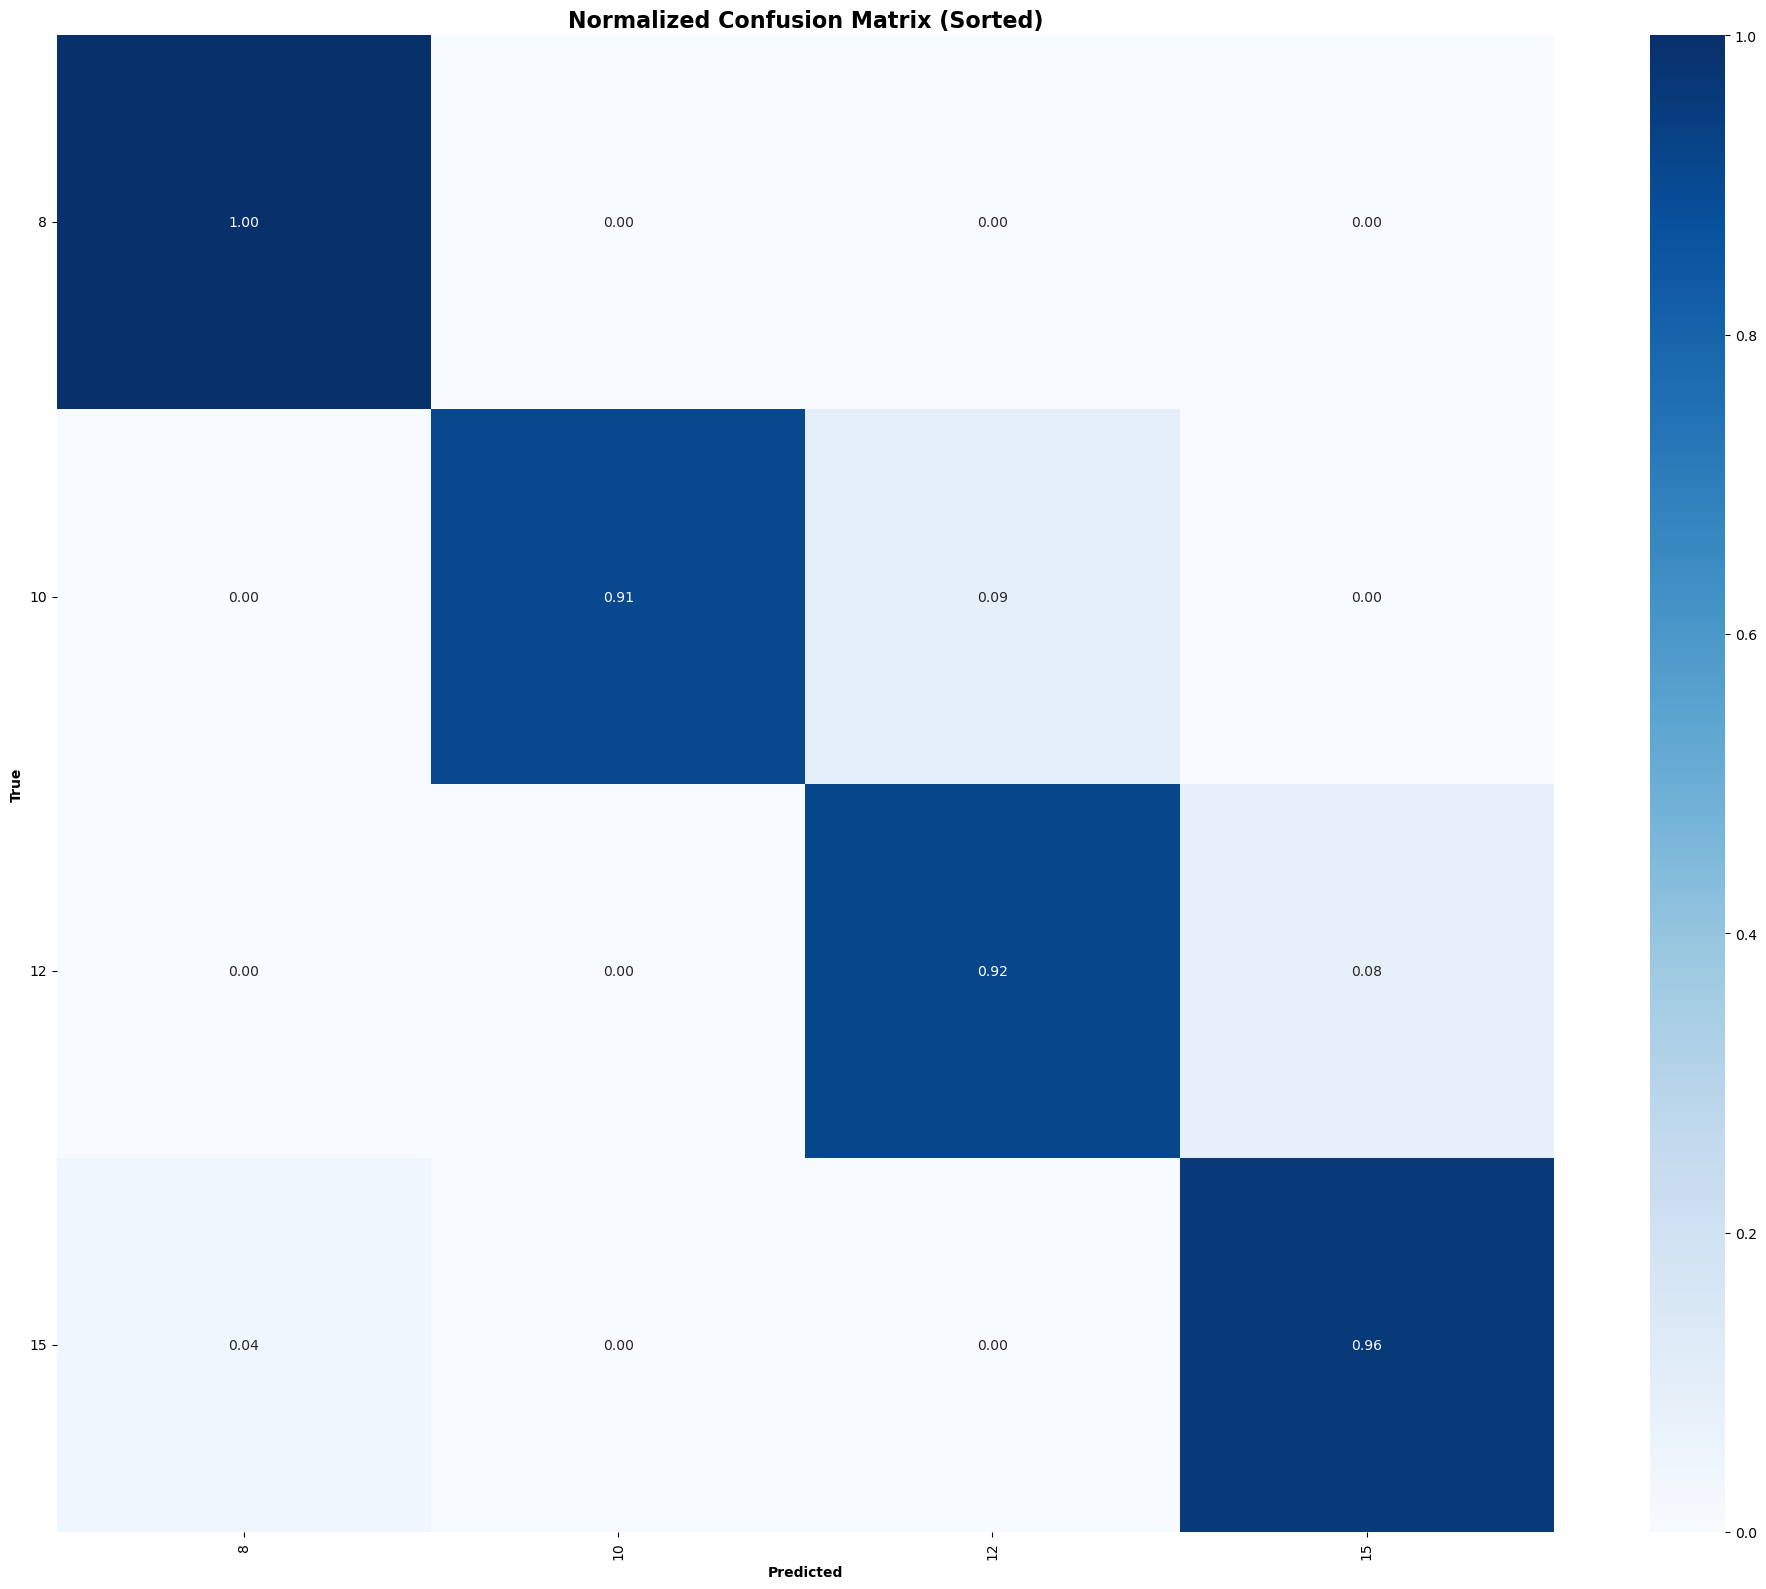

Test set Accuracy: 0.9479
Recall: 0.9479
F1 Score: 0.9478
Confusion Matrix:
[[23  0  0  0]
 [ 0 20  2  0]
 [ 0  0 22  2]
 [ 1  0  0 26]]
Running for subject S35 ---------------
Testing on subject 35.
Training dataset size: 4080
Validation dataset size: 24
Test dataset size: 96
Best model saved with accuracy: 0.6667
Epoch 1/50: Train Loss: 1.2689, Train Accuracy: 0.3669, Val Loss: 0.9259, Val Accuracy: 0.6667
Validation loss decreased...
Best model saved with accuracy: 0.7917
Epoch 2/50: Train Loss: 0.7502, Train Accuracy: 0.7181, Val Loss: 0.7879, Val Accuracy: 0.7917
Validation loss decreased...
Best model saved with accuracy: 0.8750
Epoch 3/50: Train Loss: 0.6208, Train Accuracy: 0.7819, Val Loss: 0.6125, Val Accuracy: 0.8750
Validation loss decreased...
Epoch 4/50: Train Loss: 0.5345, Train Accuracy: 0.8191, Val Loss: 0.4901, Val Accuracy: 0.7917
Validation loss decreased...
Epoch 5/50: Train Loss: 0.5197, Train Accuracy: 0.8277, Val Loss: 0.4191, Val Accuracy: 0.8750
Validation los

C:\Users\machi\AppData\Local\Temp\ipykernel_19824\2014333968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path)

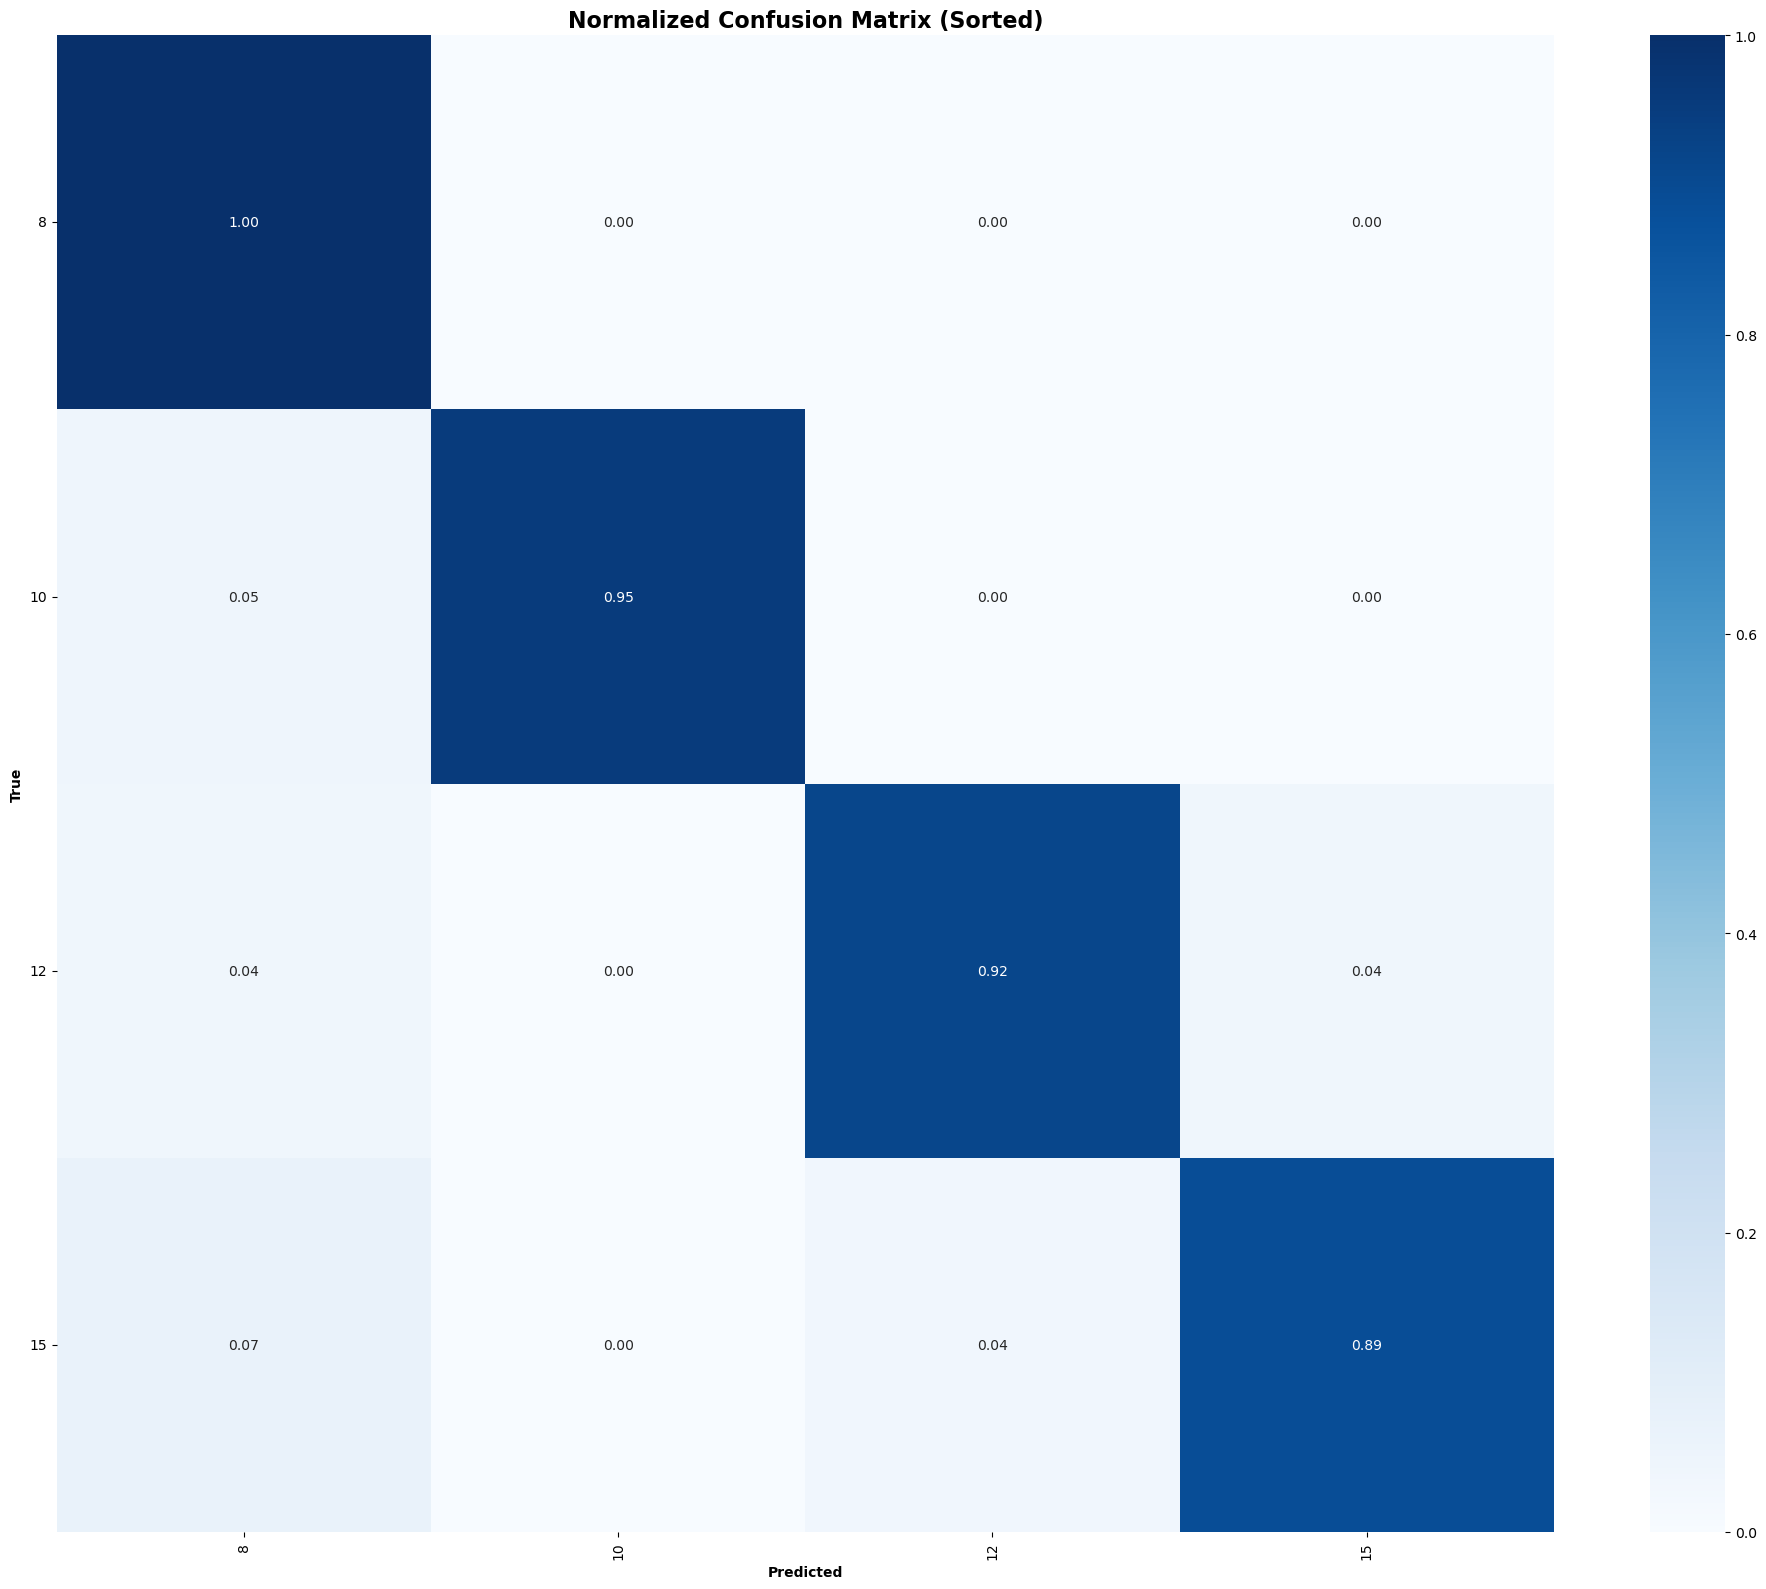

Test set Accuracy: 0.9375
Recall: 0.9375
F1 Score: 0.9379
Confusion Matrix:
[[23  0  0  0]
 [ 1 21  0  0]
 [ 1  0 22  1]
 [ 2  0  1 24]]


In [7]:
dataset_path = Path("datasets/sinais_filtrados_6_52_Hz_janelas_1s/")
freq_phase = scipy.io.loadmat("Freq_Phase.mat")
freqs = np.round(freq_phase["freqs"], 2)
selected_freqs = np.array(
    [8, 10, 12, 15]
)  # freqs[0][0:8]  #    # Frequências de interesse

channels = [
    47,
    53,
    54,
    55,
    56,
    57,
    60,
    61,
    62,
]  #  Pz, PO5, PO3, POz, PO4, PO6, O1, Oz, O2

epochs = 50
results_dict = run_model_for_all_subjects(
    dataset_path, 32, channels, selected_freqs, epochs
)
# mean_results_dict = {}

# for subj, metrics in results_dict.items():
#     means = {}
#     for metric, values in metrics.items():
#         means[metric] = values.mean()
#     mean_results_dict[subj] = means

df = pd.DataFrame.from_dict(results_dict, orient="index")

df.to_csv(
    "best_trained_raw_models/cross_subject/4freq/results_cnn1d_cross_subj_4_freqs.csv"
)

# Simpler model

In [22]:
# Define o modelo com conv1d
class CNNModel1dSmall(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(CNNModel1dSmall, self).__init__()

        self.cnn = nn.Sequential(
            # Bloco 1
            nn.Conv1d(n_channels, 32, kernel_size=16),  # entrada
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            # Bloco 2
            nn.Conv1d(32, 16, kernel_size=8),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )

        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(880, 125),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(125, n_classes),
        )

    def forward(self, x):
        # Camadas convolucionais
        x = self.cnn(x)
        # Flatten
        x = x.view(x.size(0), -1)
        # Fully connected
        x = self.fc(x)
        # log softmax para pegar as probabilidades
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
windows = np.load(
    "datasets/sinais_filtrados_6_52_Hz_janelas_1s/S1_passa-banda_6_52_Hz_janelas.npy"
)
frequencias_fases = scipy.io.loadmat("Freq_Phase.mat")
frequencias = np.round(
    frequencias_fases["freqs"], 2
)  # Frequências de estimulação, arredondadas
fases = frequencias_fases["phases"]  # Fases associadas às frequências

freq_selecionadas = np.array([8, 10, 12, 15])  # Frequências de interesse
channels = [
    47,
    53,
    54,
    55,
    56,
    57,
    60,
    61,
    62,
]  #  Pz, PO5, PO3, POz, PO4, PO6, O1, Oz, O2

labels = []
signals = []
for trial in range(0, 6):
    labels_trial = []
    signals_trial = []
    for idx, freq in enumerate(freq_selecionadas):
        for window in range(0, 5):
            signal = windows[
                channels, :, np.where(frequencias == freq)[1], trial, window
            ]
            signals_trial.append(signal)
            labels_trial.append(idx)
    labels.append(labels_trial)
    signals.append(signals_trial)

signals = np.array(signals)
labels = np.array(labels)
print(signals.shape)
print(labels.shape)

In [ ]:
all_acc = []
all_recall = []
all_f1 = []
for test_trial in range(0, 6):
    train_loader, test_loader = prepare_data(
        signals, labels, test_trial=test_trial, train_batch_size=20
    )

    model = CNNModel1dSmall(9, 4).to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Train the model
    train(
        model,
        train_loader,
        test_loader,
        criterion,
        optimizer,
        num_epochs=100,
        save_path="best_model_raw_small.pth",
    )
    best_model = CNNModel1dSmall(n_channels=9, n_classes=4)
    best_model.load_state_dict(torch.load("best_model_raw_small.pth"))
    best_model.to(device)
    # Eval
    acc, rcll, f1s = evaluate(
        best_model, test_loader, class_labels=["8", "10", "12", "15"]
    )
    all_acc.append(acc)
    all_recall.append(rcll)
    all_f1.append(f1s)
all_acc = np.array(all_acc)
all_recall = np.array(all_recall)
all_f1 = np.array(all_f1)

In [ ]:
print(all_acc.mean())
print(all_recall.mean())
print(all_f1.mean())

In [26]:
def run_and_evaluate_small(subject, signals, labels, batch_size, epochs):
    all_acc = []
    all_recall = []
    all_f1 = []
    for test_trial in range(0, 6):
        train_loader, test_loader = prepare_data(
            signals, labels, test_trial=test_trial, train_batch_size=batch_size
        )

        num_channels = signals.shape[2]
        num_freqs = len(np.unique(labels))

        model = CNNModel1dSmall(num_channels, num_freqs).to(device)
        criterion = nn.NLLLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        # Train the model
        best_model_save_path = f"best_trained_raw_models/2layers_cnn/{subject}_best_model_raw_{test_trial}.pth"
        train(
            model,
            train_loader,
            test_loader,
            criterion,
            optimizer,
            num_epochs=epochs,
            save_path=best_model_save_path,
        )
        # Eval
        best_model = CNNModel1dSmall(n_channels=num_channels, n_classes=num_freqs)
        best_model.load_state_dict(torch.load(best_model_save_path))
        best_model.to(device)
        acc, rcll, f1s = evaluate(
            best_model, test_loader, class_labels=["8", "10", "12", "15"]
        )
        all_acc.append(acc)
        all_recall.append(rcll)
        all_f1.append(f1s)
    metrics = {
        "accuracy": np.array(all_acc),
        "recall": np.array(all_recall),
        "f1_score": np.array(all_f1),
    }
    return metrics


def run_small_model_for_all_subjects(
    dataset_path, batch_size, channels, classes, epochs
):
    results = {}

    subjects_files = [file for file in dataset_path.glob("*.npy")]
    freq_phase = scipy.io.loadmat("Freq_Phase.mat")
    freqs = np.round(freq_phase["freqs"], 2)  # Frequências de estimulação, arredondadas
    phases = freq_phase["phases"]  # Fases associadas às frequências

    for subject_file in subjects_files:
        subject = subject_file.name.split("_")[0]
        print(f"Running for subject {subject} ---------------")
        windows = np.load(subject_file)
        signals, labels = get_desired_freqs_and_classes(
            windows, freqs, channels, classes
        )
        results[subject] = run_and_evaluate_small(
            subject, signals, labels, batch_size, epochs
        )
    return results

In [ ]:
dataset_path = Path("datasets/sinais_filtrados_6_52_Hz_janelas_1s/")
selected_freqs = np.array([8, 10, 12, 15])  # Frequências de interesse
channels = [
    47,
    53,
    54,
    55,
    56,
    57,
    60,
    61,
    62,
]  #  Pz, PO5, PO3, POz, PO4, PO6, O1, Oz, O2
epochs = 100
results_dict = run_small_model_for_all_subjects(
    dataset_path, 20, channels, selected_freqs, epochs
)

mean_results_dict = {}
for subj, metrics in results_dict.items():
    means = {}
    for metric, values in metrics.items():
        means[metric] = values.mean()
    mean_results_dict[subj] = means
df = pd.DataFrame.from_dict(mean_results_dict, orient="index")
df.to_csv("results_cnn1d_2_layers_intra_subject.csv")